# Learning Coefficients

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()

if not "AWS_ACCESS_KEY_ID" in os.environ or not "AWS_SECRET_ACCESS_KEY" in os.environ:
    raise Exception("AWS_ACCESS_KEY_ID or AWS_SECRET_ACCESS_KEY not found in environment variables. Please set them in .env file.")

In [38]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pprint import pp
from pathlib import Path
from typing import Optional, Iterable, List, Tuple, Dict, Union, Callable
import warnings

import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch 
from torch import nn
import wandb
import matplotlib.pyplot as plt
import pandas as pd

import devinterp
import devinfra
from devinfra.utils.iterables import filter_objs

# del sys.modules['icl.analysis.utils']
from icl.analysis.utils import wandb_runs_to_df
from icl.constants import SWEEPS, FIGURES, ANALYSIS
from icl.analysis.utils import get_unique_run


api= wandb.Api()



from icl.constants import FIGURES, ANALYSIS, DEVICE

## Set-up

In [2]:
from icl.analysis.utils import get_sweep_configs

NUM_LAYERS = 2
NUM_HEADS = 4
LR = 0.003

TRAINING_SWEEP_ID = "8rxvu833"
TRAINING_SWEEP_FILENAME = "training-runs/L2H4Minf.yaml"

filters = {"task_config": {"num_layers": NUM_LAYERS, "num_heads": NUM_HEADS}, "optimizer_config": {"lr": LR}}  # TODO: Where are the H=2 runs?
configs = list(get_sweep_configs(SWEEPS / TRAINING_SWEEP_FILENAME, **filters))

print(f"Found {len(configs)} runs.")

Found 10 runs.


/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(


In [3]:
# Figure out which checkpoints are available

checkpointers = [config.checkpointer_config.factory() for config in tqdm(configs, desc="Reading checkpoints")]

for checkpointer in tqdm(checkpointers, desc="Loading checkpoints"):
    print(f"Found {len(checkpointer.file_ids)} checkpoints for {checkpointer}")

Reading checkpoints:   0%|          | 0/10 [00:00<?, ?it/s]

Loading checkpoints: 100%|██████████| 10/10 [00:00<00:00, 45639.87it/s]

Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54)])
Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-inf-task-0d5c2a-opt-4f4cb7-sched-4bcc54)])
Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-inf-task-644b50-opt-4f4cb7-sched-4bcc54)])
Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-inf-task-5a3af8-opt-4f4cb7-sched-4bcc54)])
Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-inf-task-7885a9-opt-4f4cb7-sched-4bcc54)])
Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-inf-task-5a9caf-opt-4f4cb7-sched-4bcc54)])
Found 190 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoin

In [4]:
MS = [config.task_config.num_tasks for config in configs] # [1, 4, 64, 2**10, 2**20]
STEPS = checkpointer.file_ids

# Calibrating LLCs

Let's look at finding the right hyperparameters for learning coefficient estimation

## Temperature, Learning Rate, and Localization Strength

In [204]:
FORCE_REEVAL = True

EVAL_EPS_TEMP_GAMMA_SWEEP_NAME = "eps-temp-gamma"
EVAL_EPS_TEMP_GAMMA_SWEEP_ID = "20ygh3o1"

if not os.path.exists(ANALYSIS / EVAL_EPS_TEMP_GAMMA_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_eps_temp_gamma_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_EPS_TEMP_GAMMA_SWEEP_ID}")
        eval_eps_temp_gamma_runs = list(filter_objs([r for r in eval_eps_temp_gamma_sweep.runs], config=filters))
        eval_eps_temp_gamma_df = wandb_runs_to_df(eval_eps_temp_gamma_runs)
    
    eval_eps_temp_gamma_df.to_pickle(ANALYSIS / EVAL_EPS_TEMP_GAMMA_SWEEP_NAME)

else:
    eval_eps_temp_gamma_df = pd.read_pickle(ANALYSIS / EVAL_EPS_TEMP_GAMMA_SWEEP_NAME)

# columns_to_convert = ['loss/mean/mean', 'loss/std/mean', 'llc/mean/mean', 'llc/std/mean', 'wbic/mean/mean', 'wbic/std/mean']  # Replace with your actual column names

# for col in columns_to_convert:
#     eval_eps_temp_gamma_df[col] = pd.to_numeric(eval_eps_temp_gamma_df[col], errors='coerce')

# eval_eps_temp_gamma_df.reset_index(inplace=True)
eval_eps_temp_gamma_df

Converting runs to dfs: 100%|██████████| 1022/1022 [05:33<00:00,  3.07it/s]


num_training_samples  batch_size  \
0               128000000         256   
1               128000000         256   
2               128000000         256   
3               128000000         256   
4               128000000         256   
..                    ...         ...   
396             128000000         256   
397             128000000         256   
398             128000000         256   
399             128000000         256   
400             128000000         256   

                                           run_name  num_steps  \
0    ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
1    ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
2    ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
3    ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
4    ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
..                                              ...        ...   
396  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
397  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
398  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
399  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
400  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   

    optimizer_config/optimizer_type  optimizer_config/lr  \
0                              Adam                0.003   
1                              Adam                0.003   
2                              Adam                0.003   
3                              Adam                0.003   
4                              Adam                0.003   
..                              ...                  ...   
396                            Adam                0.003   
397                            Adam                0.003   
398                            Adam                0.003   
399                            Adam                0.003   
400                            Adam                0.003   

     optimizer_config/weight_decay optimizer_config/momentum  \
0                              0.0                      None   
1                              0.0                      None   
2                              0.0                      None   
3                              0.0                      None   
4                              0.0                      None   
..                             ...                       ...   
396                            0.0                      None   
397                            0.0                      None   
398                            0.0                      None   
399                            0.0                      None   
400                            0.0                      None   

    optimizer_config/betas optimizer_config/noise_level  ...  llc/mean/7  \
0             (0.9, 0.999)                         None  ...  198.145935   
1             (0.9, 0.999)                         None  ...  284.066010   
2             (0.9, 0.999)                         None  ...  308.217651   
3             (0.9, 0.999)                         None  ...  320.803192   
4             (0.9, 0.999)                         None  ...  328.746857   
..                     ...                          ...  ...         ...   
396           (0.9, 0.999)                         None  ...    3.743072   
397           (0.9, 0.999)                         None  ...    3.744713   
398           (0.9, 0.999)                         None  ...    3.744066   
399           (0.9, 0.999)                         None  ...    3.743125   
400           (0.9, 0.999)                         None  ...         NaN   

    wbic/std/mean loss/std/mean loss/mean/7    wbic/std/2 wbic/mean/mean  \
0    6.479783e+06      6.179603   11.086855  5.634686e+06   9.918175e+06   
1    5.950557e+06      5.674894   15.382858  5.214758e+06   1.336610e+07   
2    5.197532e+06      4.956753   16.590441  4.560356e+06   1.428565e+07   
3    4.67350

In [205]:
eval_eps_temp_gamma_df["epsilon"] = eval_eps_temp_gamma_df["sampler_config/noise_scale"]
eval_eps_temp_gamma_df["beta"] = eval_eps_temp_gamma_df["sampler_config/gradient_scale"] * 2 / (eval_eps_temp_gamma_df["sampler_config/noise_scale"] *eval_eps_temp_gamma_df["task_config/num_tasks"])
eval_eps_temp_gamma_df["gamma"] = eval_eps_temp_gamma_df["sampler_config/localization_scale"] * 2 / eval_eps_temp_gamma_df["sampler_config/noise_scale"]
# eval_eps_temp_gamma_df['version'] = [f"$t={row['step']}, LN={'T' if row['task_config/layer_norm'] else 'F'}$" for i, row in eval_eps_temp_gamma_df.iterrows()]
eval_eps_temp_gamma_df['version'] = [f"$t={row['step']}$" for i, row in eval_eps_temp_gamma_df.iterrows()]
# eval_eps_temp_gamma_df = eval_eps_temp_gamma_df[eval_eps_temp_gamma_df["sampler_config/noise_scale"] < 0.001]

<ipython-input-205-6ce09e3b09ec>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_eps_temp_gamma_df["epsilon"] = eval_eps_temp_gamma_df["sampler_config/noise_scale"]
<ipython-input-205-6ce09e3b09ec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_eps_temp_gamma_df["beta"] = eval_eps_temp_gamma_df["sampler_config/gradient_scale"] * 2 / (eval_eps_temp_gamma_df["sampler_config/noise_scale"] *eval_eps_temp_gamma_df["task_config/num_tasks"])
<ipython-input-205-6ce09e3b09ec>:3: PerformanceWarning: DataFrame is highly fragme

In [99]:
eval_eps_temp_gamma_df.columns.values

array(['_runtime', '_timestamp', 'loss_trace', '_step',
       'num_training_samples', 'batch_size', 'run_name', 'num_steps',
       'optimizer_config/optimizer_type', 'optimizer_config/lr',
       'optimizer_config/weight_decay', 'optimizer_config/momentum',
       'optimizer_config/betas', 'optimizer_config/noise_level',
       'optimizer_config/elasticity', 'optimizer_config/temperature',
       'optimizer_config/num_samples', 'scheduler_config/scheduler_type',
       'scheduler_config/step_size', 'scheduler_config/gamma',
       'scheduler_config/T_max', 'scheduler_config/eta_min',
       'scheduler_config/last_epoch', 'scheduler_config/milestones',
       'scheduler_config/lr_lambda', 'scheduler_config/max_lr',
       'scheduler_config/total_steps', 'scheduler_config/anneal_strategy',
       'scheduler_config/div_factor', 'scheduler_config/final_div_factor',
       'scheduler_config/pct_start', 'scheduler_config/cycle_momentum',
       'criterion', 'eval_batch_size', 'task_config/

In [207]:
df = eval_eps_temp_gamma_df.loc[eval_eps_temp_gamma_df["task_config/layer_norm"] == True]
# df = df.loc[(df["sampler_config/noise_scale"] > 0.0001)]
# df = df.loc[(df["sampler_config/gradient_scale"] > 0.0001)]

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


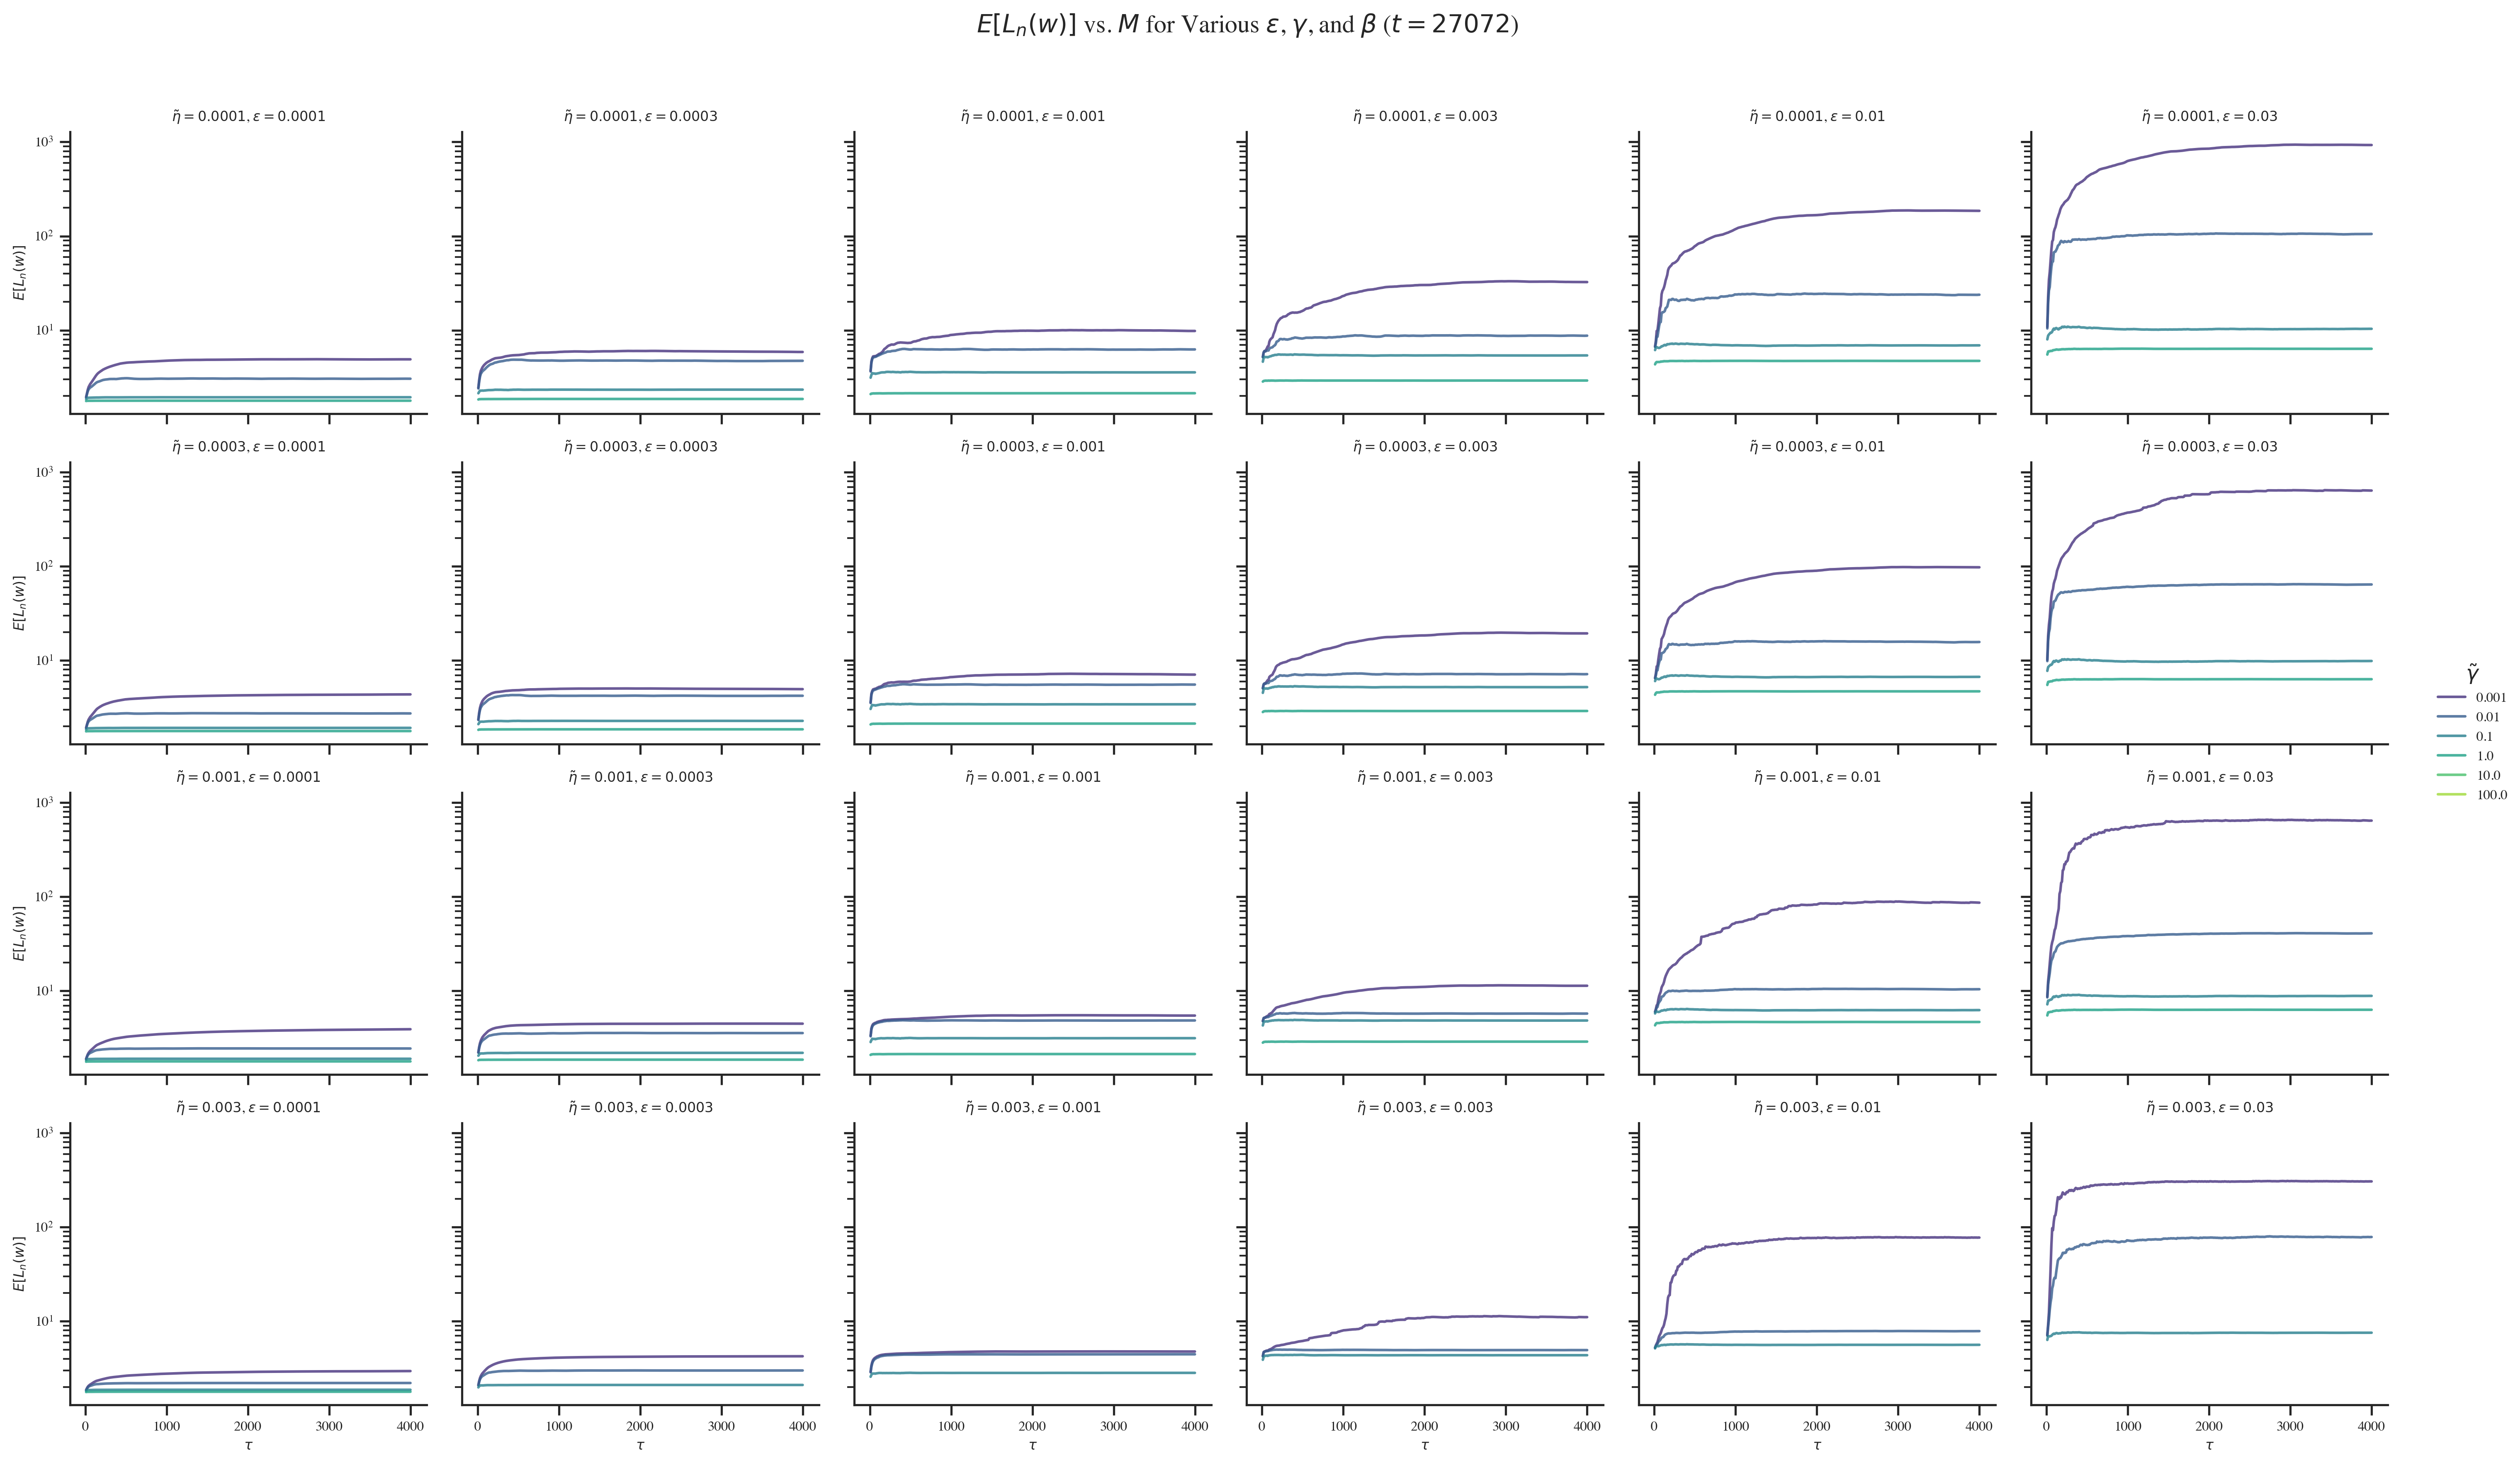

In [219]:
# fig = plt.figure(figsize=(HEIGHT * .5, WIDTH * .5))

# Assuming eval_dataset_size_df is your DataFrame
data = df.loc[df.step == df.step.max()]

# Step 2: Create FacetGrid
# Replace 'epsilon', 'gamma', 'temperature' with your actual column names
g = sns.FacetGrid(data=data, col='sampler_config/noise_scale', row='sampler_config/gradient_scale', hue='sampler_config/localization_scale', palette='viridis', sharey=True)

def plot_cell(x, y, data=None, **kwargs):
    ordering = np.argsort(data[x])
    plt.plot(data[x].values[ordering], data[y].values[ordering], '-', alpha=0.8, **kwargs)
    # plt.fill_between(data[x].values[ordering], data[y].values[ordering] - data['loss/std/mean'].values[ordering], data[y].values[ordering] + data['loss/std/mean'].values[ordering], alpha=0.05, color=kwargs['color'])

# Step 3: Plot the Data
g = g.map_dataframe(plot_cell, '_step', 'loss/mean/mean').add_legend()

# Adjust layout and aesthetics as needed
g.set_axis_labels(r'$\tau$', '$E[L_n(w)]$')
g.set_titles(r'$\tilde \eta={row_name}$, $\varepsilon={col_name}$')
g.legend.set_title(r'$\tilde \gamma$')
g.fig.subplots_adjust(top=0.9, right=0.95)
g.fig.suptitle(fr'$E[L_n(w)]$ vs. $M$ for Various $\epsilon$, $\gamma$, and $\beta$ ({version})')

# log y 
g.set(yscale='log')

g.fig.savefig(FIGURES / f"llc-vs-eps-gamma-beta-1.pdf", bbox_inches='tight')
# Show the plot
plt.show()

<ipython-input-212-7bec5553f7df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='sampler_config/gradient_scale', inplace=True)
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


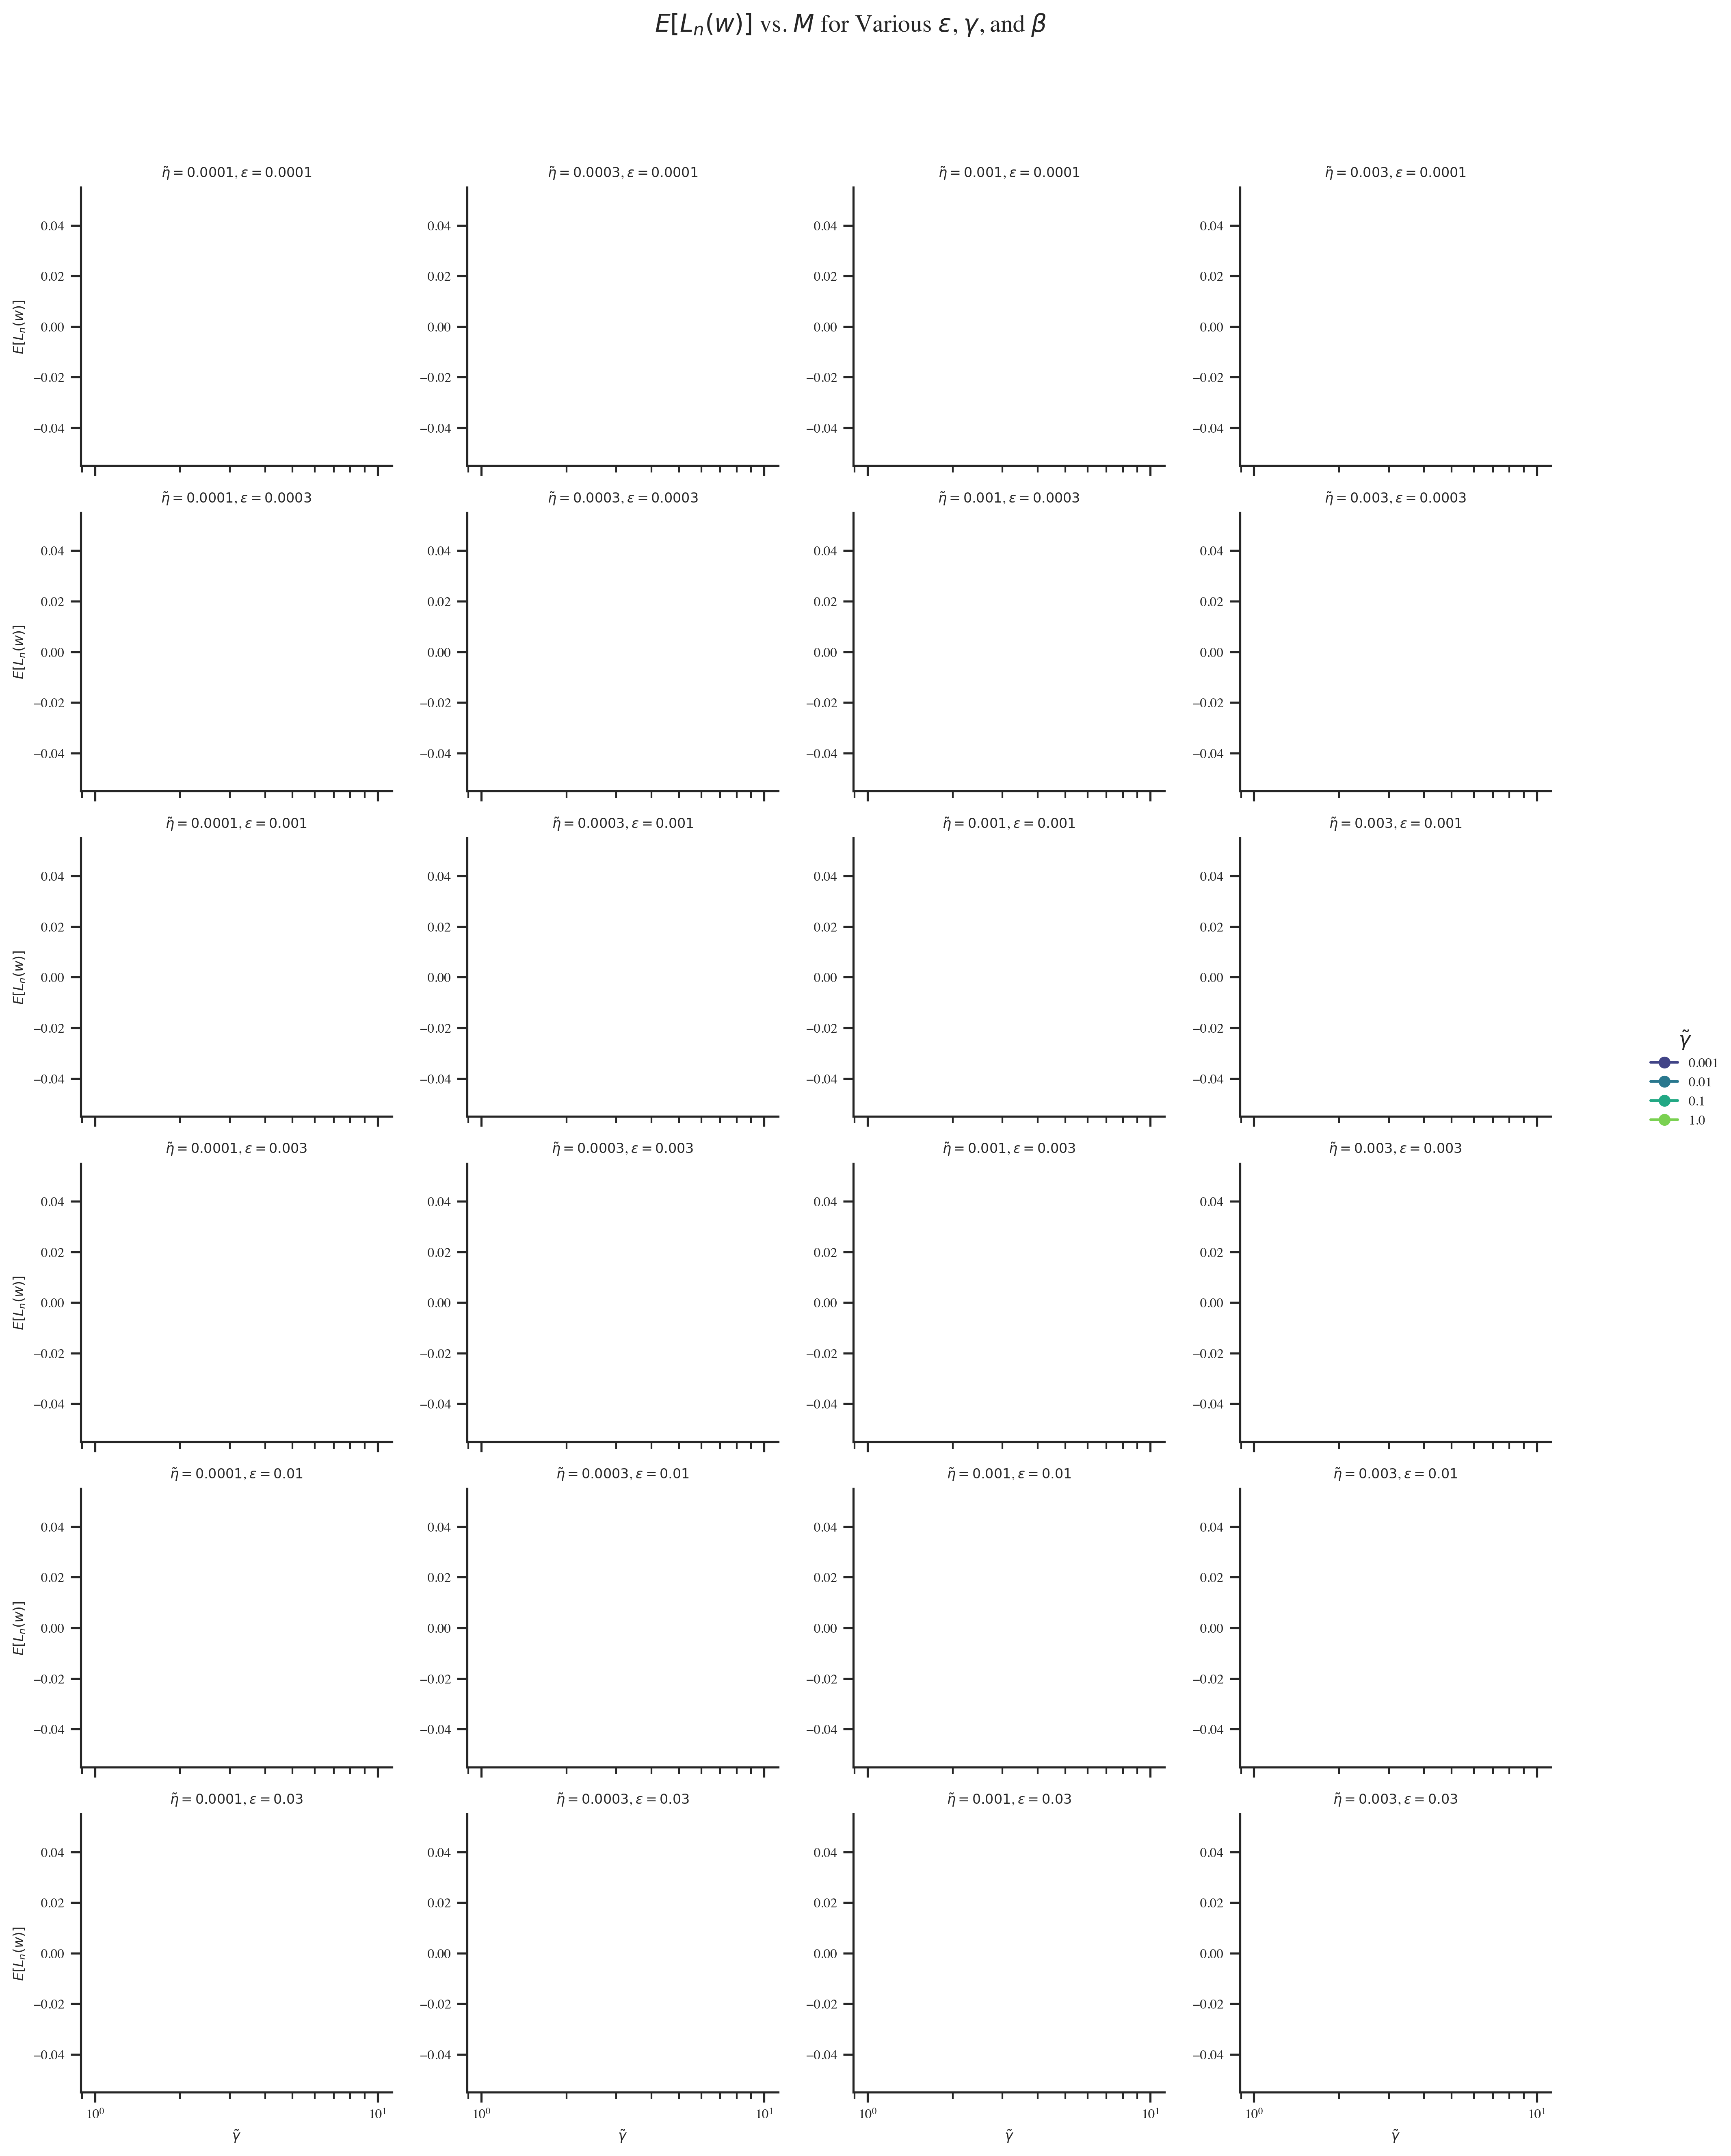

In [212]:
data = df.loc[df['_step'] == df['_step'].max()]

# Assuming eval_dataset_size_df is your DataFrame
data.sort_values(by='sampler_config/gradient_scale', inplace=True)

# Step 1: Filter Data
max_draw_df = data[data['_step'] == data['_step'].max()].sort_values(by='task_config/num_tasks')

# Step 2: Create FacetGrid
# Replace 'epsilon', 'gamma', 'temperature' with your actual column names
g = sns.FacetGrid(data=max_draw_df, col='sampler_config/gradient_scale', row='sampler_config/noise_scale', hue="sampler_config/localization_scale", palette='viridis', sharey=False)

def plot_cell(x, y, data=None, **kwargs):
    plt.xscale('log', base=10)
    ordering = np.argsort(data[x])
    plt.plot(data[x].values[ordering], data[y].values[ordering], 'o-', alpha=1, **kwargs)
    # plt.fill_between(data[x], data[y] - data['loss/std/mean'], data[y] + data['loss/std/mean'], alpha=0.5, color=kwargs['color'])


# Step 3: Plot the Data
g = g.map_dataframe(plot_cell, 'step', 'llc/mean/mean', data=data).add_legend()

# Adjust layout and aesthetics as needed
g.set_axis_labels(r'$\tilde \gamma$', '$E[L_n(w)]$')
g.set_titles(r'$\tilde\eta={col_name}$, $\varepsilon={row_name}$')
g.legend.set_title(r'$\tilde \gamma$')
g.fig.subplots_adjust(top=0.9, right=0.9)
g.fig.suptitle(fr'$E[L_n(w)]$ vs. $M$ for Various $\epsilon$, $\gamma$, and $\beta$')

# Show the plot
plt.show()

## Evaluation Dataset

### Evaluation Dataset Size

In [35]:
FORCE_REEVAL = True

EVAL_DATASET_SIZE_SWEEP_NAME = "eval-dataset-size"
EVAL_DATASET_SIZE_SWEEP_ID = "2s8wbx80"

if not os.path.exists(ANALYSIS / EVAL_DATASET_SIZE_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_dataset_size_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_DATASET_SIZE_SWEEP_ID}")
        eval_dataset_size_runs = list(filter_objs([r for r in eval_dataset_size_sweep.runs], config=filters))
        eval_dataset_size_df = wandb_runs_to_df(eval_dataset_size_runs)
    
    eval_dataset_size_df.to_pickle(ANALYSIS / EVAL_DATASET_SIZE_SWEEP_NAME)

else:
    eval_dataset_size_df = pd.read_pickle(ANALYSIS / EVAL_DATASET_SIZE_SWEEP_NAME)

# columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

# # Convert each column to numeric, coercing "NaN" strings to actual NaN values
# for col in columns_to_convert:
#     eval_dataset_size_df[col] = pd.to_numeric(eval_dataset_size_df[col], errors='coerce')

eval_dataset_size_df.reset_index(inplace=True)


eval_dataset_size_df['log_num_tasks'] = np.log2(eval_dataset_size_df['task_config/num_tasks'])
# eval_dataset_size_df.dropna(inplace=True)
eval_dataset_size_df

Converting runs to dfs: 100%|██████████| 88/88 [00:40<00:00,  2.19it/s]
<ipython-input-35-c069aa0d9829>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_dataset_size_df.reset_index(inplace=True)
<ipython-input-35-c069aa0d9829>:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_dataset_size_df['log_num_tasks'] = np.log2(eval_dataset_size_df['task_config/num_tasks'])


index     wbic/std/4  llc/std/std  llc/mean/3  llc/mean/6  \
0          0  207433.937500     1.429843   15.588109   19.893654   
1          1  281393.250000     2.532325   26.882656   35.252163   
2          2  345263.437500     3.722654   35.585159   47.283543   
3          3  384177.437500     4.709870   43.100636   55.983650   
4          4  420827.875000     5.705471   48.899216   63.432343   
...      ...            ...          ...         ...         ...   
17683    196     117.004272     0.193929   18.234381   20.675278   
17684    197     117.055542     0.197235   18.245697   20.694050   
17685    198     117.072624     0.198708   18.252277   20.716637   
17686    199     117.260391     0.199581   18.246778   20.729017   
17687    200            NaN          NaN         NaN         NaN   

       llc/std/mean  loss/mean/mean  loss/std/4     wbic/std/6  loss/std/std  \
0         12.281504        2.029054    0.197824  194237.203125      0.021448   
1         16.072863        2.176421    0.268358  298410.375000      0.037985   
2         19.286919        2.294877    0.329269  377637.562500      0.055840   
3         21.492693        2.389258    0.366380  412801.250000      0.070648   
4         23.061459        2.467615    0.401333  445065.843750      0.085582   
...             ...             ...         ...            ...           ...   
17683      7.654172        4.042997    0.114262     114.332848      0.002909   
17684      7.653395        4.043241    0.114312     114.319725      0.002959   
17685      7.651280        4.043337    0.114329     114.337219      0.002981   
17686      7.652261        4.043363    0.114512     114.411537      0.002994   
17687           NaN             NaN         NaN            NaN           NaN   

       ...  sampler_config/gradient_scale  sampler_config/eval_batch_size  \
0      ...                           0.01                            None   
1      ...                           0.01                            None   
2      ...                           0.01                            None   
3      ...                           0.01                            None   
4      ...                           0.01                            None   
...    ...                            ...                             ...   
17683  ...                           0.01                            None   
17684  ...                           0.01                            None   
17685  ...                           0.01                            None   
17686  ...                           0.01                            None   
17687  ...                           0.01                            None   

       sampler_config/grad_batch_size  sampler_config/sampling_method  \
0                                1024                            sgld   
1                                1024                            sgld   
2                                1024                            sgld   
3                                1024                            sgld   
4                                1024                            sgld   
...                               ...                             ...   
17683                            1024                            sgld   
17684                            1024                            sgld   
17685                            1024                            sgld   
17686                            1024                            sgld   
17687                            1024                            sgld   

       sampler_config/eval_dataset_size  sampler_config/grad_batch_origin  \
0                               1048576                      eval-dataset   
1                               1048576                      eval-dataset   
2                               1048576                      eval-dataset   
3                               1048576                      eval-dataset   
4                               1048576   

In [88]:
eval_datasets_sizes = sorted(eval_dataset_size_df['sampler_config/eval_dataset_size'].unique())[:-1]
eval_datasets_sizes

[1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]

In [26]:
eval_dataset_size_df['llc/mean/mean'], eval_dataset_size_df['step'].unique()

(0        13.648315
 1        23.472731
 2        31.369796
 3        37.661894
 4        42.885665
            ...    
 17683    15.831966
 17684    15.848259
 17685    15.854641
 17686    15.856401
 17687          NaN
 Name: llc/mean/mean, Length: 17688, dtype: float64,
 array([121212,  59968,  27072,   3247, 499999,   9375,   1124,    507]))

<ipython-input-80-2bda1a9b0f34>:24: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb8383a430> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[f"$t={step}$" if i else "_" for step in steps for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .85))
<ipython-input-80-2bda1a9b0f34>:24: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb8383aa30> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[f"$t={step}$" if i else "_" for step in steps for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .85))
<ipython-input-80-2bda1a9b0f34>:24: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb83844070> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[f"$t={step}$" if i else "_" for step in steps for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .85))
<ipython-input-80-2bda1a9b0f34>:24: UserWarning: The

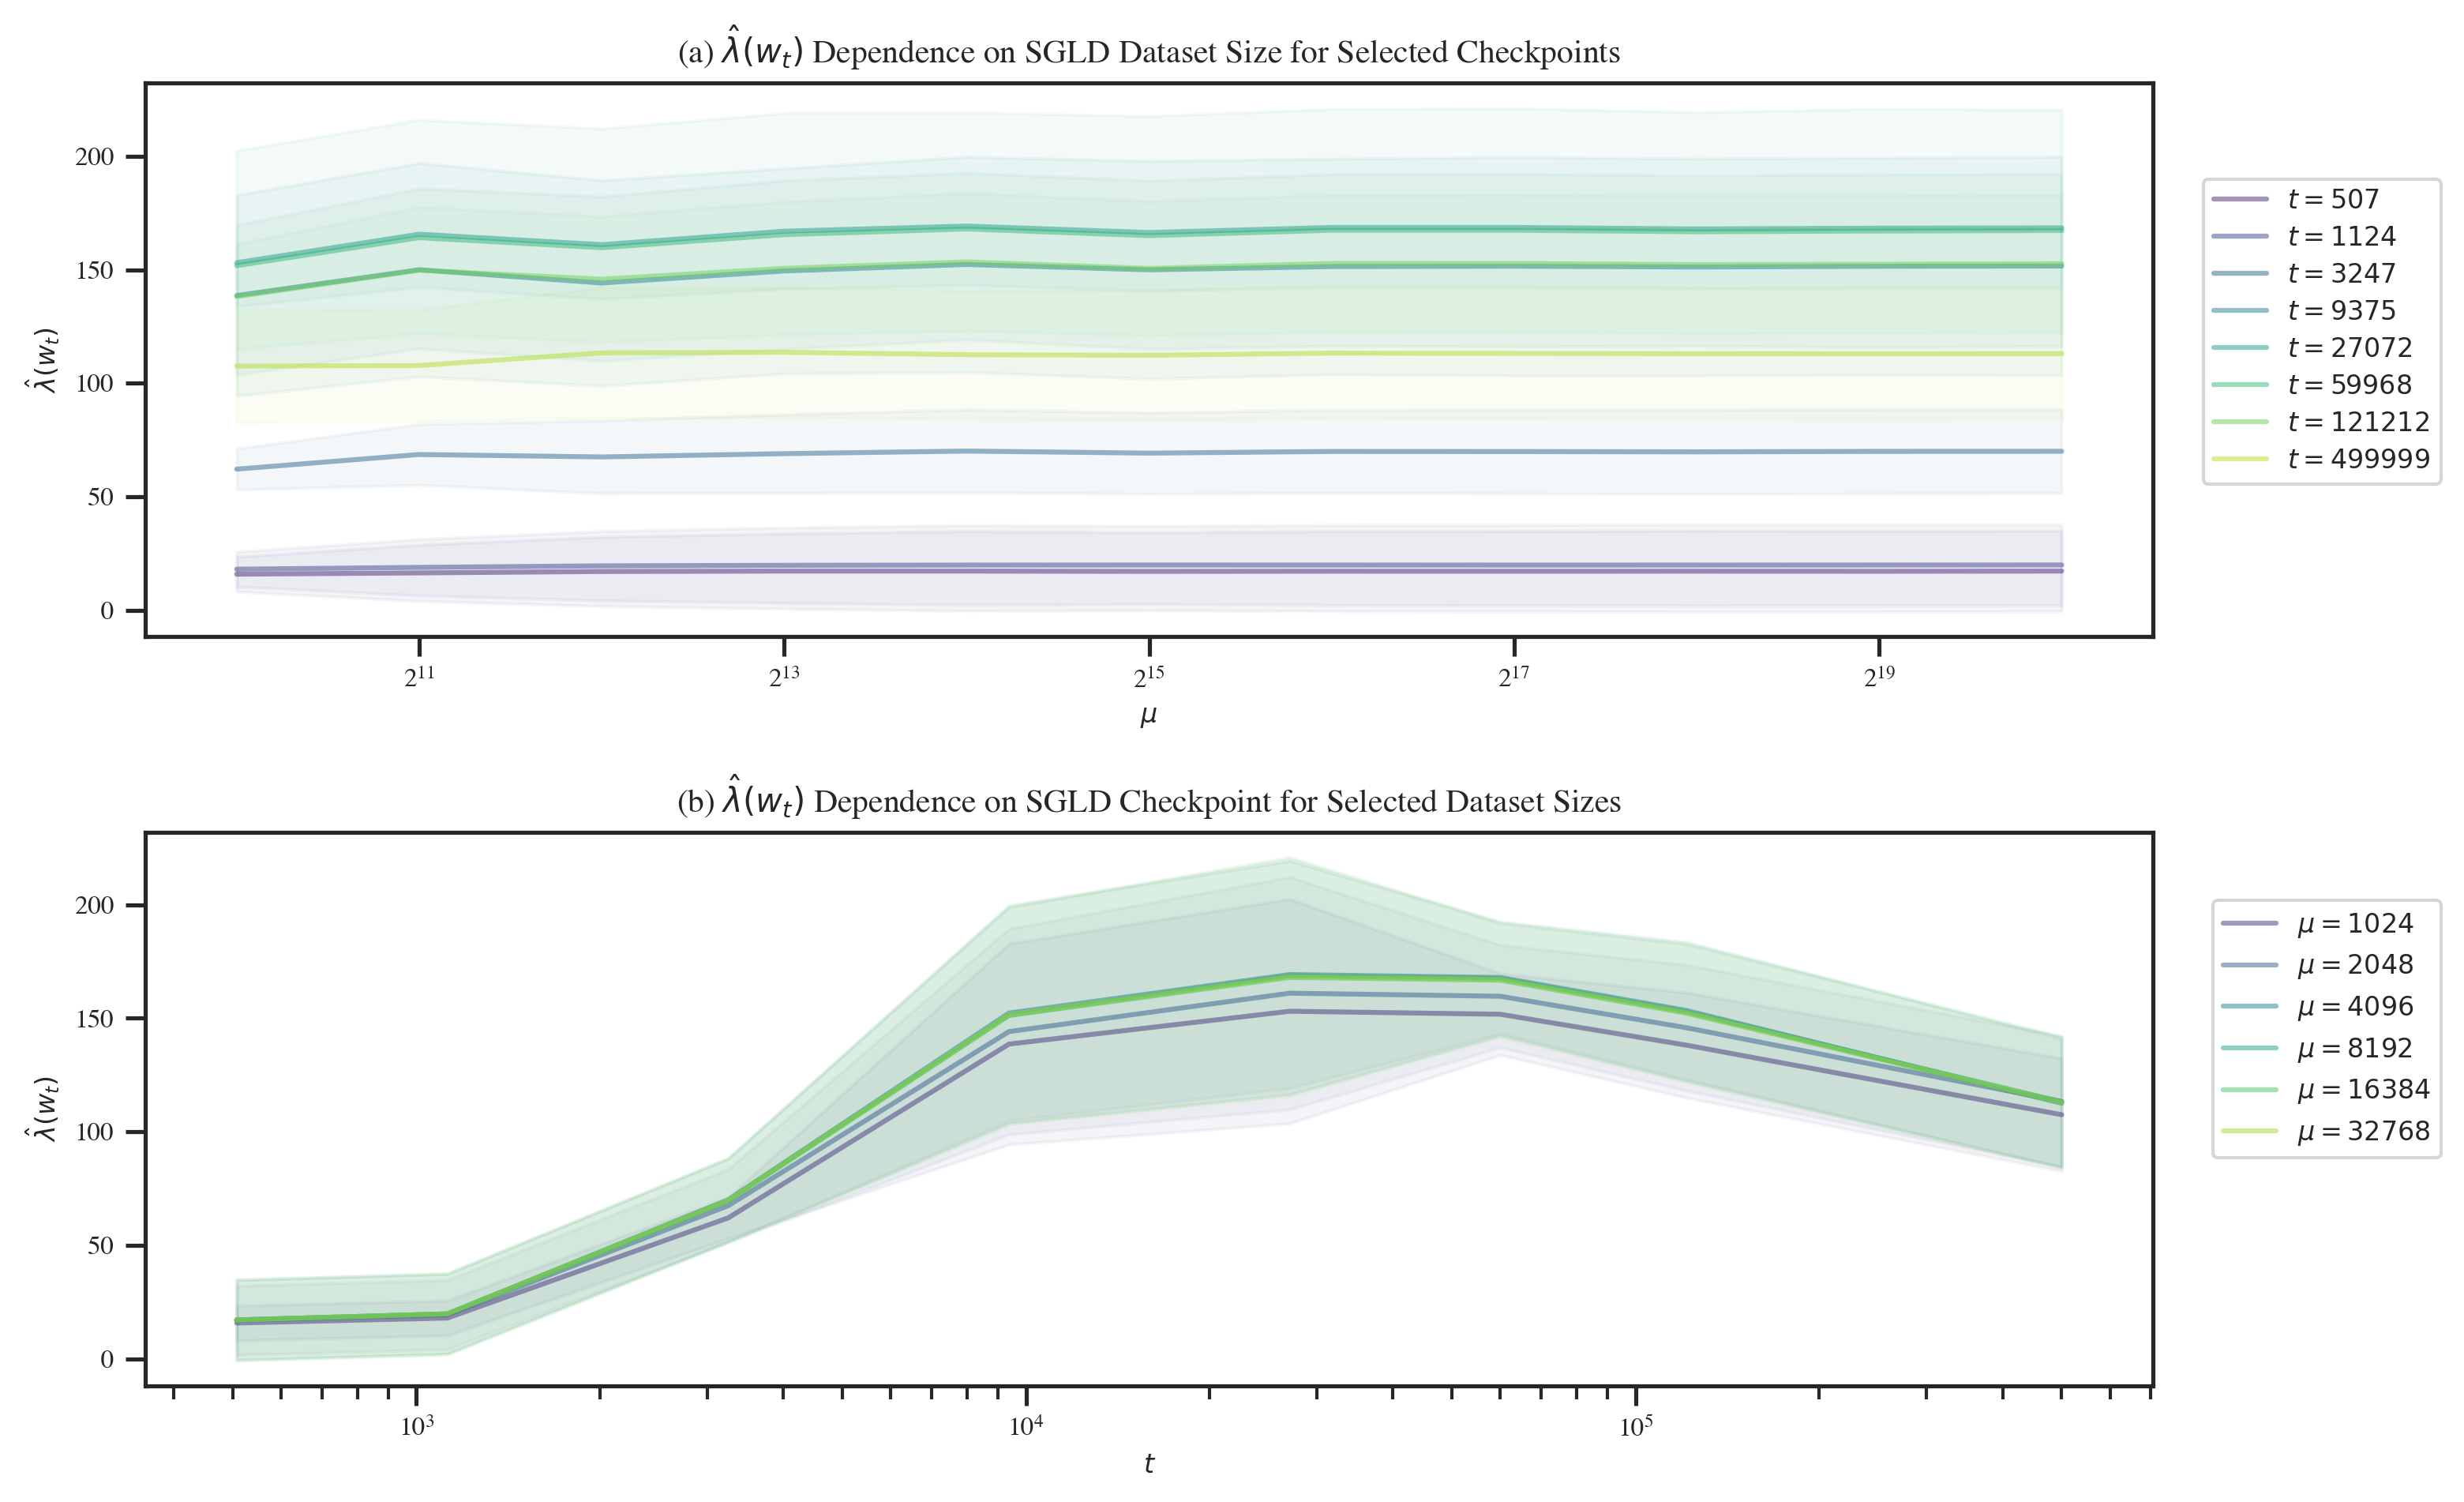

In [80]:
FULL_WIDTH = 6.5

FULL_HEIGHT = FULL_WIDTH / golden_ratio

fig, axes = plt.subplots(2, 1, figsize=(FULL_HEIGHT, FULL_WIDTH))

ax = axes[0]

final_step = eval_dataset_size_df['_step'].max()
final_step_df = eval_dataset_size_df[eval_dataset_size_df['_step'] == final_step-1]

colors = sns.color_palette('viridis', len(eval_dataset_size_df['step'].unique()))
steps = sorted(eval_dataset_size_df['step'].unique())

for i, step in enumerate(steps):
    _df = final_step_df[final_step_df['step'] == step]
    # _df = _df.dropna(subset=['llc/mean/mean'])
    # _df.sort_values(by='sampler_config/eval_dataset_size', inplace=True)
    # sns.lineplot(data=_df, x='sampler_config/eval_dataset_size', y='llc/mean/mean', ax=ax)

    ax.plot(_df['sampler_config/eval_dataset_size'], _df['llc/mean/mean'], color=colors[i], alpha=0.5)
    ax.fill_between(_df['sampler_config/eval_dataset_size'], _df['llc/mean/mean'] - _df['llc/std/mean'], _df['llc/mean/mean'] + _df['llc/std/mean'], alpha=0.05, color=colors[i])

ax.legend(labels=[f"$t={step}$" if i else "_" for step in steps for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .85))        

ax.set_xscale('log', base=2)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\hat\lambda(w_t)$')

ax.set_title(r'(a) $\hat\lambda(w_t)$ Dependence on SGLD Dataset Size for Selected Checkpoints')

ax = axes[1]
colors = sns.color_palette('viridis', len(eval_datasets_sizes) //2 + 1)

for i, size in enumerate(eval_datasets_sizes[::2] + [eval_datasets_sizes[-1]]):
    _df = final_step_df[final_step_df['sampler_config/eval_dataset_size'] == size]
    _df.sort_values(by='step', inplace=True)
    # _df = _df.dropna(subset=['llc/mean/mean'])
    # _df.sort_values(by='step', inplace=True)
    # sns.lineplot(data=_df, x='step', y='llc/mean/mean', ax=ax)

    ax.plot(_df['step'], _df['llc/mean/mean'], color=colors[i], alpha=0.5)
    ax.fill_between(_df['step'], _df['llc/mean/mean'] - _df['llc/std/mean'], _df['llc/mean/mean'] + _df['llc/std/mean'], alpha=0.05, color=colors[i])

ax.legend(labels=[f"$\mu={size}$" if i else "_" for size in eval_datasets_sizes for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .9))        
ax.set_xscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\hat\lambda(w_t)$')
ax.set_title(r'(b) $\hat\lambda(w_t)$ Dependence on SGLD Checkpoint for Selected Dataset Sizes')

plt.tight_layout()

# ax.plot(_df[''])


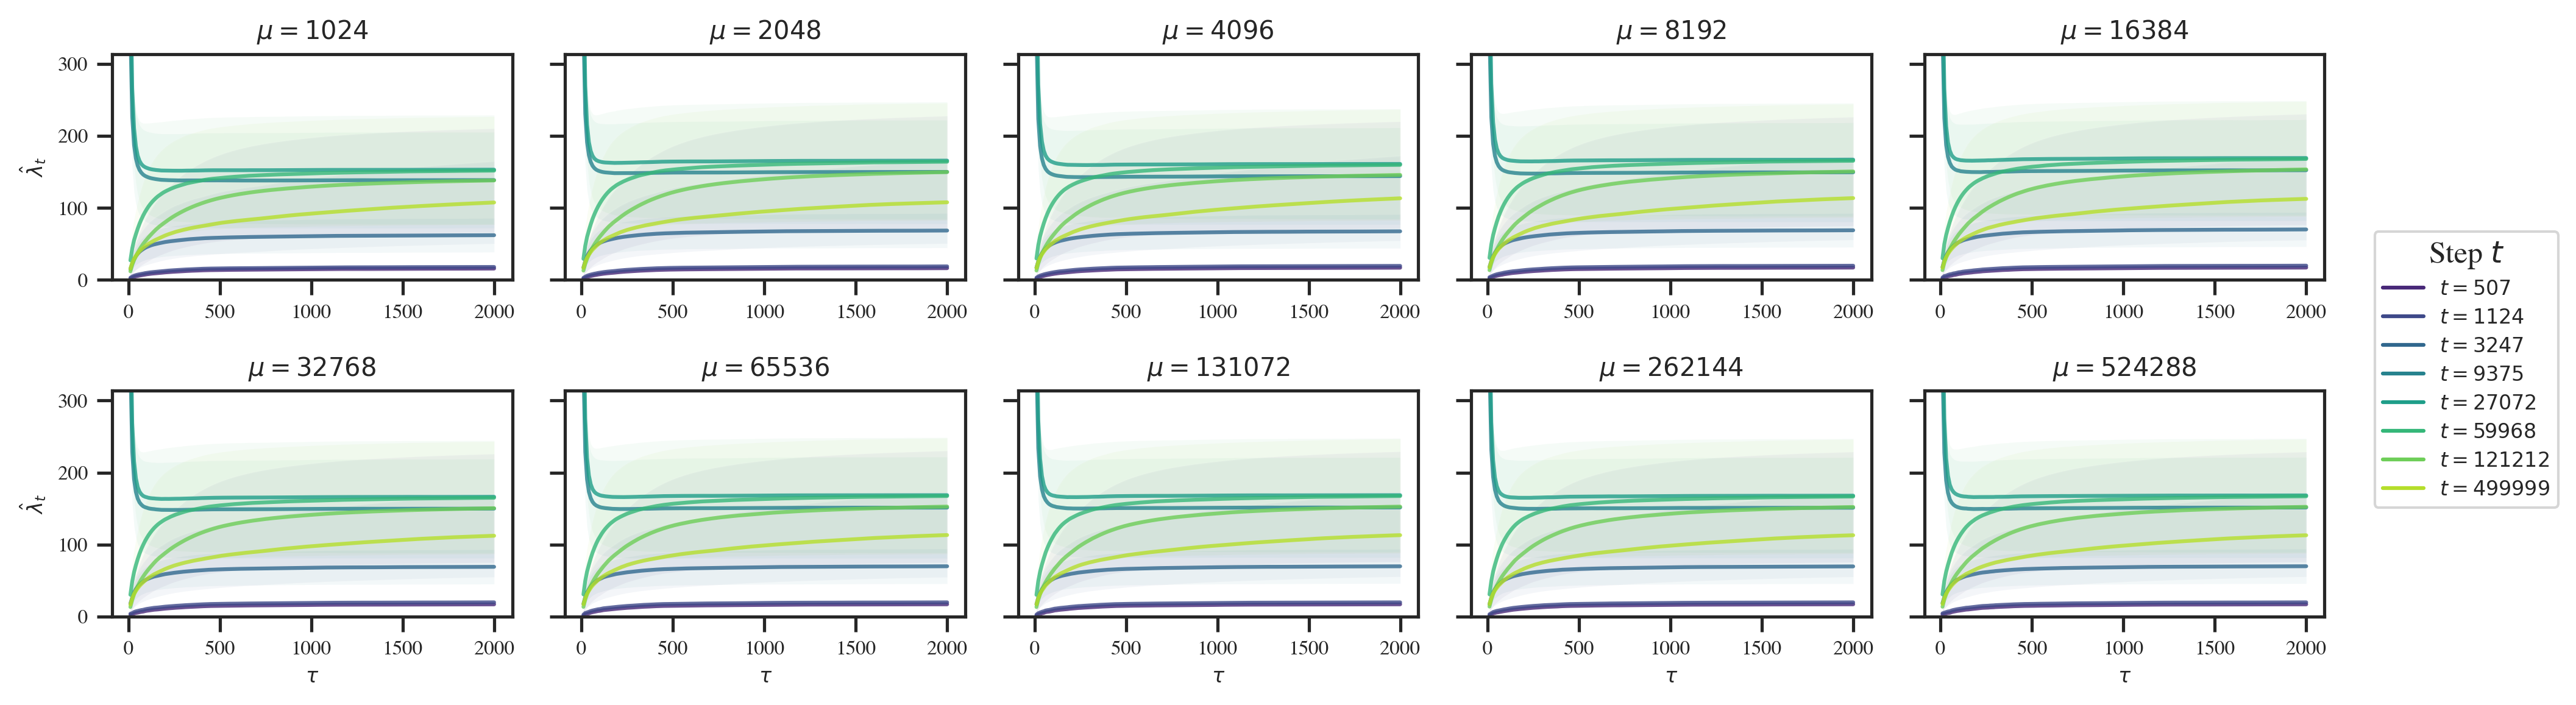

In [172]:
from icl.figures.colors import PRIMARY, SECONDARY

fig, axes = plt.subplots(2, len(eval_datasets_sizes) // 2, figsize=(2 * FULL_WIDTH, FULL_HEIGHT))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

LOSS_MEAN, LOSS_STD = 'llc/mean/mean', 'llc/mean/std'
max_loss_over_time = eval_dataset_size_df[LOSS_MEAN].max() 
max_loss_at_end = eval_dataset_size_df[LOSS_MEAN].max() 

colors = sns.color_palette('viridis', len(steps))

for i, (ax, eval_batch_size) in enumerate(zip(axes.flatten(), eval_datasets_sizes)):
    _df = eval_dataset_size_df.loc[eval_dataset_size_df['sampler_config/eval_dataset_size'] == eval_batch_size].sort_values(by=['step', '_step'])

    for j, step in enumerate(steps):
        sns.lineplot(data=_df.loc[_df.step == step], x="_step", y=LOSS_MEAN, color=colors[j], ax=ax, alpha=0.8)

    for step, color in zip(steps, colors):
        _step_df = _df.loc[_df['step'] == step]
        # for chain in range(8):
        #     ax.plot(_step_df['_step'], _step_df[f"llc/mean/{chain}"], alpha=0.5, color=color, linewidth=0.5)
        ax.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.05)  
        # ax.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.1)
        
    ax.set_title(f"$\mu = {eval_batch_size}$")
    if i < len(eval_datasets_sizes) // 2:
        ax.set_xlabel('')
    else:
        ax.set_xlabel(r"$\tau$")

    # ax.legend().remove()
    ax.set_ylim(0, max_loss_over_time * .7)
    # ax.set_yscale('log')

    # _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

    # ax2.plot(_final_df['task_config/num_tasks'], _final_df[LOSS_MEAN], alpha=1)
    # ax2.fill_between(_final_df["task_config/num_tasks"], _final_df[LOSS_MEAN] - _final_df[LOSS_STD], _final_df[LOSS_MEAN] + _final_df[LOSS_STD], alpha=0.5)

    # ax2.set_title(fr"$\mu = {eval_batch_size}, t=500k$")
    # ax2.set_xlabel(r"$M$")
    # ax2.set_xscale('log', base=2)

    # ax2.set_ylim(0, max_loss_at_end * 1.25)

    if i != 0 and i != len(eval_datasets_sizes) // 2:
        ax.set_yticklabels([])
        ax.set_ylabel("")
        # ax2.set_yticklabels([])
        # ax2.set_ylabel("")

axes[0, 0].set_ylabel(r"$\hat\lambda_t$")
axes[1, 0].set_ylabel(r"$\hat\lambda_t$")


# Titles above rows (shift far to the right)
# axes[0, 0].set_title(r"(a) $\hat\lambda_t$ Dependence on $\mu$ for SGLD")
# axes[1, 0].set_title(r"(b) $\hat\lambda_t$ Dependence on $\mu$ for SGLD-MC")
plt.tight_layout()

ax= axes[-1, -1]       
handles = [plt.Line2D([0, 0], [0, 0], color=colors[j]) for j in range(len(steps))]
labels = [f"$t={step}$" for step in steps]
ax.legend(handles=handles, labels=labels, title=r"Step $t$", loc='upper left', bbox_to_anchor=(1.1,1.75))

fig.set_facecolor('white')
fig.savefig(FIGURES / "llc-fixed-dataset.pdf", bbox_inches='tight')

<Axes: xlabel='sampler_config/eval_dataset_size', ylabel='step'>

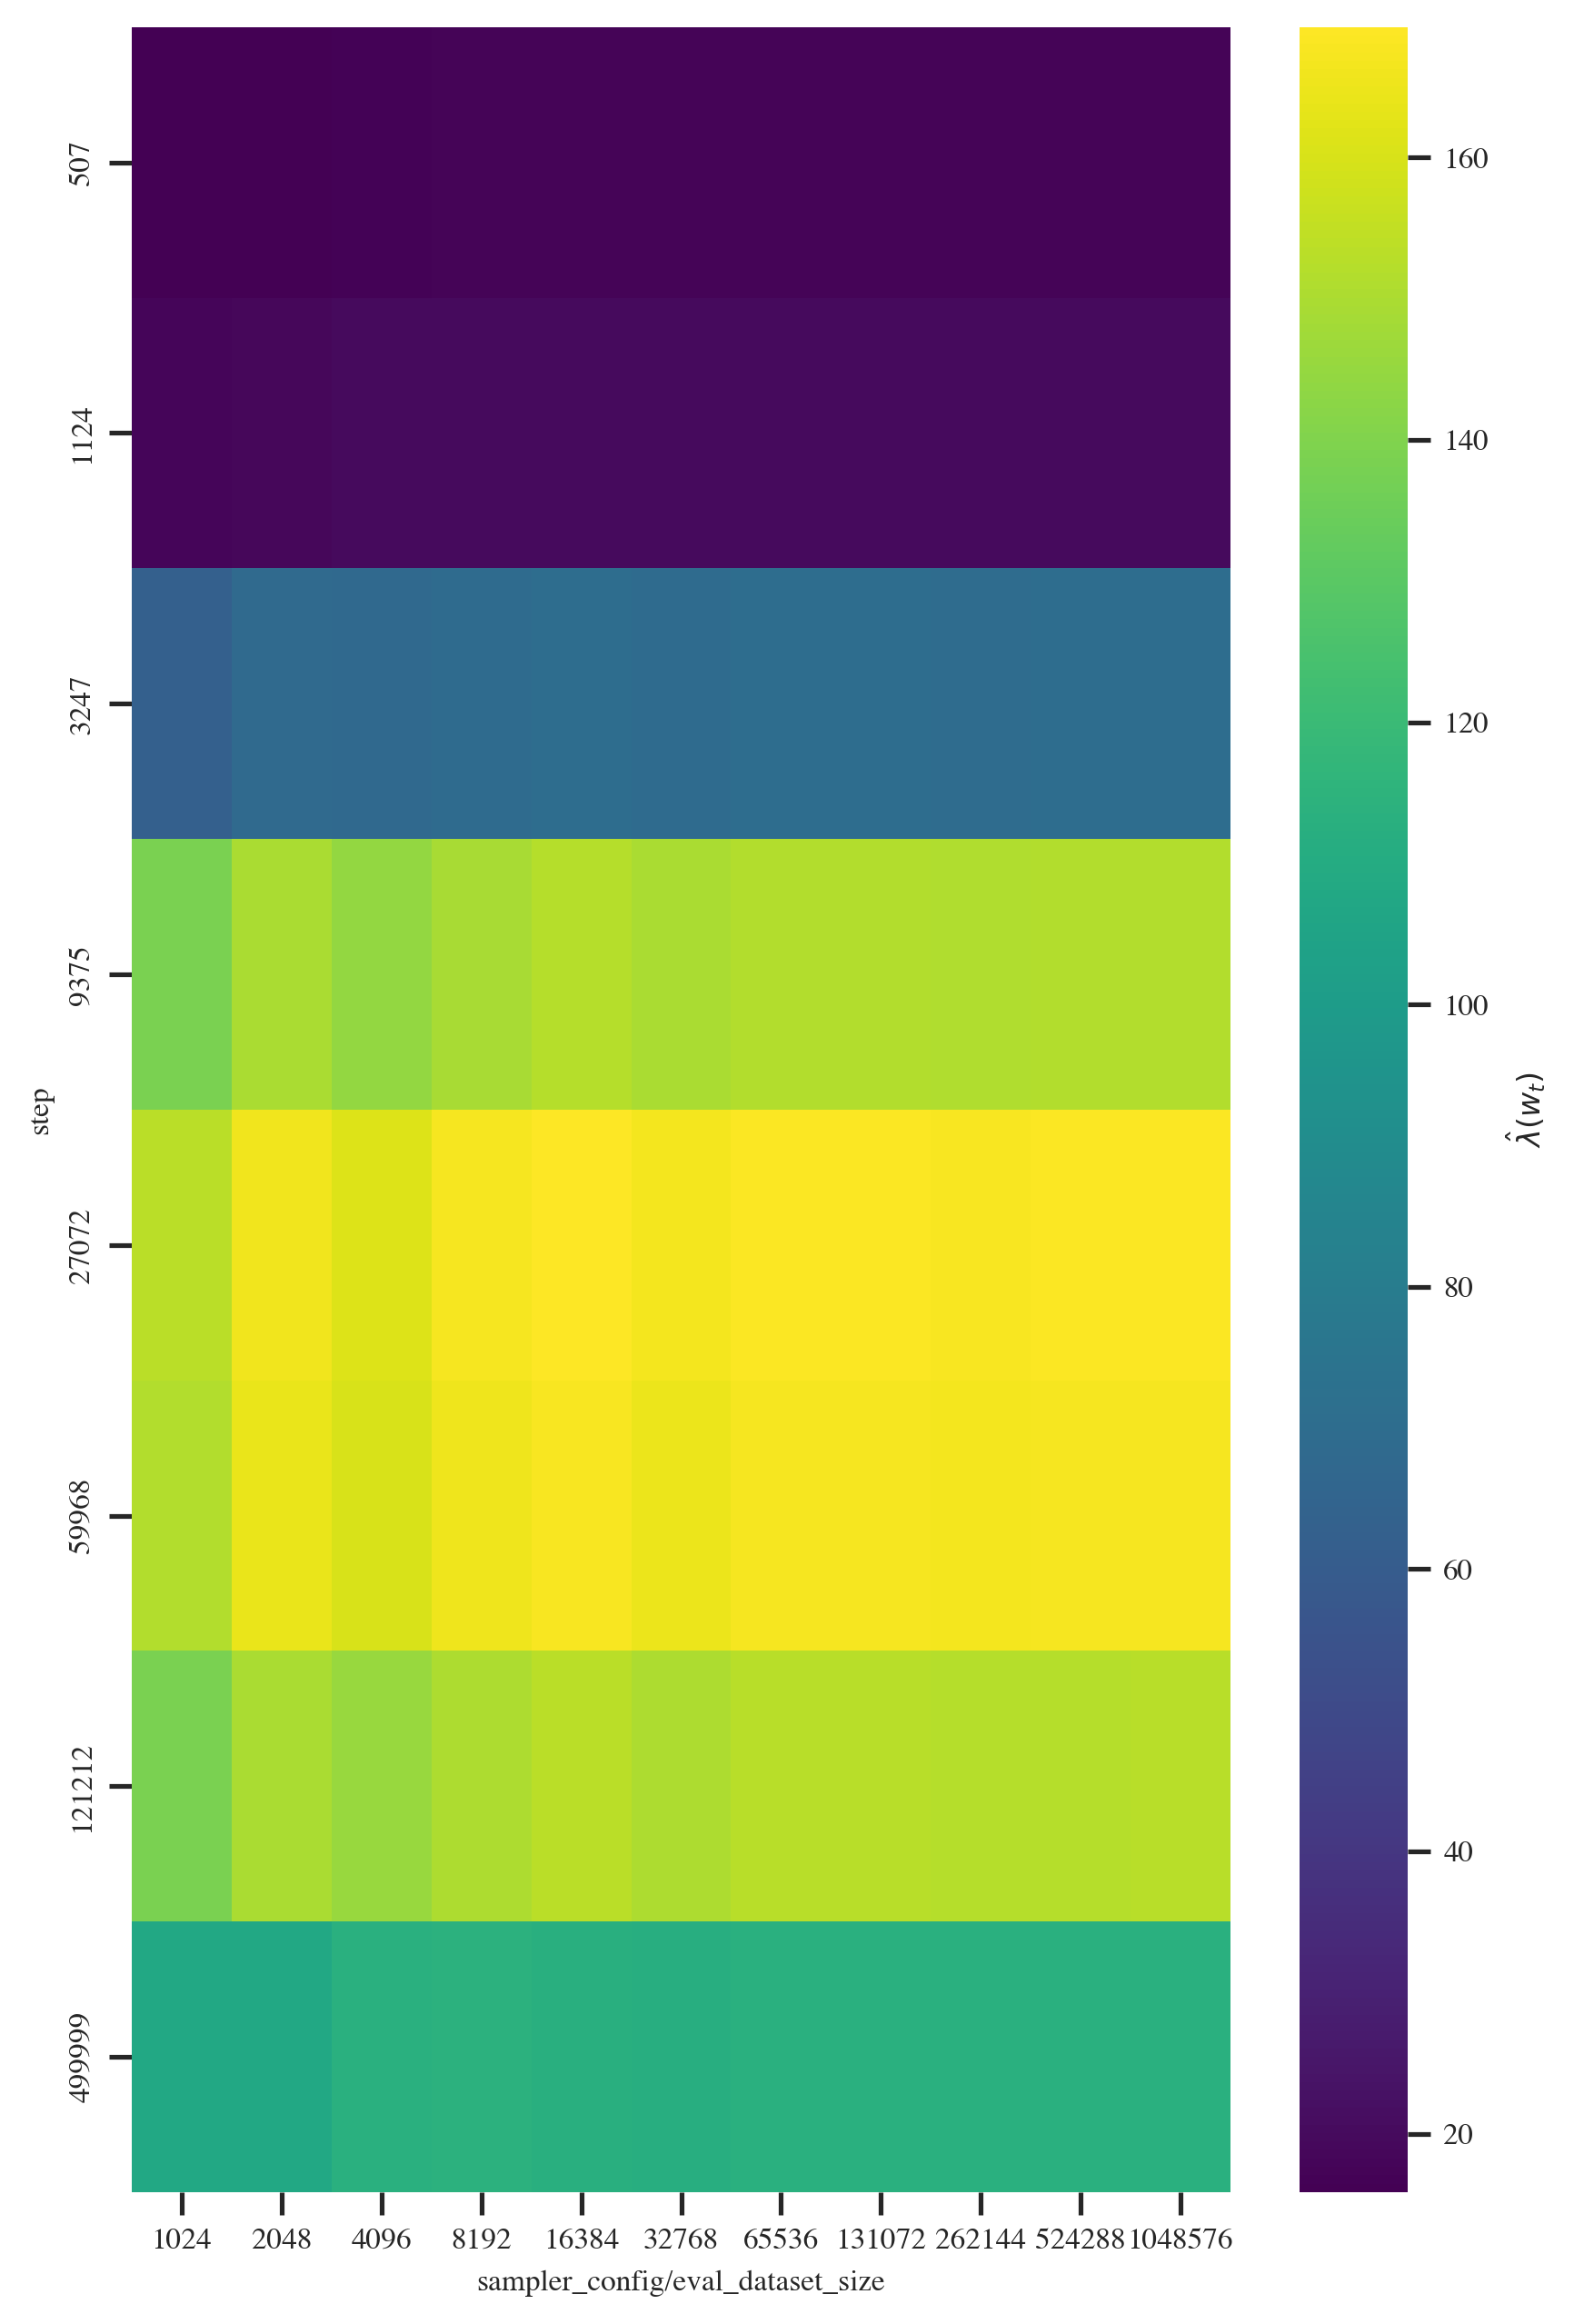

In [83]:
# plot heatmap of llc/mean/mean vs. step and eval_dataset_size

# Reset index
final_step_df.reset_index(inplace=True)

# Create pivot table
eval_dataset_size_pivot = final_step_df.pivot(index='step', columns='sampler_config/eval_dataset_size', values='llc/mean/mean')

# Create heatmap
fig, ax = plt.subplots(figsize=(FULL_WIDTH, FULL_HEIGHT))

sns.heatmap(eval_dataset_size_pivot, ax=ax, cmap='viridis', cbar_kws={'label': r'$\hat\lambda(w_t)$'})


<ipython-input-93-ea7490f18b30>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values(by='step', inplace=True)
<ipython-input-93-ea7490f18b30>:18: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb0c87e4c0> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[f"$\mu={size}$" if i else "_" for size in eval_datasets_sizes for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.25, 1.1))
<ipython-input-93-ea7490f18b30>:18: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb0c87e9a0> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[f"$\mu={size}$" if i else "_" for size in eval_datasets_sizes for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.25, 1.1))
<ipython-input-93-ea7490f1

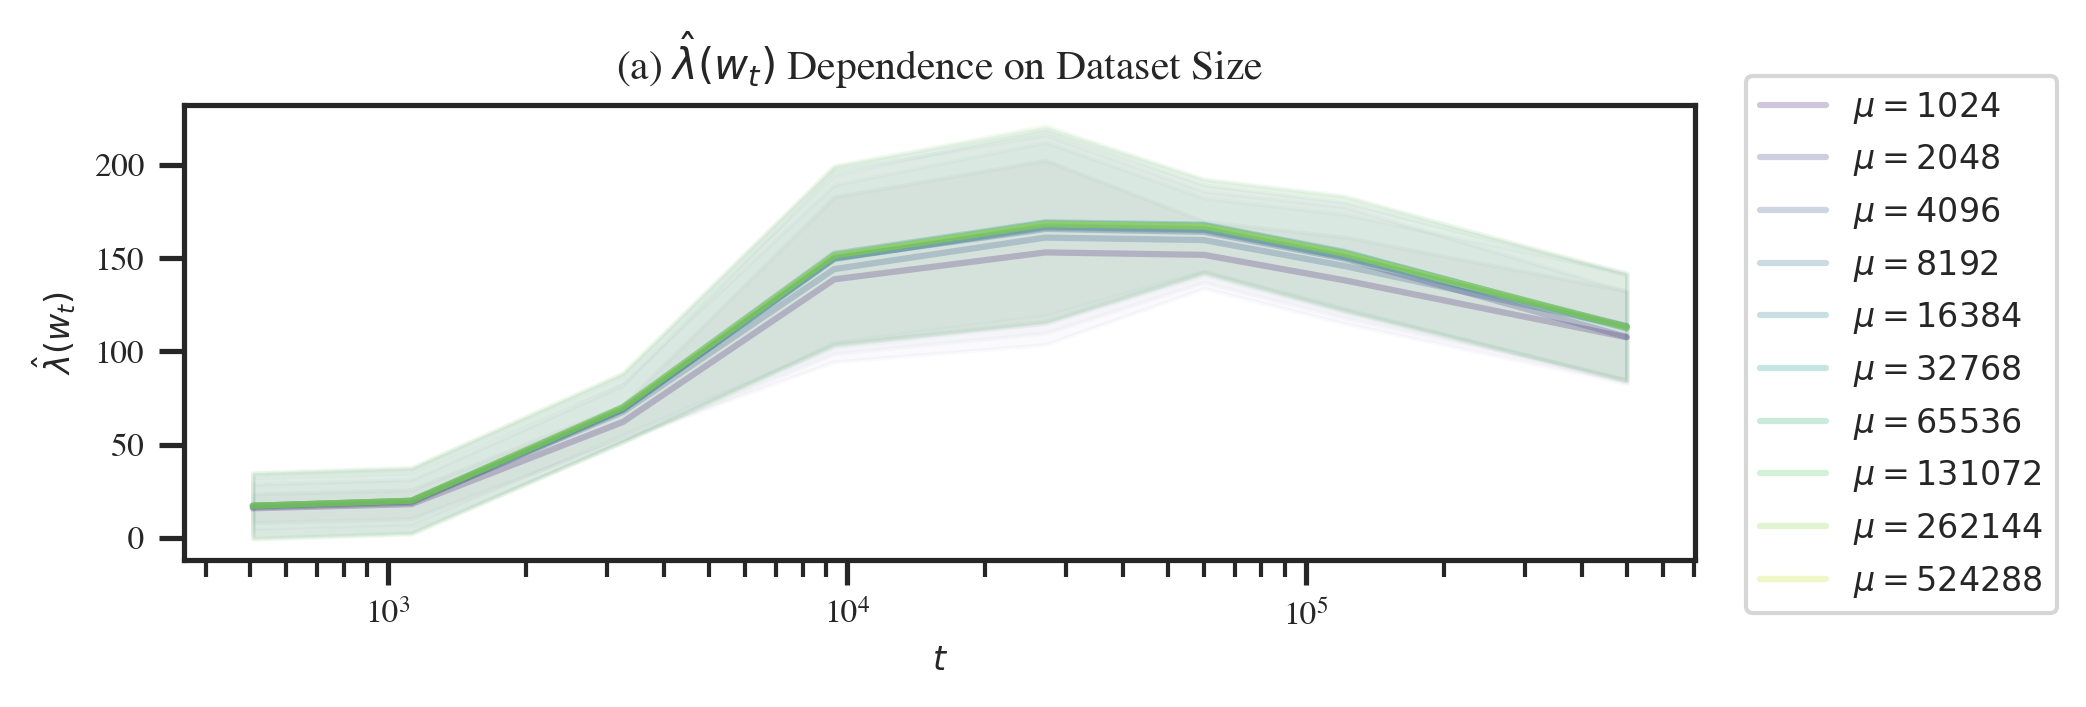

In [93]:
FULL_WIDTH = 6.5
FULL_HEIGHT = FULL_WIDTH * golden_ratio

fig, ax = plt.subplots(1, 1, figsize=(FULL_WIDTH, FULL_HEIGHT / 2))

colors = sns.color_palette('viridis', len(eval_datasets_sizes))

for i, size in enumerate(eval_datasets_sizes):
    _df = final_step_df[final_step_df['sampler_config/eval_dataset_size'] == size]
    _df.sort_values(by='step', inplace=True)
    # _df = _df.dropna(subset=['llc/mean/mean'])
    # _df.sort_values(by='step', inplace=True)
    # sns.lineplot(data=_df, x='step', y='llc/mean/mean', ax=ax)

    ax.plot(_df['step'], _df['llc/mean/mean'], color=colors[i], alpha=0.25)
    ax.fill_between(_df['step'], _df['llc/mean/mean'] - _df['llc/std/mean'], _df['llc/mean/mean'] + _df['llc/std/mean'], alpha=0.025, color=colors[i])

ax.legend(labels=[f"$\mu={size}$" if i else "_" for size in eval_datasets_sizes for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.25, 1.1))        
ax.set_xscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\hat\lambda(w_t)$')
ax.set_title(r'(a) $\hat\lambda(w_t)$ Dependence on Dataset Size')


# ax.plot(_df[''])
fig.savefig(FIGURES / "llc-vs-dataset-size.pdf", bbox_inches='tight')

<ipython-input-69-19e90845a802>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.sort_values(by='step', inplace=True)
<ipython-input-69-19e90845a802>:13: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb523c9070> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[f"$\mu={size}$" if i else "_" for size in eval_datasets_sizes for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .9))


Text(0.5, 1.0, '(b) $\\hat\\lambda(w_t)$ Dependence on Dataset Size')

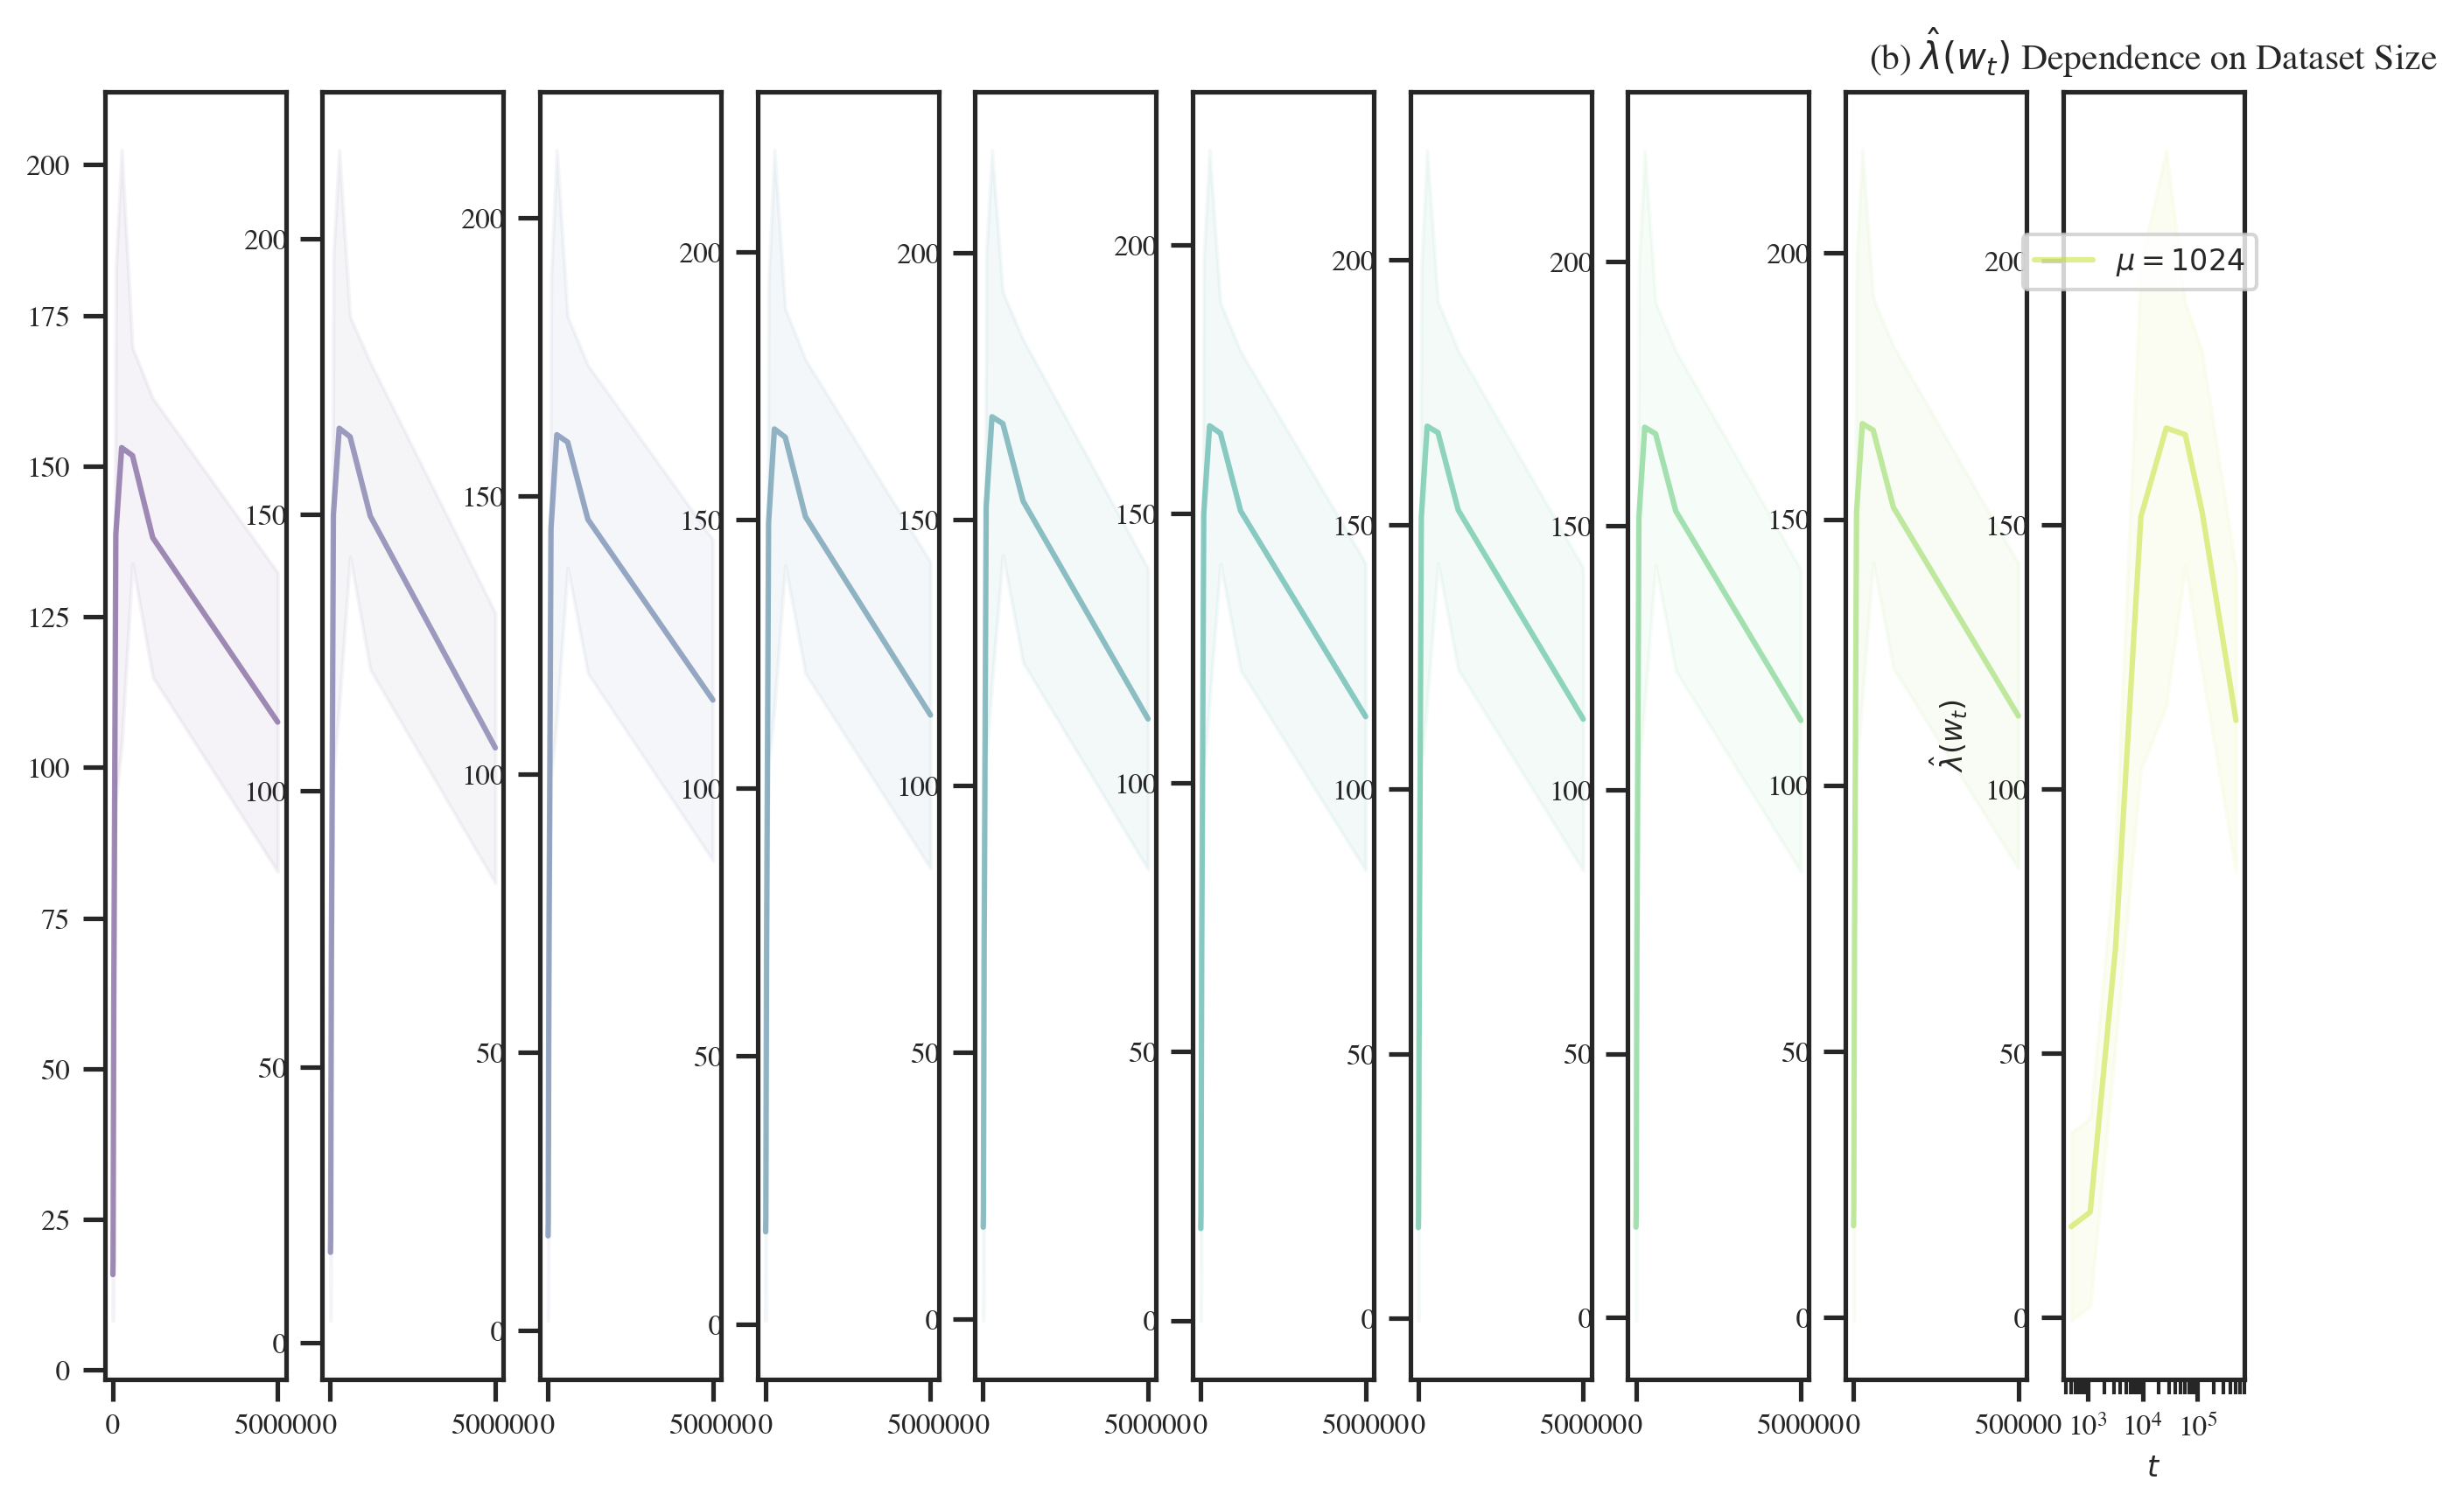

In [69]:
fig, axes = plt.subplots(1, len(eval_datasets_sizes), figsize=(FULL_HEIGHT, FULL_WIDTH))

for i, (ax, size) in enumerate(zip(axes.flatten(), eval_datasets_sizes)):
    _df = final_step_df[final_step_df['sampler_config/eval_dataset_size'] == size]
    _df.sort_values(by='step', inplace=True)
    # _df = _df.dropna(subset=['llc/mean/mean'])
    # _df.sort_values(by='step', inplace=True)
    # sns.lineplot(data=_df, x='step', y='llc/mean/mean', ax=ax)

    ax.plot(_df['step'], _df['llc/mean/mean'], color=colors[i], alpha=0.5)
    ax.fill_between(_df['step'], _df['llc/mean/mean'] - _df['llc/std/mean'], _df['llc/mean/mean'] + _df['llc/std/mean'], alpha=0.05, color=colors[i])

ax.legend(labels=[f"$\mu={size}$" if i else "_" for size in eval_datasets_sizes for i in [1, 0]], loc='upper right', bbox_to_anchor=(1.15, .9))        
ax.set_xscale('log')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\hat\lambda(w_t)$')
ax.set_title(r'(b) $\hat\lambda(w_t)$ Dependence on Dataset Size')



<ipython-input-23-c6851c996494>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])


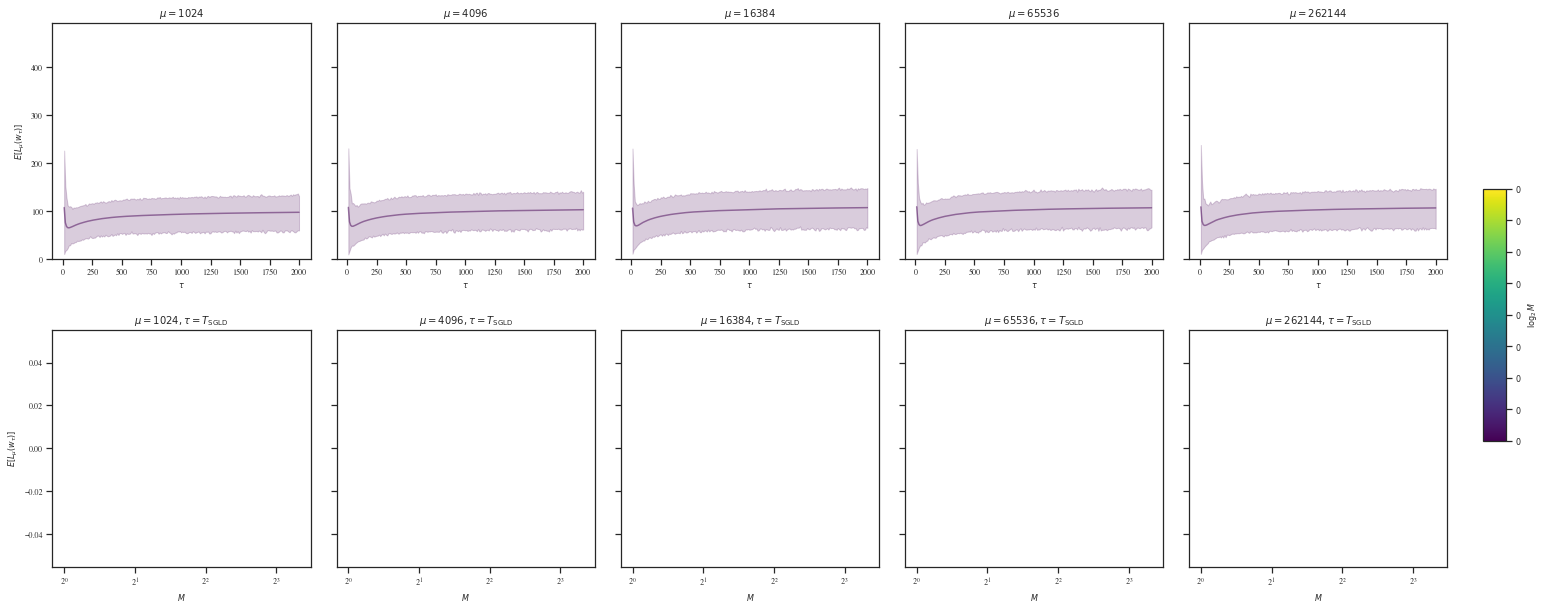

In [23]:
fig, axes = plt.subplots(2, len(eval_datasets_sizes), figsize=(5*len(eval_datasets_sizes), 10))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

max_loss_over_time = eval_dataset_size_df['llc/mean/mean'].max()
max_loss_at_end = eval_dataset_size_df[eval_dataset_size_df['_step'] == eval_dataset_size_df['_step'].max()]['llc/mean/mean'].max()

for i, (ax1, ax2, eval_dataset_size) in enumerate(zip(axes[0, :], axes[1, :], eval_datasets_sizes)):
    _df = eval_dataset_size_df.loc[eval_dataset_size_df['sampler_config/eval_dataset_size'] == eval_dataset_size]

    sns.lineplot(data=_df, x="_step", y="llc/mean/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)

    ax1.set_title(f"$\mu = {eval_dataset_size}$")
    ax1.set_xlabel(r"$\tau$")
    ax1.legend().remove()
    ax1.set_ylim(0, max_loss_over_time * 1.1)

    _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

    ax2.plot(_final_df['task_config/num_tasks'], _final_df['llc/mean/mean'], alpha=1)
    ax2.fill_between(_final_df["task_config/num_tasks"], _final_df["llc/mean/mean"] - _final_df["llc/mean/std"], _final_df["llc/mean/mean"] + _final_df["llc/mean/std"], alpha=0.5)

    ax2.set_title(fr"$\mu = {eval_dataset_size}, \tau = T_\mathrm{{SGLD}}$")
    ax2.set_xlabel(r"$M$")
    ax2.set_xscale('log', base=2)

    # ax2.set_ylim(0, max_loss_at_end * 1.25)

    if i > 0:
        ax1.set_yticklabels([])
        ax1.set_ylabel("")
        ax2.set_yticklabels([])
        ax2.set_ylabel("")

axes[0, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")
axes[1, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")

# Add a colorbar for the hues on the left side of the top row
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=_df["log_num_tasks"].min(), vmax=_df["log_num_tasks"].max()))
sm._A = []  # Fake up the array of the scalar mappable
cb_ax = fig.add_axes([0.92, 0.3, 0.0125, 0.35])  # Adjust these values as needed for positioning and size
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])
cbar.set_label('$\log_2 M$')  # Update this label as needed

fig.set_facecolor('white')

### Fixed Evaluation Datasets


In [94]:
FORCE_REEVAL = True

EVAL_FIXED_BATCH_SWEEP_NAME = "fixed-batch"
EVAL_FIXED_BATCH_SWEEP_ID = "z54jluit"

if not os.path.exists(ANALYSIS / EVAL_FIXED_BATCH_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_fixed_batch_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_FIXED_BATCH_SWEEP_ID}")
        eval_fixed_batch_runs = list(filter_objs([r for r in eval_fixed_batch_sweep.runs], config=filters))
        eval_fixed_batch_df = wandb_runs_to_df(eval_fixed_batch_runs)
    
    eval_fixed_batch_df.to_pickle(ANALYSIS / EVAL_FIXED_BATCH_SWEEP_NAME)

else:
    eval_fixed_batch_df = pd.read_pickle(ANALYSIS / EVAL_FIXED_BATCH_SWEEP_NAME)

# columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

# for col in columns_to_convert:
#     eval_fixed_batch_df[col] = pd.to_numeric(eval_fixed_batch_df[col], errors='coerce')

    
eval_fixed_batch_df.reset_index(inplace=True)
eval_fixed_batch_df['log_num_tasks'] = np.log2(eval_fixed_batch_df['task_config/num_tasks'])
eval_fixed_batch_df = eval_fixed_batch_df.loc[eval_fixed_batch_df['task_config/layer_norm'] == True]
eval_fixed_batch_df

Converting runs to dfs: 100%|██████████| 96/96 [00:45<00:00,  2.13it/s]
<ipython-input-94-cf2590ad617d>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_fixed_batch_df.reset_index(inplace=True)
<ipython-input-94-cf2590ad617d>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_fixed_batch_df['log_num_tasks'] = np.log2(eval_fixed_batch_df['task_config/num_tasks'])


index     wbic/std/3  loss/std/1  llc/mean/7    _timestamp  \
0          0  147281.671875    0.079144   24.008751  1.705662e+09   
1          1  224830.390625    0.094404   39.213093  1.705662e+09   
2          2  255919.093750    0.116551   49.980030  1.705662e+09   
3          3  290665.437500    0.134886   58.853317  1.705662e+09   
4          4  318259.781250    0.150723   66.393440  1.705662e+09   
...      ...            ...         ...         ...           ...   
19291    196  528328.437500    0.506999   21.496901  1.705382e+09   
19292    197  528330.437500    0.506969   21.511841  1.705382e+09   
19293    198  528513.000000    0.506748   21.522110  1.705382e+09   
19294    199  528725.250000    0.506869   21.552563  1.705382e+09   
19295    200            NaN         NaN         NaN  1.705382e+09   

                                              loss_trace  llc/std/std  \
0                                                   None     2.459084   
1                                                   None     5.223244   
2                                                   None     6.186894   
3                                                   None     6.962203   
4                                                   None     7.510105   
...                                                  ...          ...   
19291                                                NaN     0.187613   
19292                                                NaN     0.189423   
19293                                                NaN     0.195131   
19294  {'_type': 'image-file', 'format': 'png', 'heig...     0.191653   
19295                                                NaN          NaN   

          wbic/std/2  llc/mean/5  loss/std/std  ...  \
0      107256.359375   25.371096      0.036886  ...   
1      142689.171875   40.726692      0.078349  ...   
2      174510.156250   50.262901      0.092803  ...   
3      201385.937500   58.477581      0.104433  ...   
4      239504.390625   65.425331      0.112652  ...   
...              ...         ...           ...  ...   
19291  535361.062500   19.190121      0.002814  ...   
19292  535314.062500   19.198990      0.002841  ...   
19293  535069.125000   19.197338      0.002927  ...   
19294  535098.562500   19.208878      0.002875  ...   
19295            NaN         NaN           NaN  ...   

       sampler_config/gradient_scale  sampler_config/eval_batch_size  \
0                               0.01                            None   
1                               0.01                            None   
2                               0.01                            None   
3                               0.01                            None   
4                               0.01                            None   
...                              ...                             ...   
19291                           0.01                            None   
19292                           0.01                            None   
19293                           0.01                            None   
19294                           0.01                            None   
19295                           0.01                            None   

       sampler_config/grad_batch_size  sampler_config/sampling_method  \
0                                8192                            sgld   
1                                8192                            sgld   
2                                8192                            sgld   
3                                8192                            sgld   
4                                8192                            sgld   
...                               ...                             ...   
19291                             256                            sgld   
19292                             256                            sgld   
19293                             256                            sgld   
19294                             256        

In [38]:
eval_fixed_batch_df.columns.values

array(['index', 'llc/mean/1', 'wbic/mean/0', 'wbic/mean/std', 'llc/std/4',
       'llc/std/1', 'wbic/mean/4', 'wbic/mean/mean', 'wbic/std/std',
       'loss/std/2', '_runtime', 'wbic/mean/3', 'wbic/std/6',
       'llc/mean/5', 'llc/mean/std', 'loss/std/3', 'weights_trace',
       'llc/mean/6', 'llc/std/mean', 'loss/mean/6', 'loss/mean/4',
       'llc/mean/3', 'wbic/std/mean', 'wbic/mean/1', 'llc/std/6',
       'wbic/std/4', 'loss/std/7', 'wbic/std/0', 'wbic/std/3', '_step',
       'loss_trace', 'llc/mean/4', 'loss/mean/0', 'llc/std/5',
       'loss/std/6', 'llc/mean/0', 'llc/mean/mean', 'wbic/std/1',
       'loss/mean/7', 'loss/mean/std', 'wbic/std/7', 'wbic/mean/6',
       'wbic/mean/7', 'wbic/std/5', 'wbic/mean/5', 'loss/std/1',
       '_timestamp', 'llc/std/std', 'llc/mean/2', 'llc/std/3',
       'llc/std/2', 'loss/mean/2', 'loss/mean/3', 'loss/mean/5',
       'loss/std/std', 'llc/mean/7', 'loss/std/4', 'loss/std/5',
       'llc/std/7', 'llc/std/0', 'wbic/std/2', 'wbic/mean/2',
    

In [95]:
validation_batch_sizes = np.array([2 ** i for i in range(10, 14)])
validation_batch_sizes

array([1024, 2048, 4096, 8192])

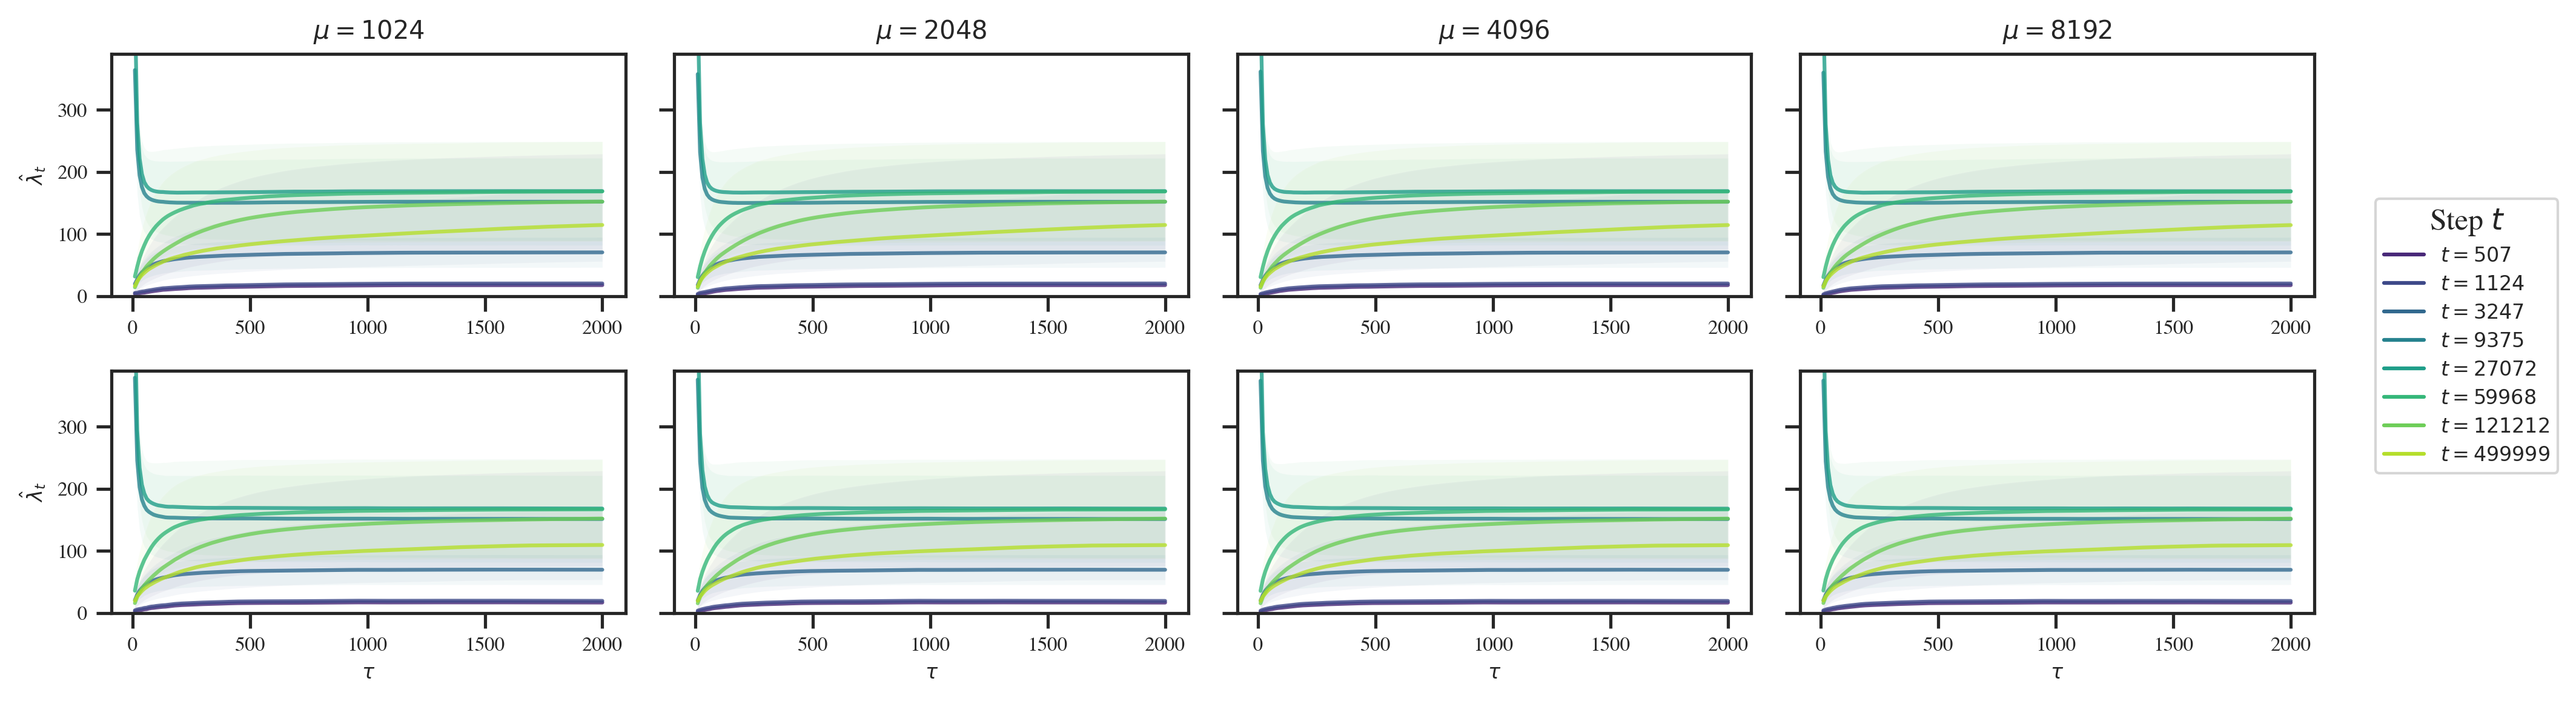

In [158]:
from icl.figures.colors import PRIMARY, SECONDARY

fig, axes = plt.subplots(2, len(validation_batch_sizes), figsize=(2 * FULL_WIDTH, FULL_HEIGHT))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

LOSS_MEAN, LOSS_STD = 'llc/mean/mean', 'llc/mean/std'
max_loss_over_time = eval_fixed_batch_df[LOSS_MEAN].max() 
max_loss_at_end = eval_fixed_batch_df[eval_fixed_batch_df['_step'] == eval_fixed_batch_df['_step'].max()][LOSS_MEAN].max() 

colors = sns.color_palette('viridis', len(steps))

for axes_row, variant in zip(axes, reversed(eval_fixed_batch_df['sampler_config/eval_method'].unique())):
    row_df = eval_fixed_batch_df.loc[eval_fixed_batch_df['sampler_config/eval_method'] == variant]
    for i, (ax, eval_batch_size) in enumerate(zip(axes_row, validation_batch_sizes)):
        _df = row_df.loc[row_df['sampler_config/grad_batch_size'] == eval_batch_size].sort_values(by=['step', '_step'])

        for j, step in enumerate(steps):
            sns.lineplot(data=_df.loc[_df.step == step], x="_step", y=LOSS_MEAN, color=colors[j], ax=ax, alpha=0.8)

        for step, color in zip(steps, colors):
            _step_df = _df.loc[_df['step'] == step]
            # for chain in range(8):
            #     ax.plot(_step_df['_step'], _step_df[f"llc/mean/{chain}"], alpha=0.5, color=color, linewidth=0.5)
            ax.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.05)  
            # ax.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.1)
            
        if variant == "grad-minibatch":
            ax.set_title(f"$\mu = {eval_batch_size}$")
            ax.set_xlabel('')
        else:
            ax.set_xlabel(r"$\tau$")

        # ax.legend().remove()
        ax.set_ylim(0, max_loss_over_time * .8)
        # ax.set_yscale('log')

        # _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

        # ax2.plot(_final_df['task_config/num_tasks'], _final_df[LOSS_MEAN], alpha=1)
        # ax2.fill_between(_final_df["task_config/num_tasks"], _final_df[LOSS_MEAN] - _final_df[LOSS_STD], _final_df[LOSS_MEAN] + _final_df[LOSS_STD], alpha=0.5)

        # ax2.set_title(fr"$\mu = {eval_batch_size}, t=500k$")
        # ax2.set_xlabel(r"$M$")
        # ax2.set_xscale('log', base=2)

        # ax2.set_ylim(0, max_loss_at_end * 1.25)

        if i > 0:
            ax.set_yticklabels([])
            ax.set_ylabel("")
            # ax2.set_yticklabels([])
            # ax2.set_ylabel("")

axes[0, 0].set_ylabel(r"$\hat\lambda_t$")
axes[1, 0].set_ylabel(r"$\hat\lambda_t$")

# Titles above rows (shift far to the right)
# axes[0, 0].set_title(r"(a) $\hat\lambda_t$ Dependence on $\mu$ for SGLD")
# axes[1, 0].set_title(r"(b) $\hat\lambda_t$ Dependence on $\mu$ for SGLD-MC")
plt.tight_layout()

ax= axes[-1, -1]       
handles = [plt.Line2D([0, 0], [0, 0], color=colors[j]) for j in range(len(steps))]
labels = [f"$t={step}$" for step in steps]
ax.legend(handles=handles, labels=labels, title=r"Step $t$", loc='upper left', bbox_to_anchor=(1.1,1.75))

fig.set_facecolor('white')
fig.savefig(FIGURES / "llc-vs-batch-size.pdf", bbox_inches='tight')

### Minibatch Evaluation Datasets

In [71]:
FORCE_REEVAL = True

EVAL_MINIBATCH_SWEEP_NAME = "mini-batch"
EVAL_MINIBATCH_SWEEP_ID = "0kbtugcd"

if not os.path.exists(ANALYSIS / EVAL_MINIBATCH_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_minibatch_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_MINIBATCH_SWEEP_ID}")
        eval_minibatch_runs = list(filter_objs([r for r in eval_minibatch_sweep.runs], config=filters))
        eval_minibatch_df = wandb_runs_to_df(eval_minibatch_runs)
    
    eval_minibatch_df.to_pickle(ANALYSIS / EVAL_MINIBATCH_SWEEP_NAME)

else:
    eval_minibatch_df = pd.read_pickle(ANALYSIS / EVAL_MINIBATCH_SWEEP_NAME)

# columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

# for col in columns_to_convert:
#    eval_minibatch_df[col] = pd.to_numeric(eval_minibatch_df[col], errors='coerce')


eval_minibatch_df.reset_index(inplace=True)
eval_minibatch_df['log_num_tasks'] = np.log2(eval_minibatch_df['task_config/num_tasks'])
eval_minibatch_df

Converting runs to dfs: 100%|██████████| 47/47 [00:20<00:00,  2.30it/s]
<ipython-input-71-d94dffa108ad>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_minibatch_df.reset_index(inplace=True)
<ipython-input-71-d94dffa108ad>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_minibatch_df['log_num_tasks'] = np.log2(eval_minibatch_df['task_config/num_tasks'])


index  num_training_samples  batch_size  \
0         0             128000000         256   
1         1             128000000         256   
2         2             128000000         256   
3         3             128000000         256   
4         4             128000000         256   
...     ...                   ...         ...   
2409     96             128000000         256   
2410     97             128000000         256   
2411     98             128000000         256   
2412     99             128000000         256   
2413    100             128000000         256   

                                            run_name  num_steps  \
0     ntasks-inf-task-0d5c2a-opt-4f4cb7-sched-4bcc54     500000   
1     ntasks-inf-task-0d5c2a-opt-4f4cb7-sched-4bcc54     500000   
2     ntasks-inf-task-0d5c2a-opt-4f4cb7-sched-4bcc54     500000   
3     ntasks-inf-task-0d5c2a-opt-4f4cb7-sched-4bcc54     500000   
4     ntasks-inf-task-0d5c2a-opt-4f4cb7-sched-4bcc54     500000   
...                                              ...        ...   
2409  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
2410  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
2411  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
2412  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   
2413  ntasks-inf-task-d2d978-opt-4f4cb7-sched-4bcc54     500000   

     optimizer_config/optimizer_type  optimizer_config/lr  \
0                               Adam                0.003   
1                               Adam                0.003   
2                               Adam                0.003   
3                               Adam                0.003   
4                               Adam                0.003   
...                              ...                  ...   
2409                            Adam                0.003   
2410                            Adam                0.003   
2411                            Adam                0.003   
2412                            Adam                0.003   
2413                            Adam                0.003   

      optimizer_config/weight_decay optimizer_config/momentum  \
0                               0.0                      None   
1                               0.0                      None   
2                               0.0                      None   
3                               0.0                      None   
4                               0.0                      None   
...                             ...                       ...   
2409                            0.0                      None   
2410                            0.0                      None   
2411                            0.0                      None   
2412                            0.0                      None   
2413                            0.0                      None   

     optimizer_config/betas  ... loss/std/0   wbic/std/4   wbic/std/7  \
0              (0.9, 0.999)  ...   1.914445    6710365.5      8889157   
1              (0.9, 0.999)  ...    1.51912      4985598      6550785   
2              (0.9, 0.999)  ...   2.316084    4298338.5      5513986   
3              (0.9, 0.999)  ...   2.243134   3857499.25    4895480.5   
4              (0.9, 0.999)  ...        NaN          NaN          NaN   
...                     ...  ...        ...          ...          ...   
2409           (0.9, 0.999)  ...    0.87696   1330970.75   1410823.75   
2410           (0.9, 0.999)  ...   0.874156   1325180.25  1404736.125   
2411           (0.9, 0.999)  ...   0.871032  1319502.625   1398751.75   
2412           (0.9, 0.999)  ...   0.868369   1313881.75   1392753.75   
2413           (0.9, 0.999)  ...        NaN          NaN          NaN   

       wbic/std/2   llc/std/7   llc/std/2   llc/std/1  \
0         4786818   565.15741  304.337708  277.267212   
1       3593900.5  416.487701  228.494049  211.032043   
2      3255013.75  350.569794  206.948212  213.510

In [79]:
eval_minibatch_df.columns.values

array(['index', 'num_training_samples', 'batch_size', 'run_name',
       'num_steps', 'optimizer_config/optimizer_type',
       'optimizer_config/lr', 'optimizer_config/weight_decay',
       'optimizer_config/momentum', 'optimizer_config/betas',
       'optimizer_config/noise_level', 'optimizer_config/elasticity',
       'optimizer_config/temperature', 'optimizer_config/num_samples',
       'scheduler_config/scheduler_type', 'scheduler_config/step_size',
       'scheduler_config/gamma', 'scheduler_config/T_max',
       'scheduler_config/eta_min', 'scheduler_config/last_epoch',
       'scheduler_config/milestones', 'scheduler_config/lr_lambda',
       'scheduler_config/max_lr', 'scheduler_config/total_steps',
       'scheduler_config/anneal_strategy', 'scheduler_config/div_factor',
       'scheduler_config/final_div_factor', 'scheduler_config/pct_start',
       'scheduler_config/cycle_momentum', 'criterion', 'eval_batch_size',
       'task_config/task_size', 'task_config/max_examples',


In [202]:
grad_batch_sizes = [256, 512, 1024, 2048, 4096, 8192]

In [80]:
eval_minibatch_df= eval_minibatch_df.loc[eval_minibatch_df['task_config/layer_norm'] == True]

NameError: name 'eval_minibatch_df' is not defined

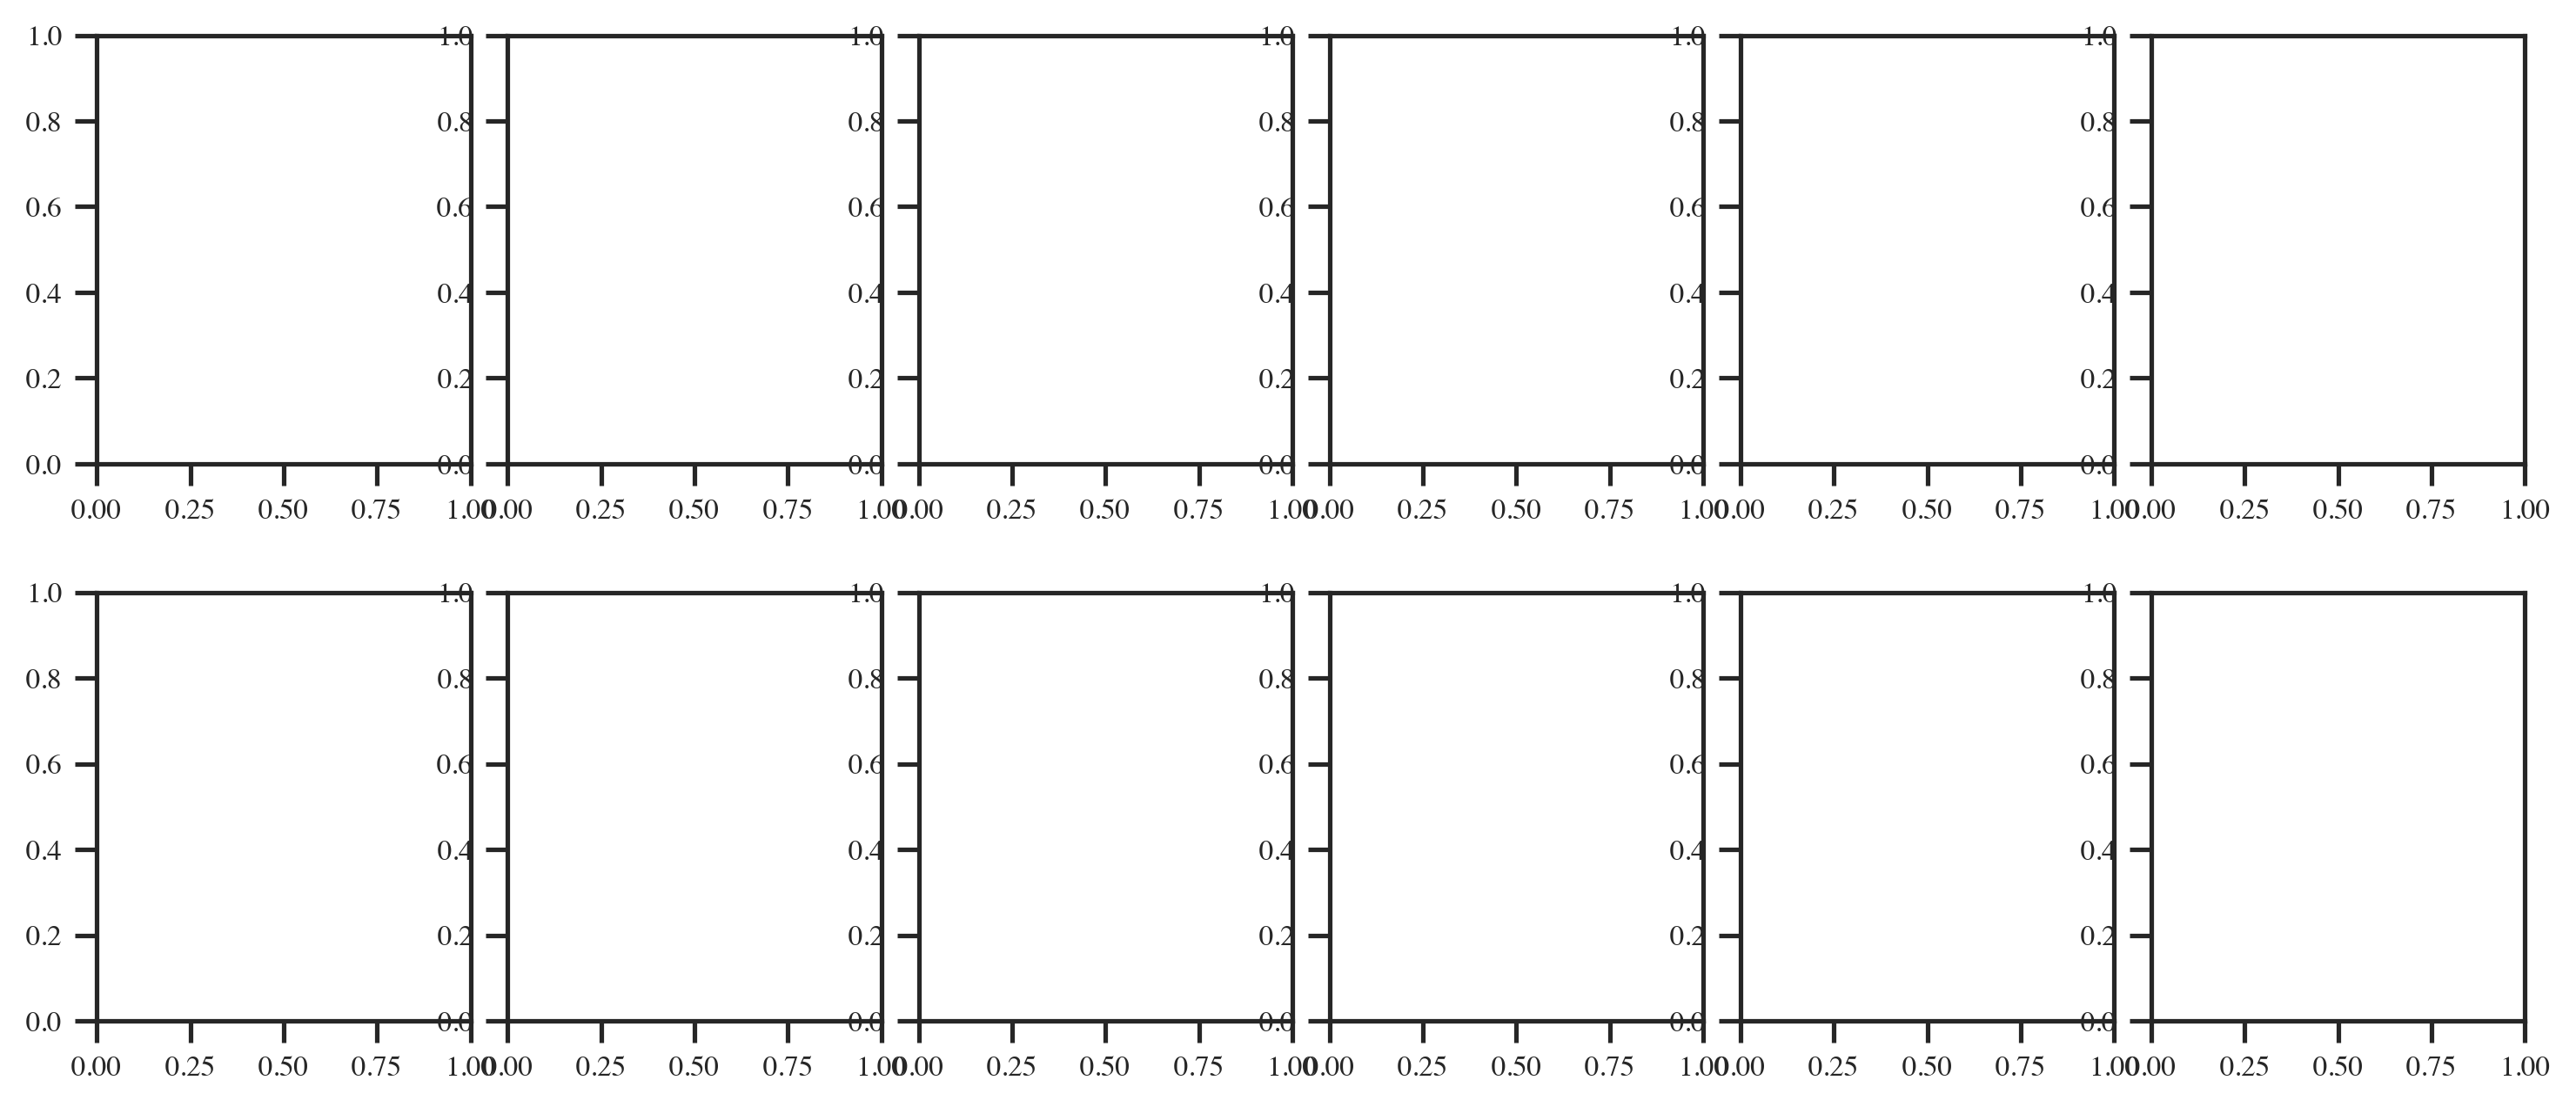

In [203]:
from icl.figures.colors import PRIMARY, SECONDARY

fig, axes = plt.subplots(2, len(grad_batch_sizes), figsize=(12, 5))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

LOSS_MEAN, LOSS_STD = 'llc/mean/mean', 'llc/mean/std'
max_loss_over_time = eval_minibatch_df[LOSS_MEAN].max() 
max_loss_at_end = eval_minibatch_df[eval_minibatch_df['_step'] == eval_minibatch_df['_step'].max()][LOSS_MEAN].max() 

for r, (row_axes, batch_type) in enumerate(zip(axes, ['grad', 'new'])):
    for i, (ax1, grad_batch) in enumerate(zip(row_axes, grad_batch_sizes)):
        _df = eval_minibatch_df.loc[(eval_minibatch_df['sampler_config/grad_batch_size'] == grad_batch) & (eval_minibatch_df['sampler_config/eval_method'] == f'{batch_type}-minibatch')].sort_values(by=['step', '_step'])

        sns.lineplot(data=_df, x="_step", y=LOSS_MEAN, hue="step", palette="tab10", ax=ax1, alpha=1)

        for step, color in zip(_df['step'].unique(), [PRIMARY, SECONDARY]):
            _step_df = _df.loc[_df['step'] == step]
            # for chain in range(8):
            #     ax1.plot(_step_df['_step'], _step_df[f"llc/mean/{chain}"], alpha=0.5, color=color, linewidth=0.5)
            ax1.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.1)  
            # ax1.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.1)
            

        ax1.set_title(f"$m = {grad_batch}$")
        ax1.set_xlabel(r"$\tau$")

        if i < 5:
            ax1.legend().remove()
        else:
            ax1.legend(['10.1k', '_', '500k'], title=r"Step, $t$", loc='upper left', bbox_to_anchor=(1.05, 1))
            # ax1.legend(['1', '_', '3.2k', '_', '27.1k', '_', '121k', '_', '500k'], title=r"Step, $t$", loc='upper left', bbox_to_anchor=(1.05, 1))

        ax1.set_ylim(0, max_loss_over_time * .8)
        # ax1.set_yscale('log')

        # _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

        # ax2.plot(_final_df['task_config/num_tasks'], _final_df[LOSS_MEAN], alpha=1)
        # ax2.fill_between(_final_df["task_config/num_tasks"], _final_df[LOSS_MEAN] - _final_df[LOSS_STD], _final_df[LOSS_MEAN] + _final_df[LOSS_STD], alpha=0.5)

        # ax2.set_title(fr"$\mu = {eval_batch_size}, t=500k$")
        # ax2.set_xlabel(r"$M$")
        # ax2.set_xscale('log', base=2)

        # ax2.set_ylim(0, max_loss_at_end * 1.25)

        if i > 0:
            ax1.set_yticklabels([])
            ax1.set_ylabel("")
            # ax2.set_yticklabels([])
            # ax2.set_ylabel("")

axes[0, 0].set_ylabel("Same minibatch\n" r"$\hat\lambda_t$")
axes[1, 0].set_ylabel("New minibatch\n" r"$\hat\lambda_t$")

fig.set_facecolor('white')
plt.tight_layout()

## Evaluation Loss Function

In [173]:
FORCE_REEVAL = True

EVAL_LOSS_FN_SWEEP_NAME = "loss-fn"
EVAL_LOSS_FN_SWEEP_ID = "skcddlzg"

if not os.path.exists(ANALYSIS / EVAL_LOSS_FN_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_loss_fn_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_LOSS_FN_SWEEP_ID}")
        eval_loss_fn_runs = list(filter_objs([r for r in eval_loss_fn_sweep.runs], config=filters))
        eval_loss_fn_df = wandb_runs_to_df(eval_loss_fn_runs)
    
    eval_loss_fn_df.to_pickle(ANALYSIS / EVAL_LOSS_FN_SWEEP_NAME)

else:
    eval_loss_fn_df = pd.read_pickle(ANALYSIS / EVAL_LOSS_FN_SWEEP_NAME)

# columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

# for col in columns_to_convert:
#     eval_loss_fn_df[col] = pd.to_numeric(eval_loss_fn_df[col], errors='coerce')


eval_loss_fn_df.reset_index(inplace=True)
eval_loss_fn_df['log_num_tasks'] = np.log2(eval_loss_fn_df['task_config/num_tasks'])
eval_loss_fn_df

Converting runs to dfs: 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]
<ipython-input-173-4c540add4d4a>:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_loss_fn_df.reset_index(inplace=True)
<ipython-input-173-4c540add4d4a>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eval_loss_fn_df['log_num_tasks'] = np.log2(eval_loss_fn_df['task_config/num_tasks'])


index  wbic/mean/1  llc/mean/6  wbic/mean/2  llc/std/mean  loss/std/2  \
0         0   3414913.00   21.604273   2576041.50     12.814214    0.179468   
1         1   3443064.00   35.599285   2666153.00     16.454799    0.196717   
2         2   3492806.50   47.228508   2757152.50     19.375442    0.233223   
3         3   3521259.00   56.543728   2842195.75     21.585329    0.267224   
4         4   3554368.75   64.826790   2913225.75     23.454081    0.290753   
...     ...          ...         ...          ...           ...         ...   
3211    196   4674009.00   33.394657   4756730.00     19.660018    0.285059   
3212    197   4674327.00   33.410263   4756897.00     19.666183    0.285240   
3213    198   4674627.00   33.420502   4756680.00     19.664546    0.285176   
3214    199   4674427.00   33.389919   4756597.00     19.661632    0.285320   
3215    200          NaN         NaN          NaN           NaN         NaN   

      loss/std/0  loss/mean/6    _runtime  loss/std/std  ...  \
0       0.252977     1.020273  418.798892      0.023907  ...   
1       0.258809     1.230199  419.134676      0.033253  ...   
2       0.258883     1.404637  419.464422      0.053867  ...   
3       0.252830     1.544365  419.790507      0.070635  ...   
4       0.246287     1.668611  420.342033      0.085643  ...   
...          ...          ...         ...           ...  ...   
3211    0.263335     4.653750  475.563571      0.018768  ...   
3212    0.263466     4.653984  475.810584      0.018732  ...   
3213    0.263368     4.654138  476.058968      0.018800  ...   
3214    0.263346     4.653679  482.910151      0.018788  ...   
3215         NaN          NaN  496.351799           NaN  ...   

      sampler_config/gradient_scale  sampler_config/eval_batch_size  \
0                              0.01                            1024   
1                              0.01                            1024   
2                              0.01                            1024   
3                              0.01                            1024   
4                              0.01                            1024   
...                             ...                             ...   
3211                           0.01                            1024   
3212                           0.01                            1024   
3213                           0.01                            1024   
3214                           0.01                            1024   
3215                           0.01                            1024   

      sampler_config/grad_batch_size  sampler_config/sampling_method  \
0                               1024                            sgld   
1                               1024                            sgld   
2                               1024                            sgld   
3                               1024                            sgld   
4                               1024                            sgld   
...                              ...                             ...   
3211                            1024                            sgld   
3212                            1024                            sgld   
3213                            1024                            sgld   
3214                            1024                            sgld   
3215                            1024                            sgld   

      sampler_config/eval_dataset_size  sampler_config/grad_batch_origin  \
0                              1048576                      eval-dataset   
1                              1048576                      eval-dataset   
2                              1048576                      eval-dataset   
3                              1048576                      eval-dataset   
4                              1048576                      eval-dataset   
...                                ...                               ...   
3211                           1048576

In [174]:
eval_loss_fn_df = eval_loss_fn_df.loc[eval_loss_fn_df['task_config/layer_norm'] == True]

In [175]:
loss_fns = ['mse', "subsequence-mse"]
focus_steps = [10204, 499999]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-187-4256bedf2c2d>:37: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb851589a0> starts with '_'. It is thus excluded from the legend.
  ax1.legend([l if i else "_" for l in labels for i in [1, 0]], title=r"Step $t$", loc='upper left', bbox_to_anchor=(1.05, 1))
<ipython-input-187-4256bedf2c2d>:37: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb93964fd0> starts with '_'. It is thus excluded from the legend.
  ax1.legend([l if i else "_" for l in labels for i in [1, 0]], title=r"Step $t$", loc='upper left', bbox_to_anchor=(1.05, 1))
<ipython-input-187-4256bedf2c2d>:37: UserWarning: The label '_' of <matplotlib.collections.PolyCollection object at 0x7fdb93dd8790> starts with '_'. It is thus excluded from the legend.
  ax1.legend([l if i else "_" f

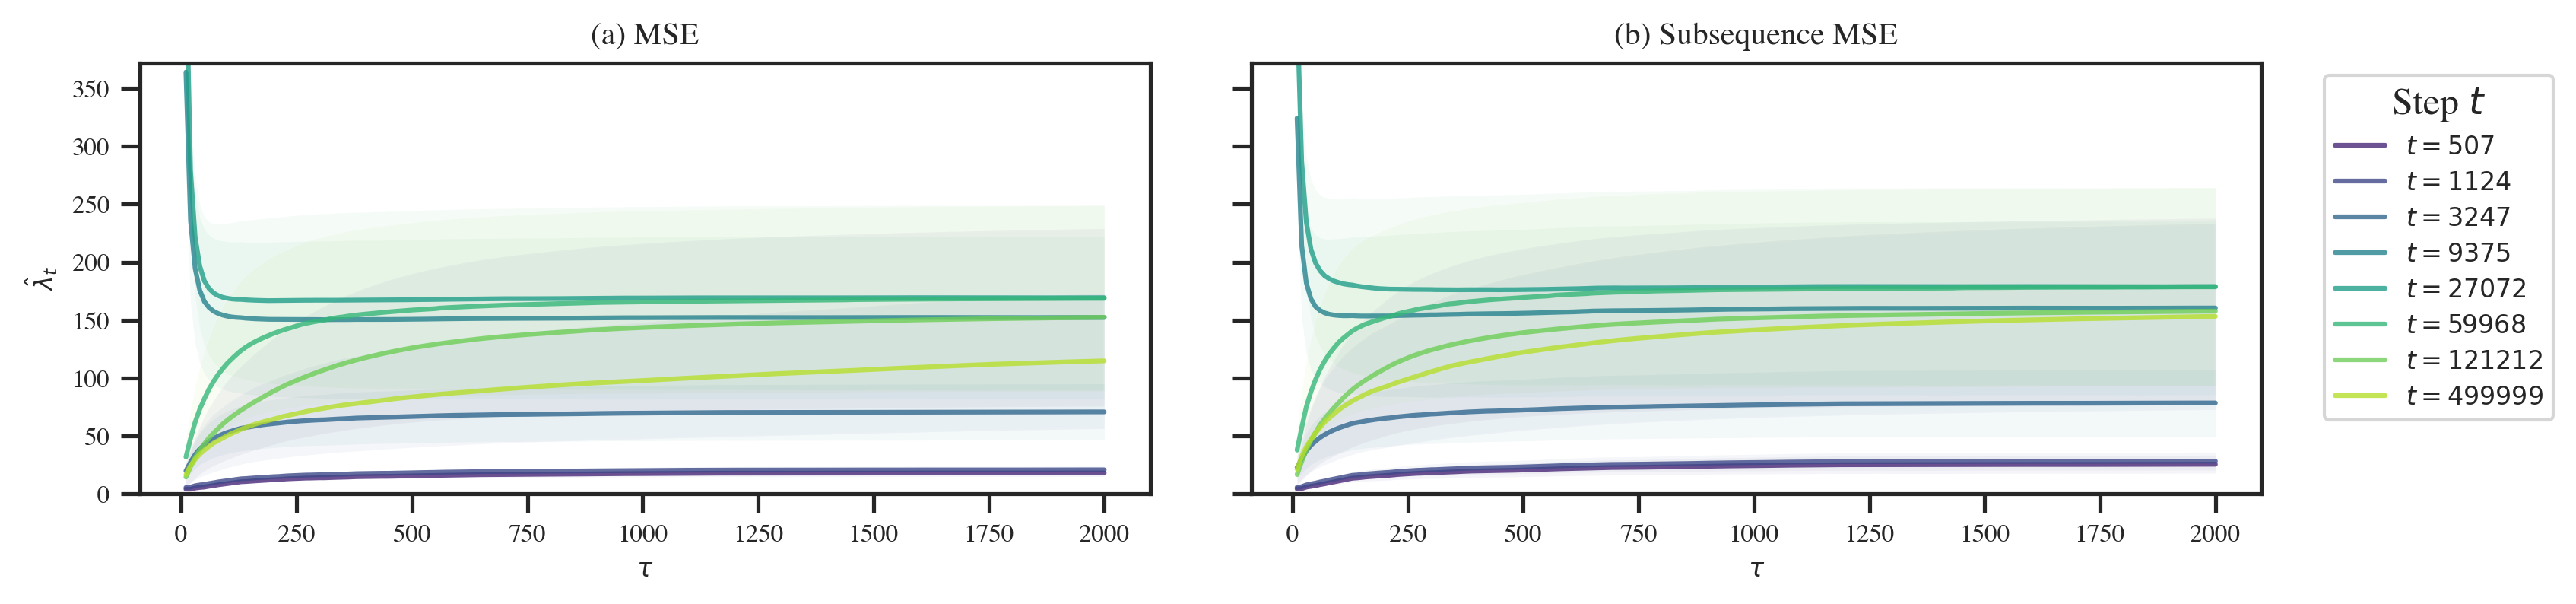

In [187]:
from icl.figures.colors import PRIMARY, SECONDARY

fig, axes = plt.subplots(1, len(loss_fns), figsize=(12, 2.5))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

LOSS_MEAN, LOSS_STD = 'llc/mean/mean', 'llc/mean/std'
max_loss_over_time = eval_loss_fn_df[LOSS_MEAN].max() 
max_loss_at_end = eval_loss_fn_df[eval_loss_fn_df['_step'] == eval_loss_fn_df['_step'].max()][LOSS_MEAN].max() 

colors = sns.color_palette('viridis', len(steps))


for i, (ax1, loss_fn) in enumerate(zip(axes, loss_fns)):
    _df = eval_loss_fn_df.loc[eval_loss_fn_df['sampler_config/eval_loss_fn'] == loss_fn].sort_values(by=['step', '_step'])


    for step, color in zip(_df['step'].unique(), colors):
        _step_df = _df.loc[_df['step'] == step]
        # for chain in range(8):
        #     ax1.plot(_step_df['_step'], _step_df[f"llc/mean/{chain}"], alpha=0.5, color=color, linewidth=0.5)
        sns.lineplot(data=_step_df, x="_step", y=LOSS_MEAN, color=color, ax=ax1, alpha=0.8)

    for step, color in zip(_df['step'].unique(), colors):
        _step_df = _df.loc[_df['step'] == step]

        ax1.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.05)  
        # ax1.fill_between(_step_df['_step'], _step_df[LOSS_MEAN] - _step_df[LOSS_STD], _step_df[LOSS_MEAN] + _step_df[LOSS_STD], alpha=0.1)
        

    ax1.set_title({ "mse": "(a) MSE", "subsequence-mse": "(b) Subsequence MSE" }[loss_fn])
    ax1.set_xlabel(r"$\tau$")

    if i < 1:
        ax1.legend().remove()
    else:
        ax1.legend([l if i else "_" for l in labels for i in [1, 0]], title=r"Step $t$", loc='upper left', bbox_to_anchor=(1.05, 1))

    ax1.set_ylim(0, max_loss_over_time * .8)
    # ax1.set_yscale('log')

    # _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

    # ax2.plot(_final_df['task_config/num_tasks'], _final_df[LOSS_MEAN], alpha=1)
    # ax2.fill_between(_final_df["task_config/num_tasks"], _final_df[LOSS_MEAN] - _final_df[LOSS_STD], _final_df[LOSS_MEAN] + _final_df[LOSS_STD], alpha=0.5)

    # ax2.set_title(fr"$\mu = {eval_batch_size}, t=500k$")
    # ax2.set_xlabel(r"$M$")
    # ax2.set_xscale('log', base=2)

    # ax2.set_ylim(0, max_loss_at_end * 1.25)

    if i > 0:
        ax1.set_yticklabels([])
        ax1.set_ylabel("")
        # ax2.set_yticklabels([])
        # ax2.set_ylabel("")

axes[0].set_ylabel(r"$\hat\lambda_t$")


fig.set_facecolor('white')
fig.savefig(FIGURES / "llc-vs-loss-fn.pdf", bbox_inches='tight')

# Role of seed


In [188]:
seeded_run = api.run("devinterp/icl/tptexwlo")
unseeded_run = api.run("devinterp/icl/aegfv4rj")
seeds_df = wandb_runs_to_df([seeded_run, unseeded_run])
print(seeds_df['sampler_config/init_seed'].unique())
seeds_df

Converting runs to dfs:   0%|          | 0/2 [00:00<?, ?it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
Converting runs to dfs:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
Converting runs to dfs: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

[0 None]


batch-loss/chain-7/mean/std  batch-loss/chain-5/std/1  \
0                       0.039342                  0.283314   
1                       0.038924                  0.284986   
2                       0.038934                  0.285320   
3                       0.038926                  0.285170   
4                       0.038927                  0.285026   
..                           ...                       ...   
185                     0.345079                  0.296032   
186                     0.199105                  0.278077   
187                     0.146063                  0.278567   
188                     0.398824                  0.285933   
189                     0.389408                  0.287282   

     batch-loss/chain-9/mean/5  batch-loss/chain-6/std/4  \
0                     4.472940                  0.256399   
1                     4.477653                  0.262356   
2                     4.477586                  0.262472   
3                     4.477579                  0.262345   
4                     4.477595                  0.262239   
..                         ...                       ...   
185                   3.652139                  0.552929   
186                   3.528930                  0.436645   
187                   3.224658                  0.314087   
188                   3.877218                  0.352402   
189                   3.346036                  0.303738   

     batch-loss/chain-8/std/5  batch-loss/chain-0/mean/4  \
0                    0.263053                   4.447923   
1                    0.261007                   4.437506   
2                    0.261175                   4.437508   
3                    0.260803                   4.437471   
4                    0.261183                   4.437513   
..                        ...                        ...   
185                  0.328845                   3.315043   
186                  0.552593                   3.280504   
187                  0.389493                   3.641958   
188                  0.640171                   3.388131   
189                  0.432248                   3.474045   

     batch-loss/chain-5/mean/mean  loss/mean/3  wbic/mean/7  \
0                        4.457945     4.442964   4703254.50   
1                        4.452732     4.444094   4694600.00   
2                        4.452859     4.444119   4694582.00   
3                        4.452842     4.444102   4694573.00   
4                        4.452818     4.444089   4694596.50   
..                            ...          ...          ...   
185                      3.864155     3.643962   3574047.75   
186                      3.495051     3.602630   3543438.50   
187                      3.526205     3.624217   3544753.75   
188                      3.591537     3.621253   3528770.50   
189                      3.878652     3.541649   3424566.75   

     batch-loss/chain-7/std/mean  ...  sampler_config/eval_loss_fn  \
0                       0.265156  ...                          mse   
1                       0.267159  ...                          mse   
2                       0.267138  ...                          mse   
3                       0.267099  ...                          mse   
4                       0.267122  ...                          mse   
..                           ...  ...                          ...   
185                     0.379203  ...                          mse   
186                     0.492031  ...                          mse   
187                     0.459266  ...                          mse   
188                     0.307296  ...                          mse   
189                     0.354535  ...                          mse   

     sampler_config/eval_metrics/0  sampler_config/eval_metrics/1  \
0               likelihood-derived                     batch-loss   
1               likelihood-derived                     batch-loss   
2            

In [189]:
torch.normal(0, 1, (1_000_000, 4)).norm(dim=-1).mean()

tensor(1.8795)

None (190, 344)
0 (190, 344)


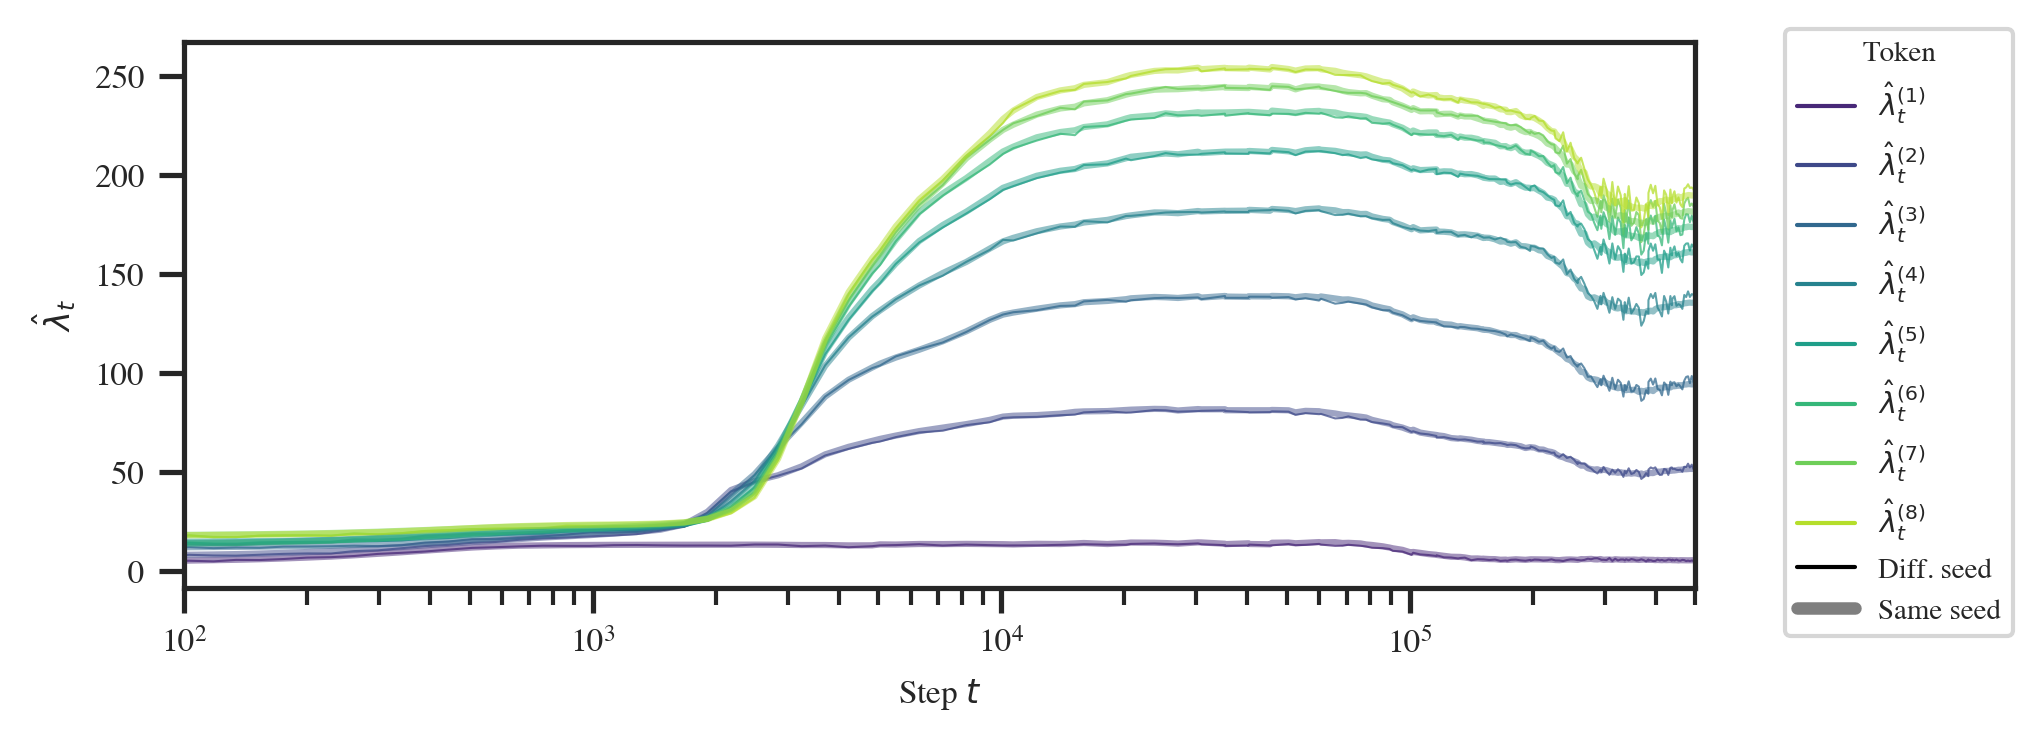

In [200]:
fig, ax = plt.subplots(figsize=(FULL_WIDTH, FULL_HEIGHT * 3 / 5))

cmap = sns.color_palette("viridis", 8)

for seed in [None, 0]:
    if seed is None:
        _df = seeds_df.loc[seeds_df['sampler_config/init_seed'].isna()]
    else:
        _df = seeds_df.loc[seeds_df['sampler_config/init_seed'] == seed]

    print(seed, _df.values.shape)
    alpha = 0.75 if seed is None else .5
    linewidth = 0.5 if seed is None else 1.5

    for t in range(8):
        color = cmap[t]
        sns.lineplot(data=_df, x="_step", y=f"llc/mean/{t}", alpha=alpha, ax=ax, linewidth=linewidth, color=color)

ax.set_ylabel('$\hat\lambda_t$')
ax.set_xlabel(r"Step $t$")
ax.set_xlim(100, 500000)
ax.set_xscale('log')
# handles = [plt.Line2D([0], [0], color=cmap[t], linewidth=[1, 3][s], alpha=[1, 0.25][s]) for s in range(2) for t in range(8)]
# labels = [rf"$\hat \lambda_t^{{({t+1})}}$" for s in range(2) for t in range(8)]

handles = [plt.Line2D([0], [0], color=cmap[t], linewidth=1) for t in range(8)]
labels = [rf"$\hat \lambda_t^{{({t+1})}}$" for t in range(8)]
handles += [plt.Line2D([0], [0], color='black', linewidth=1), plt.Line2D([0], [0], color='black', linewidth=3, alpha=0.5)]
labels += [r"Diff. seed", r"Same seed"]

ax.legend(handles, labels, bbox_to_anchor=(1.05, 1.05), title="Token", loc='upper left', ncol=1, fontsize='xx-small', title_fontsize='xx-small')

# twinax = ax.twinx()
# twinax.legend(handles, labels, bbox_to_anchor=(1.05, 1), title="Seed", loc='center left', ncol=1, fontsize='xx-small', title_fontsize='xx-small')
fig.savefig(FIGURES / "llc-vs-seed.pdf", bbox_inches='tight')


# LLCs over time

In [ ]:
from devinfra.utils.iterables import flatten_dict

Converting runs to dfs:   0%|          | 0/21 [00:00<?, ?it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Converting runs to dfs:   5%|▍         | 1/21 [00:00<00:13,  1.44it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/pyth

In [ ]:
pp(list(df.columns))

df

['llc-chain/21',
 'llc-chain/24',
 'llc-chain/7',
 'llc-chain/4',
 'llc-chain/6',
 'llc-chain/20',
 'llc-chain/10',
 'llc-chain/0',
 '_timestamp',
 '_step',
 'llc-chain/11',
 'llc/mean',
 'llc-chain/2',
 'llc-chain/19',
 'llc-chain/17',
 'llc/std',
 'llc-chain/12',
 'llc-chain/9',
 'llc-chain/18',
 'llc-chain/22',
 'llc-chain/3',
 '_runtime',
 'llc-chain/15',
 'llc-chain/13',
 'llc-chain/8',
 'llc-chain/14',
 'llc-chain/5',
 'llc-chain/16',
 'llc-chain/23',
 'llc-chain/1',
 'num_training_samples',
 'batch_size',
 'run_name',
 'num_steps',
 'optimizer_config/optimizer_type',
 'optimizer_config/lr',
 'optimizer_config/weight_decay',
 'optimizer_config/momentum',
 'optimizer_config/betas',
 'optimizer_config/noise_level',
 'optimizer_config/elasticity',
 'optimizer_config/temperature',
 'optimizer_config/num_samples',
 'scheduler_config/scheduler_type',
 'scheduler_config/step_size',
 'scheduler_config/gamma',
 'scheduler_config/T_max',
 'scheduler_config/eta_min',
 'scheduler_config/last

llc-chain/21 llc-chain/24 llc-chain/7 llc-chain/4 llc-chain/6 llc-chain/20  \
0    -31.492245   -34.640392  -37.571781  -29.759884  -34.418633   -33.259899   
1    -37.149822   -31.687656  -36.097107  -34.656593  -37.521626   -36.160576   
2    -33.165081   -36.720608  -35.567787   -43.45013  -41.736015    -38.18063   
3    -32.224651   -31.908781  -38.273193   -34.63229    -39.1908   -31.796915   
4      -37.2402   -40.164619  -33.410297  -41.476849  -38.946991   -32.499805   
..          ...          ...         ...         ...         ...          ...   
91    22.153051    13.162414   10.061708     5.37724   14.821695      12.0565   
92    16.378391     9.404738    11.65611   16.117937   19.421547     15.99394   
93    13.902676     12.52443    18.67099   12.419909    3.605349    12.773421   
94    15.490371    17.433939    4.917962   11.864624    19.78948    10.031211   
95    15.380537    12.390076   11.166277   20.542561    4.430571    12.753942   

   llc-chain/10 llc-chain/0    _timestamp   _step  ...  \
0     -39.27005  -27.284689  1.701769e+09       0  ...   
1    -32.603851  -32.284039  1.701770e+09       1  ...   
2    -40.780159  -36.970047  1.701770e+09       2  ...   
3    -33.310265  -45.639111  1.701771e+09       3  ...   
4    -44.019531  -29.738609  1.701772e+09       4  ...   
..          ...         ...           ...     ...  ...   
91     15.54309    16.07786  1.701473e+09  459183  ...   
92    16.026758   13.233388  1.701474e+09  469387  ...   
93    15.656064   18.471336  1.701475e+09  479591  ...   
94     6.908941    10.63745  1.701475e+09  489795  ...   
95      4.55807   13.263488  1.701476e+09  499999  ...   

   task_config/noise_variance task_config/embed_size task_config/mlp_size  \
0                       0.125                     64                   64   
1                       0.125                     64                   64   
2                       0.125                     64                   64   
3                       0.125                     64                   64   
4                       0.125                     64                   64   
..                        ...                    ...                  ...   
91                      0.125                     64                   64   
92                      0.125                     64                   64   
93                      0.125                     64                   64   
94                      0.125                     64                   64   
95                      0.125                     64                   64   

   task_config/num_heads task_config/num_layers task_config/model_seed  \
0                      4                      2                      0   
1                      4                      2                      0   
2                      4                      2                      0   
3                      4                      2                      0   
4                      4                      2                      0   
..                   ...                    ...                    ...   
91                     4                      2                      0   
92                     4                      2                      0   
93                     4                      2                      0   
94                     4                      2                      0   
95                     4                      2                      0   

   task_config/pretrain_seed task_config/true_seed task_config/sampling_seed  \
0                          1                     2                         3   
1                          1                     2                         3   
2                          1                     2                         3   
3                          1                     2                         3   
4                          1                     2                         3   
..                       ...           

In [ ]:
llc_chain_columns = [f'llc-chain/{i}' for i in range(25)]
df[llc_chain_columns] = df[llc_chain_columns].replace("NaN", np.nan)


# Calculate the average of non-NaN values in llc-chain columns
# and the fraction of NaN values
llc_chain_values = df[llc_chain_columns]
mean_llc_chain = llc_chain_values.mean(axis=1, skipna=True)
frac_nan = llc_chain_values.isna().mean(axis=1)

df["llc/mean-fixed"] = mean_llc_chain
df["llc/frac-nan"] = frac_nan
df["log_num_tasks"] = np.log(df["task_config/num_tasks"])

mean_llc_chain, frac_nan

(0    -35.240626
 1    -36.057135
 2    -37.265739
 3    -35.599871
 4    -37.586922
         ...    
 91    11.272044
 92    13.656166
 93    13.961580
 94    13.416571
 95    12.224514
 Length: 2016, dtype: float64,
 0     0.0
 1     0.0
 2     0.0
 3     0.0
 4     0.0
      ... 
 91    0.0
 92    0.0
 93    0.0
 94    0.0
 95    0.0
 Length: 2016, dtype: float64)

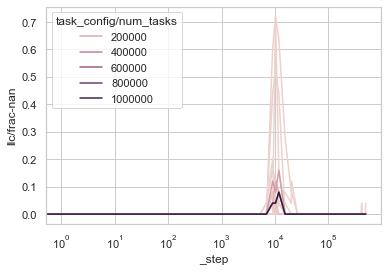

In [ ]:
sns.lineplot(data=df, x="_step", y="llc/frac-nan", hue="task_config/num_tasks")
plt.xscale("log")

In [ ]:
from matplotlib import patches


TRANSITIONS = [
    (100, 800, 'A1'),
    (800, 10_000, 'A2'),
    (10_000, 28_000, 'B1'),
    (28_000, 280_000, 'B2'),
]

INIT_X = TRANSITIONS[0][0]
FINAL_X = TRANSITIONS[-1][1]

def plot_transitions(axes, **kwargs):
    from icl.figures.colors import plot_transitions as _plot_transitions
    return _plot_transitions(axes, TRANSITIONS, **kwargs)

In [ ]:
steps = checkpointers[0].file_ids
steps

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 11,
 14,
 19,
 24,
 32,
 42,
 55,
 72,
 94,
 124,
 162,
 211,
 276,
 362,
 473,
 618,
 808,
 1056,
 1381,
 1805,
 2359,
 3084,
 4031,
 5269,
 6887,
 9003,
 10204,
 11767,
 15381,
 20104,
 20408,
 26279,
 30612,
 34349,
 40816,
 44897,
 51020,
 58684,
 61224,
 71428,
 76706,
 81632,
 91836,
 100262,
 102040,
 112244,
 122448,
 131051,
 132653,
 142857,
 153061,
 163265,
 171296,
 173469,
 183673,
 193877,
 204081,
 214285,
 223899,
 224489,
 234693,
 244897,
 255102,
 265306,
 275510,
 285714,
 292657,
 295918,
 306122,
 316326,
 326530,
 336734,
 346938,
 357142,
 367346,
 377551,
 382529,
 387755,
 397959,
 408163,
 418367,
 428571,
 438775,
 448979,
 459183,
 469387,
 479591,
 489795,
 499999]

In [ ]:
from collections import defaultdict
from icl.analysis.evals import ICLEvaluator
from icl.experiments.activations_analysis import iter_models
from icl.train import Run

evals = []
functional_metrics = []
gradient_norms = []

B = 8192
K = 8
D = 4
OOD_MULTIPLIER = 3

def eval_loss(yhats, ys):
    return ((yhats - ys) ** 2).mean(dim=0)[:, 0]

def apply_transformations(ws, xs):
    return xs @ ws.view(B, D, 1)

for log2_M, config in tqdm(enumerate(configs)):
    run = Run(config)
    run.evaluator = ICLEvaluator(
        pretrain_dist=run.pretrain_dist,
        true_dist=run.true_dist,
        max_examples=config.task_config.max_examples,
        eval_batch_size=8192,
        seed=config.task_config.true_seed,
    )
    pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
        DEVICE
    )
    noise_std = pretrain_dist_noiseless.std
    pretrain_dist_noiseless.std = 0.

    ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D 
    wpriors = pretrain_dist_noiseless.task_distribution.tasks.mean(dim=0) # -> D
    wpriors = wpriors.repeat(B, 1) # -> B D

    xs = torch.normal(
        mean=0.,
        std=1.,
        size=(B, K, D,),
        device=DEVICE
    )
    ood_xs = OOD_MULTIPLIER * xs

    errors = torch.normal(
        mean=0.,
        std=noise_std,
        size=(B, K, 1,),
        device=DEVICE,
    )

    ys_without_noise = apply_transformations(ws, xs)
    ood_ys_without_noise= OOD_MULTIPLIER * ys_without_noise

    ys = ys_without_noise + errors
    ood_ys = ood_ys_without_noise + errors

    yhats_prior = apply_transformations(wpriors, xs)
    yhats_zero = torch.zeros_like(ys)
    # ood_yhats_prior = apply_transformations(wpriors, ood_xs)
    
    for step, model in zip(steps, iter_models(run.model, run.checkpointer)):
        yhats = model(xs, ys)
        ood_yhats = model(xs, ood_ys)
        # yhats_without_noise = model(xs, ys_without_noise)

        losses = eval_loss(yhats, ys)
        # losses_without_noise = eval_loss(yhats_without_noise, ys_without_noise)
        losses_prior = eval_loss(yhats, yhats_prior)
        losses_zero = eval_loss(yhats, yhats_zero)

        ood_losses = eval_loss(ood_yhats, ood_ys)
        # ood_losses_midpoint = eval_loss(ood_yhats, ood_yhats_prior)
        # ood_losses_without_noise = eval_loss(yhats, ood_ys_without_noise)

        loss = losses.mean()
        loss.backward()

        for n, p in model.named_parameters():
            if p.grad is None:
                continue

            grad_sq_mean = (p.grad ** 2).mean().item()
            grad_sq_std = (p.grad ** 2).std().item()

            gradient_norms.append({
                "m": log2_M,
                "M": 2 ** log2_M,    
                "step": step,
                "layer": n,
                "grad/norm": grad_sq_mean ** 0.5,
                "grad_sq/mean": grad_sq_mean,
                "grad_sq/std": grad_sq_std,
                "numel": p.numel(),
                "loss": loss.item(),
            })          

            p.grad = None 

        for token in range(8):
            functional_metrics.append({
                "m": log2_M,
                "M": 2 ** log2_M,
                "step": step,
                "loss": losses[token].item(),
                "ood_loss": ood_losses[token].item(),
                # "loss_without_noise": losses_without_noise[i],
                # "ood_loss_without_noise": ood_losses_without_noise[i],
                "loss_prior": losses_prior[token].item(),
                "loss_zero": losses_zero[token].item(),
                # "ood_loss_midpoint": ood_losses_midpoint[i],
                "token": token
            })

        evals.append({
            "m": log2_M,
            "M": 2 ** log2_M,
            "step": step,
            "weight_norm": (sum([(p ** 2).sum() for p in model.parameters()]) ** 0.5).item(),
            **run.evaluator(model),
        })


evals = pd.DataFrame(evals)
evals.to_csv(ANALYSIS / "small-model-evals.csv", index=False)
functional_metrics = pd.DataFrame(functional_metrics)
functional_metrics.to_csv(ANALYSIS / "small-model-functional-metrics.csv", index=False)
gradient_norms = pd.DataFrame(gradient_norms)
gradient_norms.to_csv(ANALYSIS / "small-model-gradient-norms.csv", index=False)

0it [00:08, ?it/s]


KeyboardInterrupt: 

In [ ]:
evals = pd.read_csv(ANALYSIS / "small-model-evals.csv")
functional_metrics = pd.read_csv(ANALYSIS / "small-model-functional-metrics.csv")
gradient_norms = pd.read_csv(ANALYSIS / "small-model-gradient-norms.csv")

In [ ]:
evals.columns

In [ ]:
from icl.figures.derivatives import d_dt, d_dlogt, dlog_dlogt

In [ ]:
for log2_M in range(20):
    # Filter the DataFrame and compute the derivatives
    mse_values = evals.loc[evals.m == log2_M, "pretrain/mse"].values
    llc_values = df.loc[df["task_config/num_tasks"] == int(2 ** log2_M), "llc/mean-fixed"].values
    weightnorm_values = evals.loc[evals.m == log2_M, "weight_norm"].values
    
    # Compute the derivatives using your d_dlogt function
    dloss_dlogt_values = d_dlogt(steps, mse_values)
    dllc_dlogt_values = d_dlogt(steps, llc_values)
    dweightnorm_dlogt_values = d_dlogt(steps, weightnorm_values)

    # Assign the computed derivatives back to the original DataFrame
    evals.loc[evals.m == log2_M, "dloss_dlogt"] = dloss_dlogt_values
    evals.loc[evals.m == log2_M, "dllc_dlogt"] = dllc_dlogt_values
    evals.loc[evals.m == log2_M, "dweightnorm_dlogt"] = dweightnorm_dlogt_values


In [ ]:
evals.columns

[(0.280894, 0.078907, 0.402329), (0.28229, 0.145912, 0.46151), (0.270595, 0.214069, 0.507052), (0.250425, 0.27429, 0.533103), (0.223925, 0.334994, 0.548053), (0.19943, 0.387607, 0.554642), (0.175841, 0.44129, 0.557685), (0.15627, 0.489624, 0.557936), (0.136408, 0.541173, 0.554483), (0.121831, 0.589055, 0.545623), (0.12478, 0.640461, 0.527068), (0.162016, 0.687316, 0.499129), (0.239374, 0.735588, 0.455688), (0.335885, 0.777018, 0.402049), (0.458674, 0.816363, 0.329727), (0.585678, 0.846661, 0.249897)]


<ipython-input-46-5cb07c9b31ef>:20: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-46-5cb07c9b31ef>:29: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-46-5cb07c9b31ef>:39: UserWarning: The palette list has more values (16) than needed (13), which may not be intended.
  sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks > 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-46-5cb07c9b31ef>:48: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(data=filtered_evals, x="step", y="dllc_dlogt", hue="m", pale

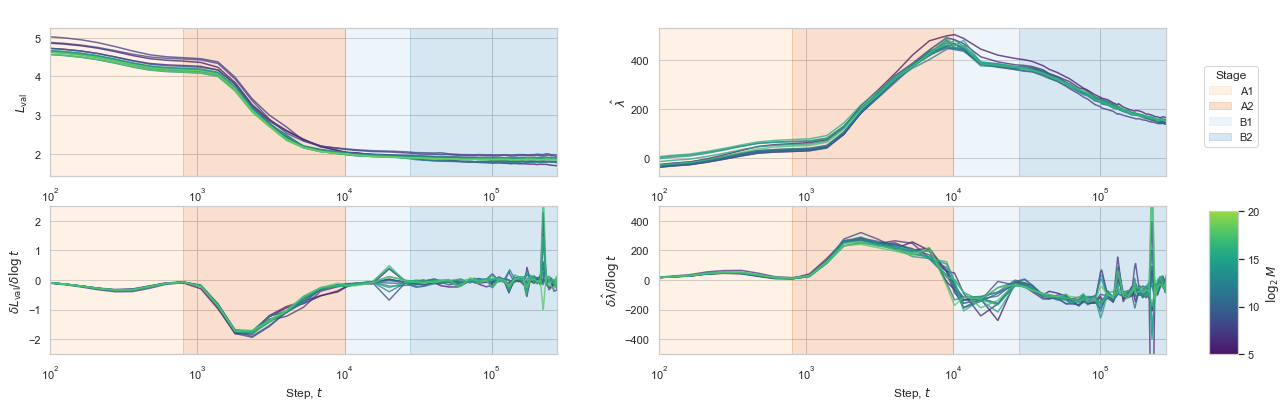

In [ ]:
from matplotlib import colors, lines, patches

def get_reduced_viridis_palette(num_colors, ratio=3 / 3.5):
    return sns.color_palette("viridis", int(num_colors // ratio))[:num_colors]

LINE_PALETTE = get_reduced_viridis_palette(21-5)
# num_palette_steps = int((21 * 3.75) // 3)
# LINE_PALETTE = [sns.color_palette("coolwarm", num_palette_steps)[i] for i in [*range(10), *range(num_palette_steps - 10, num_palette_steps)]]

print(LINE_PALETTE)
# "viridis"
ALPHA=0.75

fig, axes = plt.subplots(2, 2, figsize=(20, 6))

ax = axes[0, 0]

filtered_evals = evals.loc[(evals.step != 20408) & (evals['m'] > 5)]

sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

ax = axes[1, 0]

sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta L_\mathrm{val}/\delta \log t$")
ax.legend().remove()
ax.set_ylim(-2.5, 2.5)

ax = axes[0, 1]

sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks > 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\hat\lambda$")
ax.legend().remove()

ax = axes[1, 1]

sns.lineplot(data=filtered_evals, x="step", y="dllc_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta \hat\lambda/\delta \log t$")
ax.set_ylim(-500, 500)
ax.legend().remove()

# ax = axes[0, 2]

# sns.lineplot(data=filtered_evals, x="step", y="weight_norm", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$|w_t|$")
# ax.legend().remove()

# ax.set_ylim(20, 800)

# ax = axes[1, 2]

# sns.lineplot(data=filtered_evals, x="step", y="dweightnorm_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$\delta|w_t|/\delta\log t$")
# ax.legend().remove()

_patches = plot_transitions(axes)


handles, labels = ax.get_legend_handles_labels()

# Create custom handles
# handles = [lines.Line2D([], [], color=custom_colors[i], marker='o', linestyle='', label=custom_labels[i]) for i in range(len(custom_labels))]

# Add the custom handles to the existing ones
# handles.extend(custom_handles)

# Now, you can create the legend with the updated handles and custom labels
# axes[0, 2].legend(handles=handles, title="$\log_2 M$", loc='center right', bbox_to_anchor=(0.9, .5))

# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
# plt.tight_layout()

cbar_ax = fig.add_axes([0.93, 0.125, 0.02, 0.33])  # Adjust as necessary for position and size
custom_cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0+5, vmax=20), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions =  [5, 10, 15, 20]  # Positions for each color
tick_labels = map(str, tick_positions)  # Labels for each color
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$\log_2 M$")


stages_legend_ax = fig.add_axes([0.945, 0.68, 0.02, 0.25])  # Adjust as necessary for position and size
stages_legend_ax.axis('off')
stages_legend_ax.legend(handles=_patches, title="Stage", loc='upper center', bbox_to_anchor=(0, .5))

fig.set_facecolor('white')


[(0.267968, 0.223549, 0.512008), (0.190631, 0.407061, 0.556089), (0.127568, 0.566949, 0.550556), (0.20803, 0.718701, 0.472873), (0.565498, 0.84243, 0.262877)]


<ipython-input-47-bb545bb90122>:20: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-47-bb545bb90122>:29: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-47-bb545bb90122>:39: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks <= 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-47-bb545bb90122>:48: UserWarning: 
The palette list has fewer values (5) than needed (6) and will 

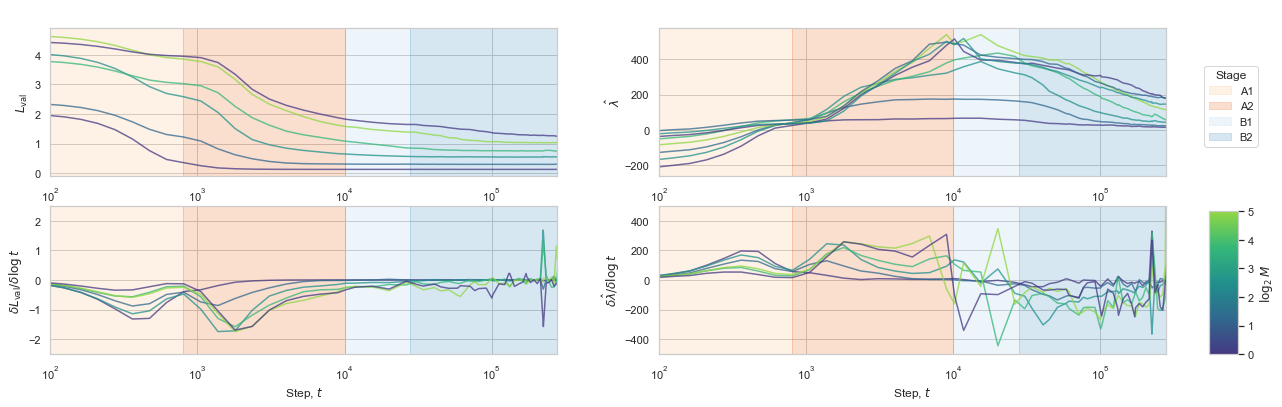

In [ ]:
from matplotlib import colors, lines, patches

def get_reduced_viridis_palette(num_colors, ratio=3 / 3.5):
    return sns.color_palette("viridis", int(num_colors // ratio))[:num_colors]

LINE_PALETTE = get_reduced_viridis_palette(5)
# num_palette_steps = int((21 * 3.75) // 3)
# LINE_PALETTE = [sns.color_palette("coolwarm", num_palette_steps)[i] for i in [*range(10), *range(num_palette_steps - 10, num_palette_steps)]]

print(LINE_PALETTE)
# "viridis"
ALPHA=0.75

fig, axes = plt.subplots(2, 2, figsize=(20, 6))

ax = axes[0, 0]

filtered_evals = evals.loc[(evals.step != 20408) & (evals['m'] <= 5)]

sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

ax = axes[1, 0]

sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta L_\mathrm{val}/\delta \log t$")
ax.legend().remove()
ax.set_ylim(-2.5, 2.5)

ax = axes[0, 1]

sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks <= 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\hat\lambda$")
ax.legend().remove()

ax = axes[1, 1]

sns.lineplot(data=filtered_evals, x="step", y="dllc_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta \hat\lambda/\delta \log t$")
ax.set_ylim(-500, 500)
ax.legend().remove()

# ax = axes[0, 2]

# sns.lineplot(data=filtered_evals, x="step", y="weight_norm", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$|w_t|$")
# ax.legend().remove()

# ax.set_ylim(20, 800)

# ax = axes[1, 2]

# sns.lineplot(data=filtered_evals, x="step", y="dweightnorm_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$\delta|w_t|/\delta\log t$")
# ax.legend().remove()

_patches = plot_transitions(axes)


handles, labels = ax.get_legend_handles_labels()

# Create custom handles
# handles = [lines.Line2D([], [], color=custom_colors[i], marker='o', linestyle='', label=custom_labels[i]) for i in range(len(custom_labels))]

# Add the custom handles to the existing ones
# handles.extend(custom_handles)

# Now, you can create the legend with the updated handles and custom labels
# axes[0, 2].legend(handles=handles, title="$\log_2 M$", loc='center right', bbox_to_anchor=(0.9, .5))

# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
# plt.tight_layout()

cbar_ax = fig.add_axes([0.93, 0.125, 0.02, 0.33])  # Adjust as necessary for position and size
custom_cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=5), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions =  [0, 1, 2, 3, 4, 5]  # Positions for each color
tick_labels = map(str, tick_positions)  # Labels for each color
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$\log_2 M$")


stages_legend_ax = fig.add_axes([0.945, 0.68, 0.02, 0.25])  # Adjust as necessary for position and size
stages_legend_ax.axis('off')
stages_legend_ax.legend(handles=_patches, title="Stage", loc='upper center', bbox_to_anchor=(0, .5))

fig.set_facecolor('white')

# Functional

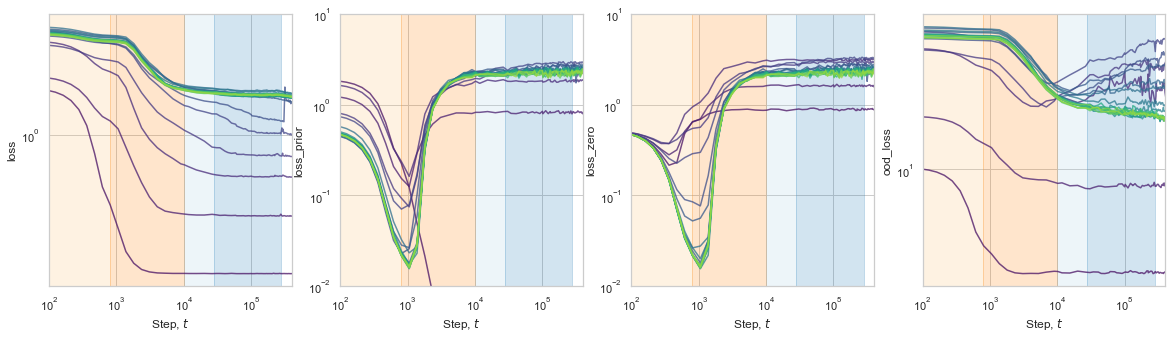

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Average across token colum
functional_metrics_averages = functional_metrics.groupby(["m", "step"]).mean().reset_index()

ax = axes[0]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

ax = axes[1]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_prior", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[2]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_zero", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[3]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="ood_loss", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(100, 400_000)
    ax.set_xlabel("Step, $t$")
    ax.legend().remove()

add_milestones(axes) #, alpha=0.8)

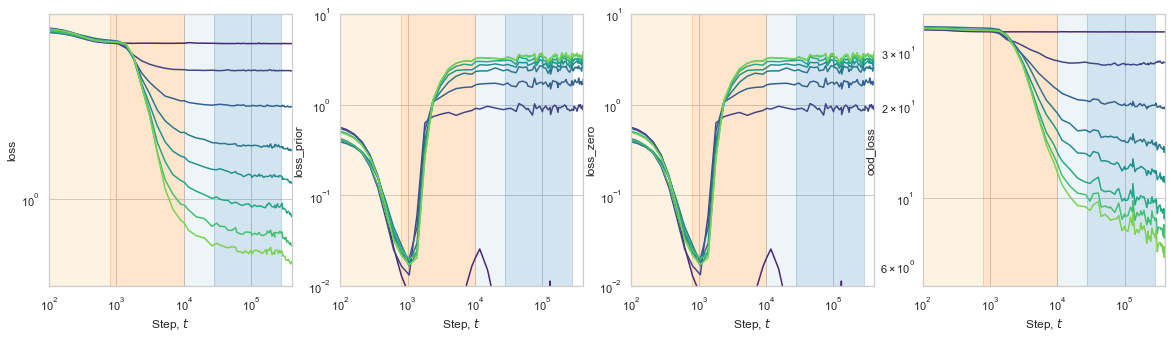

In [ ]:
LINE_PALETTE = get_reduced_viridis_palette(8)
ALPHA = 1

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Average across token colum
functional_metrics_m20 = functional_metrics.loc[functional_metrics.m == 20]

ax = axes[0]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

ax = axes[1]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="loss_prior", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[2]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="loss_zero", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[3]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="ood_loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(100, 400_000)
    ax.set_xlabel("Step, $t$")
    ax.legend().remove()

add_milestones(axes) #, alpha=0.8)

<ipython-input-164-19bef9351227>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


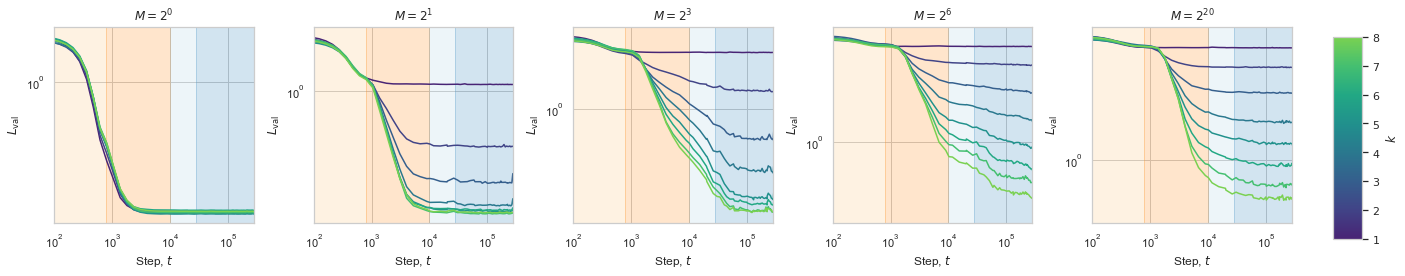

In [ ]:
from matplotlib import colors as mcolors

# LINE_PALETTE="viridis"
# ALPHA=1

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for token, log2_M in enumerate([0, 1, 3, 6, 20]):
    # Average across token colum
    ax = axes[token]
    functional_metrics_specific = functional_metrics.loc[functional_metrics.m == log2_M]
    sns.lineplot(data=functional_metrics_specific, x="step", y="loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
    ax.set_title(f"$M = 2^{{{log2_M}}}$")


for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(INIT_X, FINAL_X)
    ax.set_xlabel("Step, $t$")
    ax.set_ylabel("$L_\mathrm{val}$")
    ax.legend().remove()

add_milestones(axes, alpha=0.2) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-177-48ccdd0f7979>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make

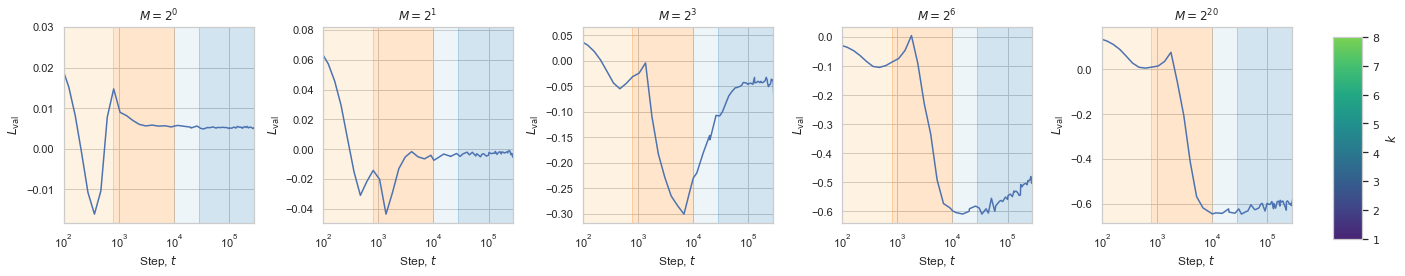

In [ ]:
from matplotlib import colors as mcolors

# LINE_PALETTE="viridis"
# ALPHA=1

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for token, log2_M in enumerate([0, 1, 3, 6, 20]):
    # Average across token colum
    ax = axes[token]
    functional_metrics_specific = functional_metrics.loc[functional_metrics.m == log2_M]

    icl_score = functional_metrics_specific.loc[functional_metrics_specific.token == 7, "loss"].values - functional_metrics_specific.loc[functional_metrics_specific.token == 4, "loss"].values
    sns.lineplot(x=steps, y=icl_score, alpha=ALPHA, ax=ax)
    ax.set_title(f"$M = 2^{{{log2_M}}}$")


for ax in axes.flatten():
    # ax.set_yscale('symlog')
    ax.set_xscale("log")
    ax.set_xlim(INIT_X, FINAL_X)
    ax.set_xlabel("Step, $t$")
    ax.set_ylabel("$L_\mathrm{val}$")
    ax.legend().remove()

add_milestones(axes, alpha=0.2) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


In [ ]:
wpriors_over_m = []
wprior_norms_over_m = []

for log2_M, config in tqdm(enumerate(configs)):
    run = Run(config)
    run.evaluator = ICLEvaluator(
        pretrain_dist=run.pretrain_dist,
        true_dist=run.true_dist,
        max_examples=config.task_config.max_examples,
        eval_batch_size=8192,
        seed=config.task_config.true_seed,
    )
    pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
        DEVICE
    )
    noise_std = pretrain_dist_noiseless.std
    pretrain_dist_noiseless.std = 0.

    ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D 
    wpriors = pretrain_dist_noiseless.task_distribution.tasks.mean(dim=0) # -> D
    wpriors_over_m.append(wpriors)
    wprior_norms_over_m.append(wpriors.norm())

In [ ]:
plt.plot(np.arange(21), [w.item() for w in wprior_norms_over_m])
plt.yscale("log")

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Average across token colum
for log2_M in range(21):
    functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_zero_norm"] = functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_zero"] / wprior_norms_over_m[log2_M].item()
    functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_prior_norm"] = functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_prior"] / wprior_norms_over_m[log2_M].item()

ax = axes[0]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss", hue="m", palette="viridis", alpha=0.5, ax=ax)

ax = axes[1]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_prior_norm", hue="m", palette="viridis", alpha=0.5, ax=ax)
ax.set_ylim(0.01, 1000)

ax = axes[2]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_zero_norm", hue="m", palette="viridis", alpha=0.5, ax=ax)
ax.set_ylim(0.01, 1000)

ax = axes[3]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="ood_loss", hue="m", palette="viridis", alpha=0.5, ax=ax)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(100, 400_000)
    ax.set_xlabel("Step, $t$")
    ax.legend().remove()

add_milestones(axes)

In [ ]:
m20_batch_losses_np = [m20_batch_losses[I:I + 100] for I in range(0, len(m20_batch_losses), 100)]
m20_batch_losses_np = np.array(m20_batch_losses_np)
m20_batch_losses_np.shape

In [ ]:
m20_batch_losses_cumsum = np.cumsum(m20_batch_losses_np, axis=1)
m20_batch_losses_cumavg = m20_batch_losses_cumsum / np.arange(1, 101)

m20_batch_losses_df = pd.DataFrame([{"step": step, "loss": loss, "b": b} for step, losses in zip(steps, m20_batch_losses_cumavg) for b, loss in enumerate(losses)])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 2, figsize=(20, 5))


ax = axes[0]
# First plot
m20_functional_metrics = functional_metrics_averages.loc[functional_metrics_averages.m == 20]
sns.lineplot(data=m20_batch_losses_df, x="step", y="loss", hue="b", palette=get_reduced_viridis_palette(100), alpha=0.5, ax=ax, legend=None)
sns.lineplot(data=m20_functional_metrics, x="step", y="loss", color=sns.color_palette('bright')[1], alpha=1, ax=ax, linewidth=2, label="$L_\mathrm{val}$")
ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\mathrm{Loss}$")
ax.set_xlim(INIT_X, FINAL_X)
ax.legend(loc="lower left")

ax=axes[1]

for b in range(100):
    m20_batch_loss_slope = d_dlogt(steps, m20_batch_losses_cumavg[:, b])
    m20_batch_losses_df.loc[m20_batch_losses_df.b == b, "slope"] = m20_batch_loss_slope

m20_val_loss_slopes = d_dlogt(steps, m20_functional_metrics.loss.values)
sns.lineplot(data=m20_batch_losses_df, x="step", y="slope", hue="b", palette=get_reduced_viridis_palette(100), alpha=0.5, ax=ax, legend=None)
sns.lineplot(data=m20_functional_metrics, x="step", y=m20_val_loss_slopes, color=sns.color_palette('bright')[1], alpha=0.75, ax=ax, linewidth=2, label="$\delta L_\mathrm{val}/\delta \log t$")
# ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta \mathrm{Loss}/\delta \log t$")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_ylim(-2, 1)
ax.legend(loc="lower left")

# Create an inset for the second plot

# ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')

# # Second plot (inset)
# sns.lineplot(data=m20_batch_losses_df, x="step", y="loss", hue="b", palette=get_reduced_viridis_palette(100), alpha=0.5, ax=ax_inset, legend=None)
# sns.lineplot(data=m20_functional_metrics, x="step", y="loss", color=sns.color_palette('deep')[3], alpha=1, ax=ax_inset)
# ax_inset.set_xlim(10_000, 250_000)
# ax_inset.set_ylim(1.75, 2.25)
# ax_inset.set_xscale("log")
# ax_inset.set_yscale('log')

add_milestones(axes)

# plt.show()

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", get_reduced_viridis_palette(100))

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=1, vmax=101), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = list(range(1, 101, 10)) + [100] # Positions for each color
tick_labels = ["1"] +  [f"${i}$" for i in range(10, 101, 10)]  # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$b$")


## Fitting

In [ ]:
def get_milestone_indices(steps, milestones):
    milestone_indices = []
    for step in steps:
        # Find the index of the milestone that the current step falls into
        index = next((i for i, milestone in enumerate(milestones) if milestone[0] <= step < milestone[1]), None)
        milestone_indices.append(index if index is not None else 'Out of defined milestones')
    return milestone_indices

milestones_of_steps = get_milestone_indices(steps, TRANSITIONS)

In [ ]:
run = Run(configs[0])
sum(p.numel() for p in run.model.parameters())

In [ ]:
from icl.analysis.baselines import dmmse_predictor, ridge_predictor
from icl.regression.tasks import TaskDistribution, DiscreteTaskDistribution, RegressionSequenceDistribution

class DMMSE(nn.Module):
    def __init__(self, dist: RegressionSequenceDistribution, noise_variance: float, learn_prior: bool = False):
        super().__init__()

        self.prior = dist.task_distribution
        self.noise_variance = nn.Parameter(torch.tensor(noise_variance))

        if learn_prior:
            self.tasks = nn.Parameter(self.prior.tasks)
            self.prior.tasks = self.tasks
    
    def forward(self, xs, ys):
        return dmmse_predictor(xs, ys, self.prior, self.noise_variance)


class Ridge(nn.Module):
    def __init__(self, noise_variance: float):
        super().__init__()

        self.noise_variance = nn.Parameter(torch.tensor(noise_variance))


    def forward(self, xs, ys):
        return ridge_predictor(xs, ys, self.noise_variance)


def fit_baseline_predictor(baseline: nn.Module, model: nn.Module, dist: RegressionSequenceDistribution, num_steps: int=1000, lr: float=0.0001, device: str = "cpu", batch_size=128, num_examples=8, verbose=True):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We're fitting just a single parameter (the noise variance)

    if verbose:
        losses = []
        sigmas = []

    for step in tqdm(range(num_steps), desc="Fitting..."):
        optimizer.zero_grad()

        # Get a batch of data
        xs, ys = dist.get_batch(batch_size=batch_size, num_examples=num_examples)
        xs = xs.to(device)
        ys = ys.to(device)

        # Get the predictions of the reference model
        with torch.no_grad():
            yhats = model(xs, ys)

        # Get the predictions of the baseline
        baseline_preds = baseline(xs, ys)

        # Update the baseline to be closer to the reference model
        loss = criterion(baseline_preds, yhats)
        loss.backward()
        optimizer.step()

        if verbose:
            losses.append(loss.item())
            sigmas.append(baseline.noise_variance.item())

    if verbose:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        plt.suptitle(f"Baseline fitting {baseline.__class__.__name__} on {dist.task_distribution.__class__.__name__}")
        axes[0].plot(losses)
        axes[0].set_title("Loss")
        axes[1].plot(sigmas)
        axes[1].set_title("Noise variance")
        plt.show()

    return baseline

def eval_delta_predictor(baseline: nn.Module, model: nn.Module, xs, ys, device: str = "cpu"):
    baseline_preds = baseline(xs, ys)
    preds = model(xs, ys)

    return nn.MSELoss()(baseline_preds, preds)

In [ ]:
from devinfra.utils.iterables import flatten_dict
from icl.train import Run
import random

fit_baseline_results = []

lr = 0.01
num_steps = 2_00
LEARN_PRIOR = False

for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    run.model.load_state_dict(checkpointer[-1]["model"])

    print("Evaluating", run.config.to_slug())

    batch_size = run.config.batch_size
    num_examples = run.config.task_config.max_examples
    
    noise = run.config.task_config.noise_variance

    learned_dmmse_pretrain = DMMSE(run.pretrain_dist, noise_variance=noise, learn_prior=LEARN_PRIOR)
    learned_ridge_pretrain = Ridge(noise_variance=noise)
    learned_ridge_true = Ridge(noise_variance=noise)

    init_learned_dmmse_pretrain_delta = eval_delta_predictor(learned_dmmse_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    init_learned_ridge_pretrain_delta = eval_delta_predictor(learned_ridge_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    init_learned_ridge_true_delta = eval_delta_predictor(learned_ridge_true, run.model, run.evaluator.true_xs, run.evaluator.true_ys, device=DEVICE)
    
    fit_baseline_predictor(learned_dmmse_pretrain, run.model, run.pretrain_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)
    fit_baseline_predictor(learned_ridge_pretrain, run.model, run.pretrain_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)
    fit_baseline_predictor(learned_ridge_true, run.model, run.true_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)

    learned_dmmse_pretrain_delta = eval_delta_predictor(learned_dmmse_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    learned_ridge_pretrain_delta = eval_delta_predictor(learned_ridge_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    learned_ridge_true_delta = eval_delta_predictor(learned_ridge_true, run.model, run.evaluator.true_xs, run.evaluator.true_ys, device=DEVICE)

    fit_baseline_results.append({
        "step": checkpointer.file_ids[-1],
        "config": run.config.to_slug(),
        "learned_dmmse_pretrain/init_delta": init_learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/init_delta": init_learned_ridge_pretrain_delta.item(),
        "learned_ridge_true/init_delta": init_learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/delta": learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/delta": learned_ridge_pretrain_delta.item(),
        "learned_ridge_true/delta": learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/delta_delta": learned_dmmse_pretrain_delta.item() - init_learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/delta_delta": learned_ridge_pretrain_delta.item() - init_learned_ridge_pretrain_delta.item(),        
        "learned_ridge_true/delta_delta": learned_ridge_true_delta.item() - init_learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/noise_variance": learned_dmmse_pretrain.noise_variance.item(),
        "learned_ridge_pretrain/noise_variance": learned_ridge_pretrain.noise_variance.item(),
        "learned_ridge_true/noise_variance": learned_ridge_true.noise_variance.item(),
        **flatten_dict(run.config.task_config.model_dump(), flatten_lists=True)
    })

    pp(fit_baseline_results[-1])



In [ ]:
baseline_fits_df = pd.DataFrame(fit_baseline_results)

# Create 2x3 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

plt.suptitle(
    "L2-H4-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000@t=499999"
)

# Define the labels for rows
row_labels = ['dmmse_pretrain', 'ridge_pretrain', 'ridge_true']

# Loop through the rows
for token, row_label in enumerate(row_labels):
    
    # First column: init_delta and delta
    ax1 = axes[token, 0]
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/init_delta', ax=ax1, label=f'{row_label} init_delta')
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/delta', ax=ax1, label=f'{row_label} delta')
    ax1.set_title(f"{row_label} init_delta and delta")
    ax1.set_xlabel('num_tasks')
    ax1.set_ylabel('Value')
    
    # Second column: noise_variance
    ax2 = axes[token, 1]
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/noise_variance', ax=ax2, label=f'{row_label} noise_variance')
    ax2.axhline(y=0.125, color='r', linestyle='-', label='True noise_variance')

    ax2.legend()

    ax2.set_title(f"{row_label} noise_variance")
    ax2.set_xlabel('num_tasks')
    ax2.set_ylabel('Noise Variance')

for ax in axes.flat:
    ax.set_xscale("log")

plt.tight_layout(rect=[0.1, 0.1, 1, 1])
plt.show()


## PCA

In [ ]:
def iter_enumerated_models(model, checkpointer, verbose=False):
    for file_id in tqdm(checkpointer.file_ids, desc="Iterating over checkpoints", disable=not verbose):
        model.load_state_dict(checkpointer.load_file(file_id)["model"])
        yield file_id, model

def iter_models(model, checkpointer, verbose=False):
    for file_id in tqdm(checkpointer.file_ids, desc="Iterating over checkpoints", disable=not verbose):
        model.load_state_dict(checkpointer.load_file(file_id)["model"])
        yield model

In [ ]:
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from icl.analysis.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        hooked_model = hook(model, *paths)
        return {k: convert_tensor(v, return_type) for k, v in hooked_model.run_with_cache(xs, ys)[1].items() if k in paths and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results

In [ ]:
# demo = Run(configs[2])
# demo_models = iter_models(demo.model, demo.checkpointer, verbose=True)

# demo_logits_pca_3, demo_logits_reduced_3  = get_pca_activations_trace(
#     demo_models, 
#     demo.evaluator.pretrain_xs, 
#     demo.evaluator.pretrain_ys, 
#     "token_sequence_transformer",
#     num_components=3
# )['token_sequence_transformer']

# steps = demo.checkpointer.file_ids

In [ ]:
from typing import Optional

def plot_sample_evolution(steps, samples, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Main plot
    sc = ax.scatter(samples[:, 0], samples[:, 1], c=steps, cmap='viridis', s=50, alpha=0.6)

    if connect_dots:
        ax.plot(samples[:, 0], samples[:, 1], c='black', alpha=0.2)

    plt.colorbar(sc, ax=ax, label='Steps')
    
    # Label some points
    total_samples = len(samples)
    step = total_samples // num_points_to_label
    for i in range(0, total_samples, step):
        sample_step = steps[i]
        ax.text(samples[i, 0], samples[i, 1], str(sample_step), fontsize=12, ha='right', va='bottom')
        
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)


def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Component')
    ax.set_ylabel('Variance')


def plot_sample_evolution_with_inset(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    plot_sample_evolution(steps, samples, title=title, num_points_to_label=num_points_to_label, ax=ax, connect_dots=connect_dots)

    axins = ax.inset_axes([0.7, 0.05, 0.25, 0.25])  # x, y, width, height
    axins.patch.set_alpha(0.5)
    plot_explained_variance(pca, ax=axins)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

    
def plot_multiple_slices(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    num_pca_components = samples.shape[-1]
    num_rows = num_pca_components - 1
    fig, ax = plt.subplots(num_rows, num_rows, figsize=(20, 20))

    fig.suptitle(title)

    for i in range(num_pca_components):
        for j in range(i):
            sc = ax[i-1, j].scatter(samples[:, i], samples[:, j], c=steps, cmap='viridis', s=50, alpha=0.6)
            ax[i-1, j].set_xlabel(f'Feature {i}')
            ax[i-1, j].set_ylabel(f'Feature {j}')
            ax[i-1, j].set_title(f'Feature {i} vs Feature {j}')

            if connect_dots:
                ax[i-1, j].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # Label some points
            total_samples = len(samples)
            step = total_samples // num_points_to_label
            for k in range(0, total_samples, step):
                sample_step = steps[k]
                ax[i-1, j].text(samples[k, i], samples[k, j], str(sample_step), fontsize=12, ha='right', va='bottom')

        for j in range(i + 1, num_rows):
            ax[i, j].axis('off')


    ax[0, -1].axis('on')
    plot_explained_variance(pca, ax=ax[0, -1])

    plt.colorbar(sc, ax=ax[0, -1], label='Steps')
    plt.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)

In [ ]:
for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    _steps = checkpointer.file_ids

    _pca, _logits_reduced = get_pca_activations_trace(
        iter_models(run.model, run.checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        "token_sequence_transformer",
        num_components=3
    )['token_sequence_transformer']
    
    plot_multiple_slices(
        _steps, 
        _logits_reduced, 
        _pca, 
        connect_dots=True, 
        title=config.to_latex(), 
        save=FIGURES / ("pca3-logits-" + config.to_slug(delimiter="-") + ".png")
    )

## Attention Entropies

In [ ]:
from typing import List, Union
from torchtyping import TensorType
from devinfra.utils.iterables import map_nested

from devinfra.utils.iterables import flatten_dict

from icl.train import Run

def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)

In [ ]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title="", save: Optional[str] = None, normalized=False, figsize=(20, 25), logx=False, logy=False):
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title)

    num_cols = num_blocks * 2
    num_rows = 1 + 1 + num_heads

    suffix = "" if not normalized else "_normalized"
    suffix_title = "" if not normalized else " (Normalized)"

    fig.set_facecolor('white')

    # Create subplot for mean entropy of first two blocks
    ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    block_cmap = sns.color_palette("viridis", num_blocks)

    for b in range(num_blocks):
        ax0.plot(df.step, df[f"block_{b}/mean{suffix}"], label=f"block_{b}", color=block_cmap[b])

    ax0.set_title("Blocks")
    ax0.set_xlabel("Step")
    ax0.set_ylabel(f"Entropy{suffix_title}")
    ax0.legend()

    # Create subplots for each block, showing entropy in different heads
    ax1 = [plt.subplot2grid((num_rows, num_cols), (1, i*2), colspan=2) for i in range(num_blocks)]
    head_cmap = sns.color_palette("viridis", num_heads)
    
    for b in range(num_blocks):
        ax1[b].set_title(f"Block {b}")
        ax1[b].set_xlabel("Step")
        ax1[b].set_ylabel(f"Entropy{suffix_title}")
        for h in range(num_heads):
            series = df[f"block_{b}/head_{h}/mean{suffix}"]
            ax1[b].plot(df.step, series, label=f"Head {h}", color=head_cmap[h])

    ax1[0].legend()

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + 2, i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0
    token_cmap = sns.color_palette("viridis", num_tokens)


    for h in range(num_heads):
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax2[ax_idx].set_title(f"Block {b} Head {h}")
                ax2[ax_idx].set_xlabel("Step")
                ax2[ax_idx].set_ylabel(f"Entropy{suffix_title}")

                for t in range(1-int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}{suffix}"]
                    ax2[ax_idx].plot(df.step, series, label=f"Token {t}", color=token_cmap[t])
                    
                ax_idx += 1

    ax2[0].legend()
    ax2[1].legend()

    for ax in [ax0, *ax1, *ax2]:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


In [ ]:
# demo = Run(configs[2])

# num_blocks = demo.config.task_config.num_layers
# num_heads = demo.config.task_config.num_heads
# num_tokens = demo.config.task_config.max_examples * 2

# df = get_attention_entropies_trace(
#     demo.checkpointer.file_ids,
#     iter_models(demo.model, demo.checkpointer, verbose=True), 
#     demo.evaluator.pretrain_xs, 
#     demo.evaluator.pretrain_ys, 
#     **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
# )

# demo_attn_entropy_slug = "attn-S-" + demo.config.to_slug(delimiter="-")

for normalized in (True, False):
    plot_attention_patterns(
        subdf, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=demo.config.to_latex(), 
        save=FIGURES / (demo_attn_entropy_slug + ".png"),
        figsize=(25, 25),
        normalized=normalized
    )

# df.to_csv(ANALYSIS / (demo_attn_entropy_slug + ".csv"))

In [ ]:
for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    
    num_blocks = run.config.task_config.num_layers
    num_heads = run.config.task_config.num_heads
    num_tokens = run.config.task_config.max_examples * 2

    subdf = get_attention_entropies_trace(
        checkpointer.file_ids,
        iter_models(run.model, checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
    )
    
    slug = "attn-S-" + run.config.to_slug(delimiter="-")

    plot_attention_patterns(
        subdf, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=run.config.to_latex(), 
        save=FIGURES / (slug + ".png"),
        figsize=(25, 25),
        normalized=True
    )

    subdf.to_csv(ANALYSIS / (slug + ".csv"))

# os.system('say "Your program has finished."')

In [ ]:
from icl.train import Run
demo = Run(configs[2])
attn_weights = demo.model.token_sequence_transformer.blocks[0].attention.attention.weight
attn_weights.shape


In [ ]:
numel_per_layer = attn_weights.numel()

def num_params_to_gb(num: int):
    return f"{num * (32 / 8) / (10 ** 9):.2f} Gb"

for num_blocks in [2, 4, 8]:
    for num_heads in [2, 4]:
        numel_per_head = numel_per_layer // num_heads

        within_head_cov_size = (numel_per_head ** 2)  * num_heads * num_blocks
        between_head_cov_size = (numel_per_head ** 2) * num_heads * num_heads * (num_blocks-1)

        full_cov_size = (numel_per_layer * num_blocks) ** 2

        reduction = full_cov_size - within_head_cov_size - between_head_cov_size

        print(f"\nL{num_blocks}H{num_heads}")
        print("Full:", f"{full_cov_size:,} ({num_params_to_gb(full_cov_size)})")
        print("Within heads:", f"{within_head_cov_size:,} ({num_params_to_gb(within_head_cov_size)})")
        print("Between heads:", f"{between_head_cov_size:,} ({num_params_to_gb(between_head_cov_size)})")
        print("Reduction:", f"-{reduction:,} (-{reduction/full_cov_size * 100:.2f}%)")

# attn_weights.numel(), f"{(32 // 8 * (attn_weights.numel() * 2 ) ** 2):,}", attn_weights.dtype

In [ ]:
def split_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int):
    W_split = W.view((embed_dim, num_heads, head_size * 3))
    
    for h in range(num_heads):
        yield tuple(W_split[:, h, i*head_size:(i+1)*head_size] for i in range(3))


def plot_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int, subtitles=("$W_Q^{(h)}$", "$W_K^{(h)}$", "$W_V^{(h)}$"), title="", save: Optional[str] = None):
    heads = list(split_attn_weights(W, num_heads, embed_dim, head_size))

    fig, axs = plt.subplots(num_heads, 3, figsize=(25, 10))
    plt.suptitle(title)

    for h, head in enumerate(heads):
        axs[h, 0].set_ylabel(f"Head {h}\nHead Size")

        for i, mat in enumerate(head):
            axs[h, i].matshow(mat.detach().cpu().numpy().T, cmap='viridis') 

    for i, subtitle in enumerate(subtitles):
        axs[0, i].set_title(subtitle)
        axs[-1, i].set_xlabel("Embedding Dimension")

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()


def plot_attn_head_weights(head: torch.Tensor, embed_dim, head_size: int, title="", subtitles=("$W_Q$", "$W_K$", "$W_V$"), save: Optional[str] = None):
    head_Ex3c = head.view((embed_dim, head_size * 3))
    q, k, v = tuple(head_Ex3c[:, i*head_size:(i+1)*head_size].detach().cpu().numpy() for i in range(3))

    fig, ax = plt.subplots(1, 3, figsize=(30, 3.5))
    plt.suptitle(title)

    for i, (mat, subtitle) in enumerate(zip((q, k, v), subtitles)):
        ax[i].set_title(subtitle)
        ax[i].matshow(mat.T, cmap='viridis')
        ax[i].set_xlabel("Embedding Dimension")
        ax[i].set_ylabel("Head Size")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()

In [ ]:
def plot_attn_eigencomponents(evecs, evals, slug: Optional[str] = None):
    for i in range(1, 1 + len(evals)):
        attn0, attn1 = evecs[:evecs.shape[0]//2, -i], evecs[evecs.shape[0]//2:, -i]

        for layer, attn in enumerate((attn0, attn1)):
            plot_attn_weights(
                torch.Tensor(attn), 
                num_heads=4,
                embed_dim=64, 
                head_size=16, 
                title=f"Eigenvector {i-1} of covariance matrix within attention layer 0 ($\lambda_{i-1}={evals[-i]}$)",
                subtitles=(f"$u_{{Q,{i-1}}}^{{({layer})}}$", f"$u_{{K,{i-1}}}^{{({layer})}}$", f"$u_{{V,{i-1}}}^{{({layer})}}$"),
                save=(FIGURES / (f"cov-attn{layer}-evec{i-1}-" + slug + ".png") if slug else None)
            )

In [ ]:
plot_attn_weights(attn0, 4, 64, 16, title="Attention layer 0")

num_heads = 4
attn0_view = attn0.view((64, num_heads, 16 * 3))
heads = [attn0_view[:, h, :] for h in range(num_heads)]
full_head_size = 16 * 3 * 64
pseudo_cov = heads[0].reshape((full_head_size, 1)) * heads[1].reshape((1, full_head_size)) 
head_evals, head_evecs = eigsh(pseudo_cov.detach().cpu().numpy(), k=3, which="LM")
del pseudo_cov


print(head_evals)
plot_attn_head_weights(
    torch.Tensor(head_evecs[:, -1]), 
    64, 
    16, 
    title="Principal eigenvalue of covariance matrix within head 1",
    subtitles=("$u_{Q,1}^{(1)}$", "$u_{K,1}^{(1)}$", "$u_{V,1}^{(1)}$")   
)


In [ ]:
from icl.analysis.sample import make_slt_evals

def generate_slt_observables(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **kwargs
):
    trainset = torch.utils.data.TensorDataset(xs, ys)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(xs))
    slt_evals = make_slt_evals(
        dataset=trainset,
        loader=trainloader,
        **kwargs
    )

    for step, model in zip(steps, models):
        yield step, slt_evals(model)

In [ ]:
print(checkpointer.file_ids)

In [ ]:
def plot_learning_coeff_over_time(steps, lcs, lc_stds, title="", save: Optional[str] = None):

    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.set_title(title)

    # Plot mean values as a line
    ax.plot(steps, lcs, 'o-', linewidth=2)
    
    # Add shaded area for error
    ax.fill_between(steps, lcs - lc_stds, lcs + lc_stds, color='gray', alpha=0.4)

    # Labels and scales
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"$\hat\lambda$")
    
    fig.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()


def plot_cov_evals_over_time(steps, *eval_traces, title="", save: Optional[str] = None):

    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.set_title(title)

    # Plot mean values as a line
    for i, eval_trace in enumerate(eval_traces):
        ax.plot(steps, eval_trace, 'o-', label=f"Eigenvalue {i}", linewidth=2)
    
    # Labels and scales
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"$\hat\lambda$")
    
    # Show legend
    ax.legend()

    fig.tight_layout()
    
    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()

In [ ]:
import yaml
from scipy.sparse.linalg import eigsh



for log2_M in MS:
    wandb.init(entity="devinterp", project="icl")

    gc.collect()
    torch.cuda.empty_cache()

    log2_m = int(np.log2(log2_M))
    config, checkpointer = configs[log2_m], checkpointers[log2_m]
    run = Run(config)

    xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
    trainset = torch.utils.data.TensorDataset(xs, ys)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(xs))
    observables_over_time = []
    
    slt_evals = make_slt_evals(
        dataset=trainset,
        loader=trainloader,
        cores=1,
        lr=1e-5,
        num_draws=100,
        elasticity=1.,
        num_chains=20,
        device="cuda",
        covariance_paths=[
            f"token_sequence_transformer.blocks.{b}.attention.attention"
            for b in range(run.config.task_config.num_layers)
        ],
    )

    slug = run.config.to_slug(delimiter="-")

    min_step = -1

    if os.path.exists(ANALYSIS / f"cov-tmp-{slug}.pt"):
        min_step, observables = torch.load(ANALYSIS / f"cov-tmp-{slug}.pt")
        print(f"Loaded observables from previous step {min_step} from {ANALYSIS / f'cov-tmp-{slug}.pt'}")
    
    for step in STEPS:
        # if step > min_step:
        run.model.load_state_dict(checkpointer.load_file(step)["model"])
        observables = slt_evals(run.model)
        torch.save((step, observables), ANALYSIS / f"cov-tmp-{slug}.pt")

        cov = observables.pop("covariance")
        evals, evecs = eigsh(cov, k=K, which='LM')

        for token in range(1, 1+K):
            observables[f"cov-eval/{token-1}"] = evals[-token]

        observables_over_time.append(observables)
        del cov
        pp(observables)
        plot_attn_eigencomponents(evecs, evals, slug=slug + f"@t={step}")

    plot_cov_evals_over_time(
        STEPS,
        *[[o[f"cov-eval/{k}"] for o in observables_over_time] for k in K],
        title=run.config.to_latex(),
        save=FIGURES / f"cov-eval-of-t-{slug}.png"
    )

    plot_learning_coeff_over_time(
        STEPS,
        [o["mean"] for o in observables_over_time],
        [o["std"] for o in observables_over_time],
        title=run.config.to_latex(),
        save=FIGURES / f"lc-of-t-{slug}.png"
    )

    observables_df = pd.DataFrame(observables_over_time)
    observables_df.to_csv(ANALYSIS / f"cov/cov-{slug}.csv")
    os.remove(ANALYSIS / f"cov-tmp-{slug}.pt")

In [ ]:
print(observables_over_time[0].keys())
plot_cov_evals_over_time(
    STEPS,
    [o["cov-eval/0"] for o in observables_over_time],
    [o["cov-eval/1"] for o in observables_over_time],
    title=run.config.to_latex(),
    save=FIGURES / f"cov-eval-of-t-{slug}.png"
)

plot_learning_coeff_over_time(
    STEPS,
    np.array([o["mean"] for o in observables_over_time]),
    np.array([o["std"] for o in observables_over_time]),
    title=run.config.to_latex(),
    save=FIGURES / f"lc-of-t-{slug}.png"
)

observables_df = pd.DataFrame(observables_over_time)
observables_df.to_csv(ANALYSIS / f"cov/cov-{slug}.csv")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
del run, trainset, trainloader
del slt_evals
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
covariances = observables.pop("covariances")
evals, evecs = eigsh(covariances, k=3, which='LM')

for token, (eval, evec) in enumerate(zip(evals, evecs.T)):
    slug = f"cov-u{token}" + run.config.to_slug(delimiter="-") + f"@t={step}"
    attn0, attn1 = evec.split(64 * 16 * 3)
    

# TODO: Need to rename the new files otherwise you can't tell easily tell what step they come from.


os.system('say "Your program has finished."')


In [ ]:
import yaml
from scipy.sparse.linalg import eigsh


# wandb.init(entity="devinterp", project="icl")

for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    observables_over_time = []
    
    for step, observables in generate_slt_observables(
        checkpointer.file_ids,
        iter_models(run.model, checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        cores=4,
        lr=1e-5,
        num_draws=100,
        elasticity=1.,
        num_chains=20,
        device="cuda",
        covariance_paths=[
            f"token_sequence_transformer.blocks.{b}.attention.attention"
            for b in range(run.config.task_config.num_layers)
        ]
    ):
        # wandb.log(observables, step=step)
        observables["step"] = step
        covariances = observables.pop("covariances")

        # I only want the two largest eigenvalues in evals and evecs
        covariances = np.linalg.eigvalsh(covariances)
        evals, evecs = eigsh(covariances, k=3, which='LM')
        
        observables_over_time.append(observables)
        print(yaml.dump({
            **observables,
            "covariances": covariances.shape
        }))

        raise NotImplementedError("TODO: Save covariances")

    subdf = pd.DataFrame(observables_over_time)
    slug = "slt-" + run.config.to_slug(delimiter="-")
    subdf.to_csv(ANALYSIS / (slug + ".csv"))

# wandb.finish()
os.system('say "Your program has finished."')

## Activations

In [ ]:
from pathlib import Path
import shutil
from icl.config import ICLConfig

import os
from PIL import Image

def gather_images_side_by_side(folder, save: Optional[str] = None, delete: bool = True):
    """
    Assumes folder contains folders that contain pngs. 
    """
    folder = Path(folder)
    folder_paths = folder.glob("*")

    # Create a dictionary to store images by filename
    images_by_filename = {}

    if save:
        save = Path(save)

        if not os.path.exists(save):
            os.makedirs(save)

    # Load images from each folder and organize them by filename
    for folder_path in folder_paths:
        filenames = [f for f in os.listdir(folder_path) if f.endswith('.png')] 
        for filename in filenames:
            img = Image.open(os.path.join(folder_path, filename))
            if filename in images_by_filename:
                images_by_filename[filename].append(img)
            else:
                images_by_filename[filename] = [img]

    # Create comparison images for each unique filename
    for filename, image_list in images_by_filename.items():
        # Calculate the width and height of the result image
        width = sum(img.width for img in image_list)
        height = max(img.height for img in image_list)

        # Create a new image for the comparison
        result_image = Image.new('RGB', (width, height))

        # Paste images side by side
        x_offset = 0
        for img in image_list:
            result_image.paste(img, (x_offset, 0))
            x_offset += img.width

        # Display or save the result image
        if save: 
            result_image.save(save / filename)  # You can replace this with result_image.save() to save the comparison images

    if delete:
        # Delete the temporary folder
        shutil.rmtree(folder)


def plot_activations(config: ICLConfig, activations: Dict[str, torch.Tensor], save: Optional[str] = None):
    B = 1
    E = config.task_config.embed_size
    T = 2 * config.task_config.max_examples
    H = config.task_config.num_heads

    def optionally_rotate(x, name):
        if len(x.shape) != 2:
            raise ValueError("Tensor should have two dimensions.")

        if x.shape[0] > x.shape[1]:
            return x.T, f"{name}.T"
        
        return x, name 

    def separate_attention(qkv: TensorType["B", "T", "C"], num_heads: int, batch_size: int, head_size: int, num_tokens: int):
        return (qkv   
            .view(batch_size, num_tokens, num_heads, 3*head_size)
            .transpose(-2, -3)     
            .split(head_size, dim=-1)
        )

    if save:
        save = Path(save)

        if not os.path.exists(save):
            os.makedirs(save)

    for location, v in activations.items():
        activation_slice = v[0]

        if location.endswith("attention.attention"):
            q, k, v = separate_attention(v, num_heads=H, batch_size=B, head_size=E//H, num_tokens=T)
            qk = q @ k.transpose(-2, -1)
            q, k, qk, v = q[0], k[0], v[0], qk[0]
            
            fig, axs = plt.subplots(H, 4, figsize=(15, 15))

            for j, (name, x) in enumerate(zip(["Q", "K", "QK", "V"], [q, k, qk, v])):
                for h in range(H):
                    ax = axs[h, j]
                    im = ax.matshow(x[h].detach().to("cpu").numpy())
                    ax.set_title(f"{h}.{name}")
                    # fig.colorbar(im, ax=ax)

            plt.suptitle(location)
            plt.tight_layout()

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

                del fig
                del axs

        elif len(activation_slice.shape) == 2:
            fig = plt.figure()

            x, location = optionally_rotate(activation_slice, location)
            plt.matshow(x.detach().to("cpu").numpy())
            plt.title(f"{location}")
            # fig.colorbar(im)

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

                del fig


        elif len(activation_slice.shape) == 3:  # [heads, xs, ys]
            heads, xs, ys = activation_slice.shape
            fig, axs = plt.subplots(1, heads, figsize=(15, 15))

            for j in range(heads):
                ax = axs[j]
                x, name = optionally_rotate(activation_slice[j], str(j))
                im = ax.matshow(x.detach().to("cpu").numpy())
                ax.set_title(f"{name}")
                # fig.colorbar(im, ax=ax)
            
            plt.suptitle(f"{location}.#")
            plt.tight_layout()

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

            del fig
            del axs

        else:
            raise ValueError("Unsupported number of dimensions.")


def compare_activations(config: ICLConfig, model, x: TensorType["B", "D"], y: TensorType["B", 1], save: Optional[str] = None, names: Optional[List[str]] = None):
    B = len(x)
    hooked_model = hook(model)

    activations = {}
    output, activations_ = hooked_model.run_with_cache(x, y)
    activations["x"] = x
    activations["y"] = y
    activations["output"] = output
    activations.update(activations_)

    def activations_per_sample(activations, index, keep_batch_dim=False):
        if keep_batch_dim:
            print({k: type(v) for k, v in activations.items()})
            return {k: v[index].unsqueeze(0) for k, v in activations.items() if v is not None}
        
        return {k: v[index] for k, v in activations.items() if v is not None}

    tmp_folder = Path("tmp")

    names = names or list(map(str, range(B)))

    for (name, b) in zip(names, range(B)):
        activations_b = activations_per_sample(activations, b, keep_batch_dim=True)
        plot_activations(config, activations_b, save=tmp_folder / str(name))

    gather_images_side_by_side(tmp_folder, save=save, delete=True)    

In [ ]:
demo = Run.create_and_restore(configs[2])
compare_activations(demo.config, demo.model, demo.evaluator.pretrain_xs[:3], demo.evaluator.pretrain_ys[:3], save=FIGURES / "demo", names=["$x_0$", "$x_1$", "$x_2$"])
# gather_images_side_by_side("tmp", save=FIGURES/"demo", delete=True)    

In [ ]:
# Plot a few samples for each model at the end of training
from icl.train import Run

NUM_SAMPLES = 4

for config, checkpointer in zip(configs, checkpointers):
    run = Run.create_and_restore(config)
    
    sample_names = [f"$x_{i}$" for i in range(NUM_SAMPLES)]
    slug = "activations-" + run.config.to_slug(delimiter="-")

    compare_activations(
        run.config, 
        run.model, 
        run.evaluator.pretrain_xs[:NUM_SAMPLES], 
        run.evaluator.pretrain_ys[:NUM_SAMPLES], 
        save=FIGURES / slug, 
        names=sample_names
    )

In [ ]:
print(checkpointer.file_ids)

In [ ]:
# Plot a few samples for a subset of models over training

MS = [1, 4, 64, 2**10, 2**20]
STEPS = [0, 1_805, 3_084, 15_381, 26_279, 100_262, 153_061, 193_877, 255_102, 306_122, 408_163]

for log2_M in MS:
    log2_m = int(np.log2(log2_M))
    config, checkpointer = configs[log2_m], checkpointers[log2_m]
    run = Run(config)

    for step in STEPS:
        run.model.load_state_dict(checkpointer.load_file(step)["model"])

        sample_names = [f"$x_{i}$" for i in range(NUM_SAMPLES)]
        slug = "activations-" + run.config.to_slug(delimiter="-") + f"@t={step}"

        # TODO: Need to rename the new files otherwise you can't tell easily tell what step they come from.
        compare_activations(
            run.config, 
            run.model, 
            run.evaluator.pretrain_xs[:NUM_SAMPLES], 
            run.evaluator.pretrain_ys[:NUM_SAMPLES], 
            save=FIGURES / slug, 
            names=sample_names
        )
        
        os.system('say "Your program has finished."')

# LLC hyperparams

In [ ]:
import yaml
import wandb
from icl.config import get_config
import pandas as pd
from tqdm import tqdm
from devinfra.utils.iterables import flatten_dict

api = wandb.Api()
# sweep = api.sweep("devinterp/icl-llc/d3ctawc7")  # L2H4
sweep = api.sweep("devinterp/icl-llc/ebu13rjw")  # L4H4

def wandb_run_to_df(run):
    history_df = run.history()
    config_dict = get_config(**run.config).model_dump()
    config_dict["analysis_config"] = run.config["analysis_config"]

    del config_dict["logger_config"]
    del config_dict["checkpointer_config"]

    config_dict_flat = flatten_dict(config_dict, flatten_lists=True)
    
    for k, v in config_dict_flat.items():
        if isinstance(v, tuple):
            # Repeat the tuple for the entire length of the DataFrame
            v = [v] * len(history_df)
            
        history_df[k] = v

    return history_df


def wandb_runs_to_df(runs):
    return pd.concat([wandb_run_to_df(run) for run in tqdm(runs, desc="Converting runs to dfs")])


subdf = wandb_runs_to_df(sweep.runs)

In [ ]:
num_layers = 2
num_heads = 4
# df.to_csv("../analysis/L4H4-llc-grid-search.csv") 
subdf = pd.read_csv(f"../analysis/L{num_layers}H{num_heads}-llc-grid-search.csv")
# df = pd.read_csv("../analysis/L2H4-llc-grid-search.csv")

In [ ]:
# del df
subdf.columns

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# Get unique values for lrs, elasticitys, and num_tasks
num_chains = 25
unique_lrs = subdf['analysis_config/lr'].unique()
unique_elasticities = subdf['analysis_config/elasticity'].unique()
unique_num_tasks = subdf['task_config/num_tasks'].unique()

show_std = False

# Sort for visual consistency
unique_lrs.sort()
unique_lrs = unique_lrs[:-1]
unique_elasticities.sort()
unique_num_tasks.sort()

prefix = "" # "thresholded-" # ""
Prefix = "" # "Thresholded " # ""

# Initialize colormap
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
fig.set_facecolor('white')
fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L={num_layers}, H={num_heads}, t=500k$")

# Loop through the grid
for token, lr in enumerate(unique_lrs):
    for j, elasticity in enumerate(unique_elasticities):
        ax = axes[token, j]

        # Filter DataFrame for specific lr and elasticity
        filtered_df = subdf[(subdf['analysis_config/lr'] == lr) & (subdf['analysis_config/elasticity'] == elasticity)]

        for log_num_tasks in unique_num_tasks:
            task_specific_df = filtered_df[filtered_df['task_config/num_tasks'] == log_num_tasks]

            # Sort by 'num_draws' for plotting
            task_specific_df = task_specific_df.sort_values('_step')

            # Calculate color based on log2(num_tasks)
            color = cmap(np.log2(log_num_tasks) / np.log2(max(unique_num_tasks)))

            # Plot using Seaborn for better aesthetics
            filtered_data = task_specific_df[(task_specific_df[f'{prefix}llc/mean'] != "NaN") & (task_specific_df[f'{prefix}llc/mean'] <1_000)]
            sns.lineplot(x='_step', y=f'{prefix}llc/mean', data=filtered_data, ax=ax, label=f'_M={log_num_tasks}', color=color)
            
            if show_std:
                mean_val = task_specific_data[f'{prefix}llc/mean']
                std_val = task_specific_data[f'{prefix}llc/std']

                if not np.isnan(mean_val) and not np.isnan(std_val) and np.isfinite(mean_val) and np.isfinite(std_val):
                    lower = mean_val - std_val
                    upper = mean_val + std_val
                else:
                    lower = np.nan
                    upper = np.nan

                ax.fill_between(task_specific_data['_step'], lower, upper, color=color, alpha=0.1)

        ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}$")
        ax.set_xlabel(r"$t_\mathrm{SGLD}$")
        ax.set_ylabel(r"$\hat\lambda$")

# plt.legend()
plt.tight_layout()

# Plot a color bar to the right of the grid
norm = Normalize(vmin=0, vmax=20)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
# cbar.ax.set_clim(0, 20)
cbar.ax.set_ylabel(r"$\log_2(M)$")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()


if show_std:
    plt.savefig(f"../figures/llc-grid-over-t-L{num_layers}_H{num_heads}.png")
else:
    plt.savefig(f"../figures/llc-grid-over-t-L{num_layers}_H{num_heads}.png")
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

for M in range(0, 21, 3):
    upper_M = min(21, M + 5)

    data = subdf[(subdf['task_config/num_tasks'] >= 2**M) & (subdf['task_config/num_tasks'] < 2**upper_M)]

    # Get unique values for lrs, elasticitys, and num_tasks
    num_chains = 25
    unique_lrs = data['analysis_config/lr'].unique()
    unique_elasticities = data['analysis_config/elasticity'].unique()
    unique_num_tasks = data['task_config/num_tasks'].unique()

    show_std = True

    # Sort for visual consistency
    unique_lrs.sort()
    unique_lrs = unique_lrs[:-1]
    unique_elasticities.sort()
    unique_num_tasks.sort()

    # Initialize colormap
    cmap = plt.cm.viridis

    # Create subplots
    fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
    fig.set_facecolor('white')

    prefix = "thresholded-" # ""
    Prefix = "Thresholded " # ""

    fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L=2, H=4$\n$M \in [{2**M}, {2**upper_M}, t=500k)$")

    # Loop through the grid
    for token, lr in enumerate(unique_lrs):
        for j, elasticity in enumerate(unique_elasticities):
            ax = axes[token, j]

            # Filter DataFrame for specific lr and elasticity
            filtered_data = data[(data['analysis_config/lr'] == lr) & (data['analysis_config/elasticity'] == elasticity)]

            for log_num_tasks in unique_num_tasks:
                task_specific_data = filtered_data[filtered_data['task_config/num_tasks'] == log_num_tasks]

                # Sort by 'num_draws' for plotting
                task_specific_data = task_specific_data.sort_values('_step')

                # Calculate color based on log2(num_tasks)
                color = cmap((np.log2(log_num_tasks)-M)/5)

                # Plot using Seaborn for better aesthetics
                more_filtered_data = task_specific_data.loc[(task_specific_data[f'{prefix}llc/mean'] != "NaN") & (task_specific_data[f'{prefix}llc/std'] != "NaN")]
                sns.lineplot(x='_step', y=f'{prefix}llc/mean', data=more_filtered_data, ax=ax, label=f'_M={log_num_tasks}', color=color)

                if show_std:
                    # Print types of each cell in more_filtered_data
                    steps = more_filtered_data['_step'].to_numpy()
                    means = more_filtered_data[f"{prefix}llc/mean"].to_numpy()
                    stds = more_filtered_data[f"{prefix}llc/std"].to_numpy()
                    means = pd.to_numeric(means, errors='coerce')
                    stds = pd.to_numeric(stds, errors='coerce')

                    ax.fill_between(steps, means-stds, means+stds, color=color, alpha=0.2)
                    
            ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}$")
            ax.set_xlabel(r"$t_\mathrm{SGLD}$")
            ax.set_ylabel(r"$\hat\lambda$")

    # plt.legend()
    plt.tight_layout()

    # Plot a color bar to the right of the grid
    norm = Normalize(vmin=M, vmax=upper_M)
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
    # cbar.ax.set_clim(0, 20)
    cbar.ax.set_ylabel(r"$\log_2(M)$")
    cbar.locator = MaxNLocator(integer=True)
    cbar.update_ticks()


    plt.savefig(f"../figures/llc-grid-search-M{M}-{upper_M}.png")
    plt.show()

In [ ]:
# Let's plot this as a function of M on the x axis

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# Get unique values for lrs, elasticitys, and num_tasks
num_chains = 25
unique_lrs = subdf['analysis_config/lr'].unique()
unique_elasticities = subdf['analysis_config/elasticity'].unique()
unique_num_tasks = subdf['task_config/num_tasks'].unique()

num_layers = 4
num_heads = 4

show_std = True

# Sort for visual consistency
unique_lrs.sort()
# unique_lrs = np.array([lr for lr in unique_lrs if lr <= 0.0001])
unique_lrs = unique_lrs[:-2]
unique_elasticities.sort()
unique_num_tasks.sort()

unique_num_tasks = np.array([2**m for m in range(0, 21)])

prefix = "" # "thresholded-" 
Prefix = "" # "Thresholded " 

# Initialize colormap
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
fig.set_facecolor('white')
fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L={num_layers}, H={num_heads}, t=500k$")

steps = np.array([9, 29, 99, 299, 999])

# Loop through the grid
for token, lr in enumerate(unique_lrs):
    for j, elasticity in enumerate(unique_elasticities):
        ax = axes[token, j]

        # Filter DataFrame for specific lr and elasticity
        filtered_df = subdf[(subdf['analysis_config/lr'] == lr) & (subdf['analysis_config/elasticity'] == elasticity)]

        for step in steps:
            # Find the closest step to the desired step for each num_tasks 
            # Problem is wandb sometimes drops a log.
            closest_step_df = filtered_df.groupby('task_config/num_tasks').apply(lambda x: x.iloc[(x['_step']-step).abs().argsort()[:1]]).reset_index(drop=True)

            # Sort by 'num_draws' for plotting
            closest_step_df = closest_step_df.sort_values('task_config/num_tasks')

            # Calculate color based on log2(num_tasks)
            color = cmap(step / 999)

            # Plot using Seaborn for better aesthetics
            filtered_data = closest_step_df[closest_step_df[f'{prefix}llc/mean'] != "NaN"]
            log_num_tasks = filtered_data['task_config/num_tasks'].to_numpy()
            log_num_tasks = pd.to_numeric(log_num_tasks, errors='coerce')
            means = filtered_data[f"{prefix}llc/mean"].to_numpy()
            means = pd.to_numeric(means, errors='coerce')

            ax.plot(log_num_tasks, means, label=f'_step={step}', color=color)

            if show_std:
                stds = filtered_data[f"{prefix}llc/std"].to_numpy()
                stds = pd.to_numeric(stds, errors='coerce')
                ax.fill_between(log_num_tasks, means-stds, means+stds, color=color, alpha=0.2)
                
        ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}$")
        ax.set_xlabel(r"$M$")
        ax.set_xscale("log")
        ax.set_xticks([2**m for m in range(0, 21, 4)], [f"$2^{{{m}}}$" for m in range(0, 21, 4)])
        ax.set_ylabel(r"$\hat\lambda$")

# plt.legend()
plt.tight_layout()

# Plot a color bar to the right of the grid
norm = Normalize(vmin=0, vmax=1000)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
# cbar.ax.set_clim(0, 20)
cbar.ax.set_ylabel(r"$t_\mathrm{SGLD}$")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()


if show_std:
    plt.savefig("../figures/llc-grid-search-std.png")
else:
    plt.savefig("../figures/llc-grid-search.png")
plt.show()

In [ ]:
# Let's plot this as a function of M on the x axis

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# Get unique values for lrs, elasticitys, and num_tasks
num_chains = 25
unique_lrs = subdf['analysis_config/lr'].unique()
unique_elasticities = subdf['analysis_config/elasticity'].unique()
unique_num_tasks = subdf['task_config/num_tasks'].unique()

num_layers = 2
num_heads = 4

show_std = True

# Sort for visual consistency
unique_lrs.sort()
unique_lrs = unique_lrs[:-1]
# unique_lrs = np.array([lr for lr in unique_lrs if lr <= 0.0001])
unique_elasticities.sort()
unique_num_tasks.sort()

unique_num_tasks = np.array([2**m for m in range(0, 21)])

prefix = "" # "thresholded-" 
Prefix = "" # "Thresholded " 

# Initialize colormap
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
fig.set_facecolor('white')
fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L={num_layers}, H={num_heads}, t=500k$")

# Loop through the grid
for token, lr in enumerate(unique_lrs):
    for j, elasticity in enumerate(unique_elasticities):
        ax = axes[token, j]

        # Filter DataFrame for specific lr and elasticity
        filtered_df = subdf[(subdf['analysis_config/lr'] == lr) & (subdf['analysis_config/elasticity'] == elasticity)]

        # Get the last step for each num_tasks
        last_step_df = filtered_df.groupby('task_config/num_tasks').last().reset_index()

        # Calculate color based on log2(num_tasks)
        color = sns.color_palette()[0]

        # Plot using Seaborn for better aesthetics
        filtered_data = last_step_df[last_step_df[f'{prefix}llc/mean'] != "NaN"]
        log_num_tasks = filtered_data['task_config/num_tasks'].to_numpy()
        log_num_tasks = pd.to_numeric(log_num_tasks, errors='coerce')
        means = filtered_data[f"{prefix}llc/mean"].to_numpy()
        means = pd.to_numeric(means, errors='coerce')

        ax.plot(log_num_tasks, means, label=f'_step={step}', color=color)

        if show_std:
            stds = filtered_data[f"{prefix}llc/std"].to_numpy()
            stds = pd.to_numeric(stds, errors='coerce')
            ax.fill_between(log_num_tasks, means-stds, means+stds, color=color, alpha=0.2)
                
        ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}, t_\mathrm{{SGLD}}=1000$")
        ax.set_xlabel(r"$M$")
        ax.set_xscale("log")
        ax.set_xticks([2**m for m in range(0, 21, 4)], [f"$2^{{{m}}}$" for m in range(0, 21, 4)])
        ax.set_ylabel(r"$\hat\lambda$")

# plt.legend()
plt.tight_layout()

# Plot a color bar to the right of the grid
# norm = Normalize(vmin=0, vmax=1000)
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
# cbar.ax.set_clim(0, 20)
# cbar.ax.set_ylabel(r"$t_\mathrm{SGLD}$")
# cbar.locator = MaxNLocator(integer=True)
# cbar.update_ticks()


if show_std:
    plt.savefig("../figures/llc-grid-search-std.png")
else:
    plt.savefig("../figures/llc-grid-search.png")
plt.show()

In [ ]:
import yaml
import wandb
from icl.config import get_config
import pandas as pd
from tqdm import tqdm
from devinfra.utils.iterables import flatten_dict

api = wandb.Api()
# sweep = api.sweep("devinterp/icl-llc/d3ctawc7")  # L2H4
sweep = api.sweep("devinterp/icl-llc/eli1wlds")  # L4H4

def wandb_run_to_df(run):
    history_df = run.history()
    config_dict = get_config(**run.config).model_dump()
    config_dict["analysis_config"] = run.config["analysis_config"]

    del config_dict["logger_config"]
    del config_dict["checkpointer_config"]

    config_dict_flat = flatten_dict(config_dict, flatten_lists=True)
    
    for k, v in config_dict_flat.items():
        if isinstance(v, tuple):
            # Repeat the tuple for the entire length of the DataFrame
            v = [v] * len(history_df)
            
        history_df[k] = v

    return history_df


def wandb_runs_to_df(runs):
    return pd.concat([wandb_run_to_df(run) for run in tqdm(runs, desc="Converting runs to dfs")])


subdf = wandb_runs_to_df(sweep.runs)

In [ ]:
num_layers = 2
num_heads = 4

name = f"../analysis/L{num_layers}H{num_heads}-llc-grid-search-batches.csv"
subdf.to_csv(name) 
# subdf = pd.read_csv(name)
# df = pd.read_csv("../analysis/L2H4-llc-grid-search.csv")

In [ ]:
subdf.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_llc_estimation_hyperparams_sweep(observations_df, y="llc/mean", row="analysis_config/lr", col="analysis_config/batch_size"):
    fig = plt.figure(figsize=(15, 6))

    # Get rid of the NaNs
    observations_df = observations_df[observations_df[y] != "NaN"]
    observations_df = observations_df.rename(columns={"task_config/num_tasks": "# Tasks",
                                                      "analysis_config/lr": "Learning Rate",
                                                      "analysis_config/batch_size": "Batch Size"})

    g = sns.FacetGrid(observations_df, col="Batch Size", row="Learning Rate", sharey=False)
    g.map_dataframe(sns.lineplot, x="# Tasks", y=y)
    g.add_legend()
    g.set(xscale="log", yscale="log")
    # g.set(xscale="log", yscale="linear")

    plt.suptitle("Covariance estimation hyperparameter sweep")
    g.fig.tight_layout()
    plt.show()


plot_llc_estimation_hyperparams_sweep(subdf)

## Gradient noise as a function of batch size

The Gaussian noise term of size $\epsilon$ should dominate the gradient noise due to computing gradients over batches of size $m$ in the SGLD step. We want the variance in the gradient norm $g_m$ to be small compared to the variance in the Gaussian noise. 

Knowing $g_m$ as a function of batch size is useful because it establishes a lower bound on batch size for a given choice of $(\beta, n)$:

$$
g_n \ll \frac{2}{\beta n}
$$

Note: more precisely, we should be looking at the maximum eigenvalue of the gradient norm covariance matrix. This is expensive for large models, so we'll make a simplification and just look at the variance in gradient norm instead. We could do better.


### Where to calibrate?

We'll do the gradient noise check at two spots:
- Where the gradient norm is maximal (early in training)
- Where the learning coefficient estimates are maximal (~10k steps)

In [ ]:
gradient_norms

In [ ]:
# Gradient norms over time
gradient_norms['grad_sq/sum'] = gradient_norms['grad_sq/mean'] * gradient_norms['numel']
avg_gradient_norms = gradient_norms.groupby(["m", "step"]).sum().reset_index()
avg_gradient_norms["grad/norm"] = (avg_gradient_norms["grad_sq/mean"] ** 0.5) / avg_gradient_norms["numel"]

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(avg_gradient_norms, x="step", y="grad/norm", hue="m", ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel(r"Gradient norm, $||\nabla L_n||$")
ax.legend(title=r"$\log_2 M$")

In [ ]:
import yaml
from devinfra.io.storage import BaseStorageProvider
from icl.config import ICLConfig
from torchtyping import TensorType

def analyze_gradient_norm_variance(
        step: int, 
        configs: List[ICLConfig], 
        checkpointers: List[BaseStorageProvider], 
        batch_sizes: List[int] = [1, 4, 64, 512, 1024, 8196],
        num_batches: int = 100,
        criterion: Callable[[TensorType["B", "D"], TensorType["B", "D"]], TensorType["B"]] = nn.MSELoss(reduction="mean"),
        log_num_tasks: List[int] = list(range(21))
):
    gradient_norms = []

    for log2_M in tqdm(log_num_tasks, desc="Iterating over log_2(M)"):
        config = configs[log2_M]
        checkpointer = checkpointers[log2_M]

        nearest_step = min(checkpointer.file_ids, key=lambda x: abs(x-step))    

        checkpoint = checkpointer.load_file(nearest_step)
        run = Run.create_and_restore(config)
        run.model.load_state_dict(checkpoint["model"])
        run.model.eval()

        for batch_size in batch_sizes:
            first_moment = 0.
            second_moment = 0.

            # first_moments_per_layer = defaultdict(lambda: 0.)
            # second_moments_per_layer = defaultdict(lambda: 0.)

            for i in range(num_batches):
                run.model.zero_grad()
                xs, ys = run.pretrain_dist.get_batch(run.config.task_config.max_examples, batch_size)
                yhats = run.model(xs, ys)
                loss = criterion(yhats, ys)
                loss.backward()

                norm = 0.

                for n, p in run.model.named_parameters():
                    if p.grad is not None:
                        # first_moments_per_layer[n] += p.grad.norm().detach().item()
                        # second_moments_per_layer[n] += (p.grad.norm() ** 2).detach().item()

                        norm += (p.grad ** 2).sum().detach().item()

                    p.grad = None

                first_moment += norm ** 0.5
                second_moment += norm 

                del xs
                del ys
                del yhats
                del loss

            # for n, p in run.model.named_parameters():
            #     first_moments_per_layer[n] /= num_batches
            #     second_moments_per_layer[n] /= num_batches

            #     gradient_norms.append({
            #         "m": m,
            #         "M": 2 ** m,
            #         "step": nearest_step,
            #         "grad/norm/mean": first_moments_per_layer[n],
            #         "grad/norm/std": ((second_moments_per_layer[n] - first_moments_per_layer[n] ** 2) ** 0.5),
            #         "numel": p.numel(),
            #         "batch_size": batch_size,
            #         "layer": n
            #     })

            first_moment /= num_batches
            second_moment /= num_batches

            gradient_norms.append({
                "m": log2_M,
                "M": 2**log2_M,
                "step": nearest_step,
                "grad/norm/mean": first_moment,
                "grad/norm/std": ((second_moment - first_moment ** 2) ** 0.5),
                "numel": sum(p.numel() for p in run.model.parameters()),
                "batch_size": batch_size,
                "layer": "average"
            })

            # print(yaml.dump(gradient_norms[-1]))
            # print(torch.mps.current_allocated_memory() / 1e9)

        del checkpoint
        del run

    return pd.DataFrame(gradient_norms)

IVL = 0.5

log_num_tasks = [int(np.log2(m)) for m in MS]

batch_sizes = [int(2 ** (i * IVL)) for i in range(int(4 / IVL), int(15 / IVL))]
gradient_norm_variance_t100 = analyze_gradient_norm_variance(100, configs, checkpointers, log_num_tasks=log_num_tasks)
gradient_norm_variance_t100.to_csv("../analysis/gradient-norm-variance-t100.csv")

gradient_norm_variance_t10k = analyze_gradient_norm_variance(10_000, configs, checkpointers, log_num_tasks=log_num_tasks)
gradient_norm_variance_t10k.to_csv("../analysis/gradient-norm-variance-t10k.csv")

gradient_norm_variance_t500k = analyze_gradient_norm_variance(500_000, configs, checkpointers, log_num_tasks=log_num_tasks)
gradient_norm_variance_t500k.to_csv("../analysis/gradient-norm-variance-t500k.csv")

Iterating over log_2(M): 100%|██████████| 21/21 [10:39<00:00, 30.46s/it]


In [ ]:
# Let's fit a line to the gradient norm variance to get an empirical formula relation between batch size and gradient norm variance

from scipy.optimize import curve_fit

def func(x, a, b):
    return a * (x ** -b)

def fit_gradient_norm_variance(gradient_norm_variance_df):
    batch_sizes, norm_variances = gradient_norm_variance_df["batch_size"].values, gradient_norm_variance_df["grad/norm/var"].values

    # popt, pcov = curve_fit(func, np.log2(batch_sizes), np.log10(norm_variances), p0=(-1, 2))
    popt, pcov = curve_fit(func, batch_sizes, norm_variances, p0=(50, -2))

    return popt, pcov

t100_popt, t100_pcov = fit_gradient_norm_variance(gradient_norm_variance_t100)
t10k_popt, t10k_pcov = fit_gradient_norm_variance(gradient_norm_variance_t10k)
t500k_popt, t500k_pcov = fit_gradient_norm_variance(gradient_norm_variance_t500k)

# plot the fit

batch_sizes = np.logspace(0, 13, 1000, base=2)

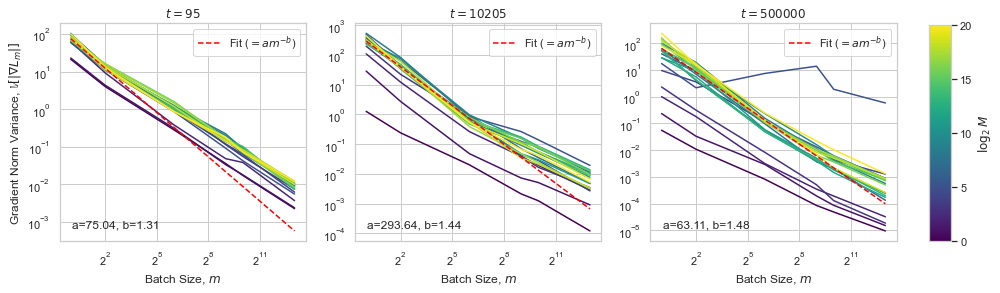

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase

# gradient_norm_variance_t100['grad/norm/mean'] = [p.item() for p in gradient_norm_variance_t100['grad/norm/mean']]
# gradient_norm_variance_t100['grad/norm/std'] = [p.item() for p in gradient_norm_variance_t100['grad/norm/std']]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ts = [min(checkpointer.file_ids, key=lambda x: abs(x-step)) for step in [100, 10_000, 500_000]]

gradient_norm_dfs = dict(zip(ts, [gradient_norm_variance_t100, gradient_norm_variance_t10k, gradient_norm_variance_t500k]))

for (t, grad_norm_df), ax, t_popt in zip(gradient_norm_dfs.items(), axes.flatten(), [t100_popt, t10k_popt, t500k_popt]):
    grad_norm_df["grad/norm/var"] = grad_norm_df["grad/norm/std"] ** 2

    sns.lineplot(
        data=grad_norm_df[grad_norm_df["layer"] == "average"],
        x="batch_size",
        y="grad/norm/var",
        hue="m",
        palette="viridis",
        ax=ax,
        legend=False
    ) 

    # Plot the fit
    # ax.plot(batch_sizes, 10 ** func(np.log2(batch_sizes), *t_popt), color="red", linestyle="--", label="Fit")
    ax.plot(batch_sizes, func(batch_sizes, *t_popt), color="red", linestyle="--", label="Fit ($=am^{-b}$)")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    # ax.set_xticklabels([f"${{{int(np.log2(x))}}}$" for x in ax.get_xticks()])

    ax.set_xlabel(r"Batch Size, $m$")
    ax.set_ylabel(r"Gradient Norm Variance, $\mathbb{V}[|\nabla L_m|]$")
    ax.legend()
    
    ax.set_title(f"$t={t+1}$")

    param_text = f'a={t_popt[0]:.2f}, b={t_popt[1]:.2f}'
    ax.text(0.05, 0.1, param_text, transform=ax.transAxes, verticalalignment='top')

for ax in axes[1:]:
    ax.set_ylabel("")

cbar_ax = fig.add_axes([0.93, 0.125, 0.02, 0.75])  # Adjust as necessary for position and size
# plt.tight_layout()

# Define the colormap
cmap = plt.cm.viridis

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=20), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = [0, 5, 10, 15, 20]  # Positions for each color
tick_labels = map(str, tick_positions)  # Labels for each color
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$\log_2 M$")


In terms of this power law $g_n=am^b$, we get that

$$
am^b \ll \frac{1}{\beta n}.
$$

Plugging in $\beta^*=1/\log n$ and moving terms around, this becomes:

$$
\log_2 m \ll \frac{1}{b}\log_2 \left(\frac{\log n}{2 a n}\right).
$$

<ipython-input-156-180dc6ae37e2>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"$2^{{{int(x)}}}$" for x in ax.get_yticks()])


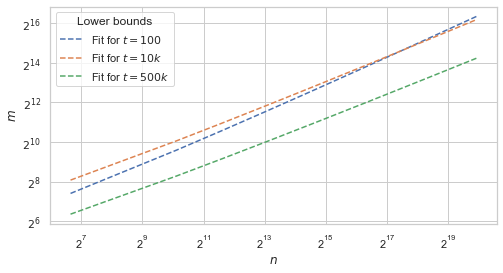

In [ ]:
n = np.linspace(100, 1_000_000, 1000)

def upper_bound(n, a, b):
    return -np.log2( 2 * np.log(n) / (a * n)) / b

fig, ax = plt.subplots(figsize=(8, 4))

for t_label, t_popt in zip(["100", "10k", "500k"], [t100_popt, t10k_popt, t500k_popt]):
    ax.plot(n, upper_bound(n, *t_popt), linestyle="--", label=f"Fit for $t={t_label}$") 

ax.set_yticklabels([f"$2^{{{int(x)}}}$" for x in ax.get_yticks()])
ax.set_xscale("log", base=2)

ax.set_ylabel(r"$m$")
ax.set_xlabel(r"$n$")
ax.legend(title="Lower bounds")

# Garbage Collection

In [ ]:
# Garbage collection
import gc

print(torch.mps.current_allocated_memory() / 1e9)
gc.collect()
torch.mps.empty_cache()  # If you're using a CUDA-enabled GPU
torch.mps.current_allocated_memory() / 1e9

61.045873664


0.0

In [94]:
a = torch.range(0, 9).reshape((2, 5))
a

<ipython-input-94-a942f827d73f>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  a = torch.range(0, 9).reshape((2, 5))


tensor([[0., 1., 2., 3., 4.],
        [5., 6., 7., 8., 9.]])